In [ ]:
from keras.models import Sequential
from keras.layers import *
from matplotlib import pyplot as plt
import numpy as np
import cv2
from numpy.random import randn, randint
import os
from keras.datasets.mnist import load_data as origin_load_data
from keras.optimizers import Adam
from keras.models import Sequential, Model
import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
def adam_optimizer():
    return Adam(lr=0.0001, beta_1=0.3)


def create_generator(latent_dim=100):
    model = Sequential()
    model.add(Dense(7*7*512, input_dim=latent_dim, activation='relu'))

    new_shape = (7, 7, 512)
    model.add(Reshape(new_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(filters=256, kernel_size=(
        3, 3), padding='same', strides=2))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(filters=128, kernel_size=(
        4, 4), padding='same', strides=2))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, kernel_size=(5, 5), strides=1,
              padding='same', activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

    return model


def create_discriminator(inp_shape=(28, 28, 1)):
    model = Sequential()
    # output: (14*14*512)
    model.add(Conv2D(filters=512, kernel_size=(5, 5),
              strides=2, padding='same', input_shape=inp_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # output: (7*7*64)
    model.add(Conv2D(filters=256, kernel_size=(
        3, 3), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(filters=128, kernel_size=(
        3, 3), strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=adam_optimizer(), metrics=['accuracy'])
    return model


def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return gan

In [ ]:
def load_data():
    (x_train, y_train), (x_test, y_test) = origin_load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_train = np.expand_dims(x_train, axis=-1)
    return (x_train, y_train, x_test, y_test)


def gen_z_input(batch_size, latent_dim=100):
    "create noise input for generator"
    z = np.random.normal(0, 1, [batch_size, 100])
    return z


def gen_fake_image(generator, batch_size):
    "create fake image from generator"
    z = gen_z_input(batch_size)
    fake_image = generator.predict(z)
    fake_label = gen_label(batch_size, is_real=False)
    return fake_image, fake_label


def plot_image(images, n=5):
    "plot image from generator"
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.show()


def gen_real_image(dataset, batch_size):
    "create real image from dataset"
    ix = randint(0, dataset.shape[0], batch_size)
    real_image = dataset[ix]
    real_label = gen_label(batch_size, is_real=True)
    return real_image, real_label


def val_model(discriminator, generator, val_dataset):
    "validate discriminator model"
    batch_size = 32
    real_acc = []
    fake_acc = []

    for i in range(len(val_dataset)//batch_size-1):
        real_image = val_dataset[i:i+1]
        z = gen_z_input(batch_size)
        fake_image = generator.predict(z)
        real_acc.append(discriminator.predict(real_image)[:].mean())
        fake_acc.append(discriminator.predict(fake_image)[:].mean())
    return np.array(real_acc).mean(), 1 - np.array(fake_acc).mean()


def gen_label(size, is_real=True, noise_ratio=0.1):
    "create label for discriminator"
    if is_real:
        label = np.ones(size,)*0.9
    else:
        label = np.ones(size,)*0.1
    return np.squeeze(label)


def val_gan_model(GAN_model, epochs=100):
    "validate gan model"
    gan_acc = []
    batch_size = 32
    for i in range(epochs):
        z = np.random.rand(batch_size, 100)
        acc = GAN_model.predict(z).mean()
        gan_acc.append(acc)
    return np.array(gan_acc).mean()

In [ ]:
generator = create_generator()
discriminator = create_discriminator()
GAN_model = create_gan(discriminator, generator)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


11490434/11490434 [==============================] - 0s 0us/step


  0%|          | 0/750 [00:00<?, ?it/s]

1/1 [==============================] - 1s 541ms/step


  0%|          | 1/750 [00:02<36:41,  2.94s/it]

1/1 [==============================] - 0s 123ms/step


  0%|          | 2/750 [00:03<21:10,  1.70s/it]

1/1 [==============================] - 0s 121ms/step


  0%|          | 3/750 [00:04<16:11,  1.30s/it]

1/1 [==============================] - 0s 123ms/step


  1%|          | 4/750 [00:05<15:07,  1.22s/it]

1/1 [==============================] - 0s 210ms/step


  1%|          | 5/750 [00:07<16:03,  1.29s/it]

1/1 [==============================] - 0s 192ms/step


  1%|          | 6/750 [00:08<16:26,  1.33s/it]

1/1 [==============================] - 0s 191ms/step


  1%|          | 7/750 [00:09<16:29,  1.33s/it]

1/1 [==============================] - 0s 195ms/step


  1%|          | 8/750 [00:11<17:09,  1.39s/it]

1/1 [==============================] - 0s 184ms/step


  1%|          | 9/750 [00:12<16:13,  1.31s/it]

1/1 [==============================] - 0s 118ms/step


  1%|▏         | 10/750 [00:13<14:19,  1.16s/it]

1/1 [==============================] - 0s 123ms/step


  1%|▏         | 11/750 [00:14<13:02,  1.06s/it]

1/1 [==============================] - 0s 125ms/step


  2%|▏         | 12/750 [00:14<12:10,  1.01it/s]

1/1 [==============================] - 0s 131ms/step


  2%|▏         | 13/750 [00:15<11:36,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▏         | 14/750 [00:16<11:11,  1.10it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▏         | 15/750 [00:17<10:53,  1.13it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▏         | 16/750 [00:18<10:44,  1.14it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 17/750 [00:19<10:34,  1.15it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▏         | 18/750 [00:20<10:28,  1.16it/s]

1/1 [==============================] - 0s 126ms/step


  3%|▎         | 19/750 [00:20<10:24,  1.17it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 20/750 [00:21<10:16,  1.18it/s]

1/1 [==============================] - 0s 119ms/step


  3%|▎         | 21/750 [00:23<12:08,  1.00it/s]

1/1 [==============================] - 1s 673ms/step


  3%|▎         | 22/750 [00:26<19:45,  1.63s/it]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 23/750 [00:27<18:47,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 24/750 [00:28<18:12,  1.50s/it]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 25/750 [00:30<16:42,  1.38s/it]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 26/750 [00:30<14:37,  1.21s/it]

1/1 [==============================] - 0s 121ms/step


  4%|▎         | 27/750 [00:31<13:09,  1.09s/it]

1/1 [==============================] - 0s 120ms/step


  4%|▎         | 28/750 [00:32<12:10,  1.01s/it]

1/1 [==============================] - 0s 116ms/step


  4%|▍         | 29/750 [00:33<11:28,  1.05it/s]

1/1 [==============================] - 0s 122ms/step


  4%|▍         | 30/750 [00:34<10:58,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 31/750 [00:34<10:33,  1.14it/s]

1/1 [==============================] - 0s 122ms/step


  4%|▍         | 32/750 [00:35<10:17,  1.16it/s]

1/1 [==============================] - 0s 118ms/step


  4%|▍         | 33/750 [00:36<10:09,  1.18it/s]

1/1 [==============================] - 0s 116ms/step


  5%|▍         | 34/750 [00:37<10:05,  1.18it/s]

1/1 [==============================] - 0s 124ms/step


  5%|▍         | 35/750 [00:38<10:01,  1.19it/s]

1/1 [==============================] - 0s 116ms/step


  5%|▍         | 36/750 [00:39<09:57,  1.19it/s]

1/1 [==============================] - 0s 126ms/step


  5%|▍         | 37/750 [00:40<10:23,  1.14it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 38/750 [00:41<12:13,  1.03s/it]

1/1 [==============================] - 0s 199ms/step


  5%|▌         | 39/750 [00:42<13:24,  1.13s/it]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 40/750 [00:44<14:06,  1.19s/it]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 41/750 [00:45<14:46,  1.25s/it]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 42/750 [00:46<15:00,  1.27s/it]

1/1 [==============================] - 0s 163ms/step


  6%|▌         | 43/750 [00:47<13:42,  1.16s/it]

1/1 [==============================] - 0s 140ms/step


  6%|▌         | 44/750 [00:48<12:31,  1.07s/it]

1/1 [==============================] - 0s 124ms/step


  6%|▌         | 45/750 [00:49<11:39,  1.01it/s]

1/1 [==============================] - 0s 120ms/step


  6%|▌         | 46/750 [00:50<11:05,  1.06it/s]

1/1 [==============================] - 0s 121ms/step


  6%|▋         | 47/750 [00:51<10:39,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


  6%|▋         | 48/750 [00:51<10:22,  1.13it/s]

1/1 [==============================] - 0s 118ms/step


  7%|▋         | 49/750 [00:52<10:09,  1.15it/s]

1/1 [==============================] - 0s 118ms/step


  7%|▋         | 50/750 [00:53<09:54,  1.18it/s]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 51/750 [00:54<09:48,  1.19it/s]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 52/750 [00:55<09:47,  1.19it/s]

1/1 [==============================] - 0s 117ms/step


  7%|▋         | 53/750 [00:56<09:47,  1.19it/s]

1/1 [==============================] - 0s 122ms/step


  7%|▋         | 54/750 [00:56<09:42,  1.20it/s]

1/1 [==============================] - 0s 124ms/step


  7%|▋         | 55/750 [00:58<11:11,  1.03it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 56/750 [00:59<12:37,  1.09s/it]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 57/750 [01:00<13:44,  1.19s/it]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 58/750 [01:02<14:14,  1.23s/it]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 59/750 [01:03<14:29,  1.26s/it]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 60/750 [01:04<14:17,  1.24s/it]

1/1 [==============================] - 0s 120ms/step


  8%|▊         | 61/750 [01:05<12:51,  1.12s/it]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 62/750 [01:06<11:50,  1.03s/it]

1/1 [==============================] - 0s 120ms/step


  8%|▊         | 63/750 [01:07<11:07,  1.03it/s]

1/1 [==============================] - 0s 117ms/step


  9%|▊         | 64/750 [01:08<10:34,  1.08it/s]

1/1 [==============================] - 0s 132ms/step


  9%|▊         | 65/750 [01:08<10:14,  1.11it/s]

1/1 [==============================] - 0s 123ms/step


  9%|▉         | 66/750 [01:09<10:03,  1.13it/s]

1/1 [==============================] - 0s 123ms/step


  9%|▉         | 67/750 [01:10<09:53,  1.15it/s]

1/1 [==============================] - 0s 123ms/step


  9%|▉         | 68/750 [01:11<09:41,  1.17it/s]

1/1 [==============================] - 0s 121ms/step


  9%|▉         | 69/750 [01:12<09:33,  1.19it/s]

1/1 [==============================] - 0s 133ms/step


  9%|▉         | 70/750 [01:13<09:31,  1.19it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 71/750 [01:13<09:29,  1.19it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 72/750 [01:14<10:09,  1.11it/s]

1/1 [==============================] - 0s 198ms/step


 10%|▉         | 73/750 [01:16<11:47,  1.05s/it]

1/1 [==============================] - 0s 189ms/step


 10%|▉         | 74/750 [01:17<12:50,  1.14s/it]

1/1 [==============================] - 0s 194ms/step


 10%|█         | 75/750 [01:19<13:42,  1.22s/it]

1/1 [==============================] - 0s 200ms/step


 10%|█         | 76/750 [01:20<14:12,  1.27s/it]

1/1 [==============================] - 0s 207ms/step


 10%|█         | 77/750 [01:21<14:41,  1.31s/it]

1/1 [==============================] - 0s 118ms/step


 10%|█         | 78/750 [01:22<13:01,  1.16s/it]

1/1 [==============================] - 0s 125ms/step


 11%|█         | 79/750 [01:23<11:53,  1.06s/it]

1/1 [==============================] - 0s 116ms/step


 11%|█         | 80/750 [01:24<11:01,  1.01it/s]

1/1 [==============================] - 0s 121ms/step


 11%|█         | 81/750 [01:25<10:29,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 11%|█         | 82/750 [01:25<10:05,  1.10it/s]

1/1 [==============================] - 0s 117ms/step


 11%|█         | 83/750 [01:26<09:45,  1.14it/s]

1/1 [==============================] - 0s 121ms/step


 11%|█         | 84/750 [01:27<09:35,  1.16it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█▏        | 85/750 [01:28<09:29,  1.17it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█▏        | 86/750 [01:29<09:25,  1.17it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 87/750 [01:30<09:22,  1.18it/s]

1/1 [==============================] - 0s 119ms/step


 12%|█▏        | 88/750 [01:30<09:19,  1.18it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 89/750 [01:31<09:15,  1.19it/s]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 90/750 [01:33<11:09,  1.01s/it]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 91/750 [01:34<12:20,  1.12s/it]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 92/750 [01:35<13:07,  1.20s/it]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 93/750 [01:37<13:40,  1.25s/it]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 94/750 [01:38<13:56,  1.28s/it]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 95/750 [01:39<12:49,  1.18s/it]

1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 96/750 [01:40<11:42,  1.07s/it]

1/1 [==============================] - 0s 116ms/step


 13%|█▎        | 97/750 [01:41<10:51,  1.00it/s]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 98/750 [01:42<10:19,  1.05it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 99/750 [01:42<09:55,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 100/750 [01:43<09:37,  1.13it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 101/750 [01:44<09:24,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▎        | 102/750 [01:45<09:11,  1.17it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▎        | 103/750 [01:46<09:04,  1.19it/s]

1/1 [==============================] - 0s 188ms/step


 14%|█▍        | 104/750 [01:47<10:43,  1.00it/s]

1/1 [==============================] - 0s 122ms/step


 14%|█▍        | 105/750 [01:48<10:13,  1.05it/s]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 106/750 [01:49<11:47,  1.10s/it]

1/1 [==============================] - 0s 202ms/step


 14%|█▍        | 107/750 [01:51<13:09,  1.23s/it]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 108/750 [01:52<13:59,  1.31s/it]

1/1 [==============================] - 0s 205ms/step


 15%|█▍        | 109/750 [01:54<14:16,  1.34s/it]

1/1 [==============================] - 0s 192ms/step


 15%|█▍        | 110/750 [01:55<14:15,  1.34s/it]

1/1 [==============================] - 0s 202ms/step


 15%|█▍        | 111/750 [01:56<13:16,  1.25s/it]

1/1 [==============================] - 0s 119ms/step


 15%|█▍        | 112/750 [01:57<11:54,  1.12s/it]

1/1 [==============================] - 0s 119ms/step


 15%|█▌        | 113/750 [01:58<10:56,  1.03s/it]

1/1 [==============================] - 0s 121ms/step


 15%|█▌        | 114/750 [01:59<10:21,  1.02it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▌        | 115/750 [02:00<09:49,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▌        | 116/750 [02:00<09:29,  1.11it/s]

1/1 [==============================] - 0s 118ms/step


 16%|█▌        | 117/750 [02:01<09:15,  1.14it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 118/750 [02:02<09:07,  1.15it/s]

1/1 [==============================] - 0s 116ms/step


 16%|█▌        | 119/750 [02:03<08:59,  1.17it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 120/750 [02:04<08:51,  1.19it/s]

1/1 [==============================] - 0s 119ms/step


 16%|█▌        | 121/750 [02:04<08:48,  1.19it/s]

1/1 [==============================] - 0s 119ms/step


 16%|█▋        | 122/750 [02:05<08:45,  1.20it/s]

1/1 [==============================] - 0s 127ms/step


 16%|█▋        | 123/750 [02:06<09:37,  1.09it/s]

1/1 [==============================] - 0s 198ms/step


 17%|█▋        | 124/750 [02:08<11:05,  1.06s/it]

1/1 [==============================] - 0s 192ms/step


 17%|█▋        | 125/750 [02:09<12:06,  1.16s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█▋        | 126/750 [02:11<12:46,  1.23s/it]

1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 127/750 [02:12<13:06,  1.26s/it]

1/1 [==============================] - 0s 206ms/step


 17%|█▋        | 128/750 [02:13<13:06,  1.26s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 129/750 [02:14<11:42,  1.13s/it]

1/1 [==============================] - 0s 118ms/step


 17%|█▋        | 130/750 [02:15<10:46,  1.04s/it]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 131/750 [02:16<10:06,  1.02it/s]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 132/750 [02:17<09:40,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 133/750 [02:17<09:22,  1.10it/s]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 134/750 [02:18<09:08,  1.12it/s]

1/1 [==============================] - 0s 117ms/step


 18%|█▊        | 135/750 [02:19<08:53,  1.15it/s]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 136/750 [02:20<08:45,  1.17it/s]

1/1 [==============================] - 0s 121ms/step


 18%|█▊        | 137/750 [02:21<08:42,  1.17it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 138/750 [02:22<08:38,  1.18it/s]

1/1 [==============================] - 0s 128ms/step


 19%|█▊        | 139/750 [02:22<08:36,  1.18it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▊        | 140/750 [02:23<08:54,  1.14it/s]

1/1 [==============================] - 0s 188ms/step


 19%|█▉        | 141/750 [02:25<10:25,  1.03s/it]

1/1 [==============================] - 0s 192ms/step


 19%|█▉        | 142/750 [02:26<11:23,  1.12s/it]

1/1 [==============================] - 0s 195ms/step


 19%|█▉        | 143/750 [02:27<11:58,  1.18s/it]

1/1 [==============================] - 0s 212ms/step


 19%|█▉        | 144/750 [02:29<12:26,  1.23s/it]

1/1 [==============================] - 0s 199ms/step


 19%|█▉        | 145/750 [02:30<12:51,  1.28s/it]

1/1 [==============================] - 0s 191ms/step


 19%|█▉        | 146/750 [02:31<11:53,  1.18s/it]

1/1 [==============================] - 0s 117ms/step


 20%|█▉        | 147/750 [02:32<10:47,  1.07s/it]

1/1 [==============================] - 0s 117ms/step


 20%|█▉        | 148/750 [02:33<10:02,  1.00s/it]

1/1 [==============================] - 0s 127ms/step


 20%|█▉        | 149/750 [02:34<09:33,  1.05it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 150/750 [02:34<09:10,  1.09it/s]

1/1 [==============================] - 0s 115ms/step


 20%|██        | 151/750 [02:35<08:51,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 20%|██        | 152/750 [02:36<08:44,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 20%|██        | 153/750 [02:37<08:33,  1.16it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██        | 154/750 [02:38<08:25,  1.18it/s]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 155/750 [02:39<08:18,  1.19it/s]

1/1 [==============================] - 0s 120ms/step


 21%|██        | 156/750 [02:39<08:15,  1.20it/s]

1/1 [==============================] - 0s 121ms/step


 21%|██        | 157/750 [02:40<08:14,  1.20it/s]

1/1 [==============================] - 0s 117ms/step


 21%|██        | 158/750 [02:41<09:19,  1.06it/s]

1/1 [==============================] - 0s 191ms/step


 21%|██        | 159/750 [02:43<10:43,  1.09s/it]

1/1 [==============================] - 0s 197ms/step


 21%|██▏       | 160/750 [02:44<11:32,  1.17s/it]

1/1 [==============================] - 0s 189ms/step


 21%|██▏       | 161/750 [02:46<12:02,  1.23s/it]

1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 162/750 [02:47<12:22,  1.26s/it]

1/1 [==============================] - 0s 182ms/step


 22%|██▏       | 163/750 [02:48<12:05,  1.24s/it]

1/1 [==============================] - 0s 117ms/step


 22%|██▏       | 164/750 [02:49<10:51,  1.11s/it]

1/1 [==============================] - 0s 117ms/step


 22%|██▏       | 165/750 [02:50<09:59,  1.02s/it]

1/1 [==============================] - 0s 123ms/step


 22%|██▏       | 166/750 [02:51<09:27,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 22%|██▏       | 167/750 [02:51<08:59,  1.08it/s]

1/1 [==============================] - 0s 122ms/step


 22%|██▏       | 168/750 [02:52<08:39,  1.12it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 169/750 [02:53<08:30,  1.14it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 170/750 [02:54<08:22,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 171/750 [02:55<08:14,  1.17it/s]

1/1 [==============================] - 0s 116ms/step


 23%|██▎       | 172/750 [02:56<08:07,  1.19it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 173/750 [02:56<08:05,  1.19it/s]

1/1 [==============================] - 0s 121ms/step


 23%|██▎       | 174/750 [02:57<08:04,  1.19it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 175/750 [02:58<08:23,  1.14it/s]

1/1 [==============================] - 0s 201ms/step


 23%|██▎       | 176/750 [03:00<10:21,  1.08s/it]

1/1 [==============================] - 0s 192ms/step


 24%|██▎       | 177/750 [03:01<11:06,  1.16s/it]

1/1 [==============================] - 0s 179ms/step


 24%|██▎       | 178/750 [03:02<11:33,  1.21s/it]

1/1 [==============================] - 0s 198ms/step


 24%|██▍       | 179/750 [03:04<12:13,  1.28s/it]

1/1 [==============================] - 0s 184ms/step


 24%|██▍       | 180/750 [03:05<12:10,  1.28s/it]

1/1 [==============================] - 0s 158ms/step


 24%|██▍       | 181/750 [03:06<11:04,  1.17s/it]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 182/750 [03:07<10:06,  1.07s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██▍       | 183/750 [03:08<09:25,  1.00it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▍       | 184/750 [03:09<08:55,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▍       | 185/750 [03:09<08:34,  1.10it/s]

1/1 [==============================] - 0s 117ms/step


 25%|██▍       | 186/750 [03:10<08:19,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▍       | 187/750 [03:11<08:06,  1.16it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██▌       | 188/750 [03:12<07:58,  1.17it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▌       | 189/750 [03:13<07:54,  1.18it/s]

1/1 [==============================] - 0s 117ms/step


 25%|██▌       | 190/750 [03:13<07:51,  1.19it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▌       | 191/750 [03:14<07:49,  1.19it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 192/750 [03:15<07:45,  1.20it/s]

1/1 [==============================] - 0s 139ms/step


 26%|██▌       | 193/750 [03:16<09:12,  1.01it/s]

1/1 [==============================] - 0s 217ms/step


 26%|██▌       | 194/750 [03:18<10:37,  1.15s/it]

1/1 [==============================] - 0s 191ms/step


 26%|██▌       | 195/750 [03:19<11:12,  1.21s/it]

1/1 [==============================] - 0s 187ms/step


 26%|██▌       | 196/750 [03:21<11:34,  1.25s/it]

1/1 [==============================] - 0s 181ms/step


 26%|██▋       | 197/750 [03:22<11:44,  1.27s/it]

1/1 [==============================] - 0s 191ms/step


 26%|██▋       | 198/750 [03:23<11:01,  1.20s/it]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 199/750 [03:24<09:57,  1.08s/it]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 200/750 [03:25<09:17,  1.01s/it]

1/1 [==============================] - 0s 123ms/step


 27%|██▋       | 201/750 [03:26<08:43,  1.05it/s]

1/1 [==============================] - 0s 131ms/step


 27%|██▋       | 202/750 [03:26<08:25,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 203/750 [03:27<08:07,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 204/750 [03:28<07:58,  1.14it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 205/750 [03:29<07:52,  1.15it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 206/750 [03:30<07:43,  1.17it/s]

1/1 [==============================] - 0s 130ms/step


 28%|██▊       | 207/750 [03:31<07:39,  1.18it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 208/750 [03:31<07:38,  1.18it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 209/750 [03:32<07:34,  1.19it/s]

1/1 [==============================] - 0s 128ms/step


 28%|██▊       | 210/750 [03:33<08:24,  1.07it/s]

1/1 [==============================] - 0s 199ms/step


 28%|██▊       | 211/750 [03:35<09:35,  1.07s/it]

1/1 [==============================] - 0s 205ms/step


 28%|██▊       | 212/750 [03:36<10:23,  1.16s/it]

1/1 [==============================] - 0s 190ms/step


 28%|██▊       | 213/750 [03:37<10:53,  1.22s/it]

1/1 [==============================] - 0s 208ms/step


 29%|██▊       | 214/750 [03:39<11:17,  1.26s/it]

1/1 [==============================] - 0s 191ms/step


 29%|██▊       | 215/750 [03:40<11:03,  1.24s/it]

1/1 [==============================] - 0s 127ms/step


 29%|██▉       | 216/750 [03:41<09:54,  1.11s/it]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 217/750 [03:42<09:07,  1.03s/it]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 218/750 [03:42<08:31,  1.04it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 219/750 [03:43<08:10,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 220/750 [03:44<07:51,  1.12it/s]

1/1 [==============================] - 0s 132ms/step


 29%|██▉       | 221/750 [03:45<07:41,  1.15it/s]

1/1 [==============================] - 0s 116ms/step


 30%|██▉       | 222/750 [03:46<07:34,  1.16it/s]

1/1 [==============================] - 0s 118ms/step


 30%|██▉       | 223/750 [03:47<07:28,  1.18it/s]

1/1 [==============================] - 0s 126ms/step


 30%|██▉       | 224/750 [03:47<07:29,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 30%|███       | 225/750 [03:48<07:25,  1.18it/s]

1/1 [==============================] - 0s 129ms/step


 30%|███       | 226/750 [03:49<07:22,  1.18it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 227/750 [03:50<07:30,  1.16it/s]

1/1 [==============================] - 0s 190ms/step


 30%|███       | 228/750 [03:52<09:02,  1.04s/it]

1/1 [==============================] - 0s 198ms/step


 31%|███       | 229/750 [03:53<09:53,  1.14s/it]

1/1 [==============================] - 0s 189ms/step


 31%|███       | 230/750 [03:54<10:31,  1.22s/it]

1/1 [==============================] - 0s 191ms/step


 31%|███       | 231/750 [03:56<10:49,  1.25s/it]

1/1 [==============================] - 0s 201ms/step


 31%|███       | 232/750 [03:57<11:00,  1.28s/it]

1/1 [==============================] - 0s 160ms/step


 31%|███       | 233/750 [03:58<09:58,  1.16s/it]

1/1 [==============================] - 0s 122ms/step


 31%|███       | 234/750 [03:59<09:06,  1.06s/it]

1/1 [==============================] - 0s 126ms/step


 31%|███▏      | 235/750 [03:59<08:30,  1.01it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███▏      | 236/750 [04:00<08:05,  1.06it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 237/750 [04:01<07:45,  1.10it/s]

1/1 [==============================] - 0s 117ms/step


 32%|███▏      | 238/750 [04:02<07:32,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 239/750 [04:03<07:21,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 240/750 [04:04<07:16,  1.17it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 241/750 [04:04<07:14,  1.17it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 242/750 [04:05<07:08,  1.19it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 243/750 [04:06<07:08,  1.18it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 244/750 [04:07<07:02,  1.20it/s]

1/1 [==============================] - 0s 141ms/step


 33%|███▎      | 245/750 [04:08<08:13,  1.02it/s]

1/1 [==============================] - 0s 195ms/step


 33%|███▎      | 246/750 [04:10<09:12,  1.10s/it]

1/1 [==============================] - 0s 191ms/step


 33%|███▎      | 247/750 [04:11<09:51,  1.18s/it]

1/1 [==============================] - 0s 194ms/step


 33%|███▎      | 248/750 [04:12<10:12,  1.22s/it]

1/1 [==============================] - 0s 195ms/step


 33%|███▎      | 249/750 [04:14<10:33,  1.26s/it]

1/1 [==============================] - 0s 192ms/step


 33%|███▎      | 250/750 [04:15<10:22,  1.25s/it]

1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 251/750 [04:16<09:18,  1.12s/it]

1/1 [==============================] - 0s 118ms/step


 34%|███▎      | 252/750 [04:17<08:36,  1.04s/it]

1/1 [==============================] - 0s 125ms/step


 34%|███▎      | 253/750 [04:17<08:03,  1.03it/s]

1/1 [==============================] - 0s 135ms/step


 34%|███▍      | 254/750 [04:18<07:43,  1.07it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 255/750 [04:19<07:27,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 256/750 [04:20<07:16,  1.13it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 257/750 [04:21<07:11,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 258/750 [04:22<07:01,  1.17it/s]

1/1 [==============================] - 0s 132ms/step


 35%|███▍      | 259/750 [04:22<06:56,  1.18it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▍      | 260/750 [04:23<06:53,  1.18it/s]

1/1 [==============================] - 0s 119ms/step


 35%|███▍      | 261/750 [04:24<06:50,  1.19it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 262/750 [04:25<07:26,  1.09it/s]

1/1 [==============================] - 0s 201ms/step


 35%|███▌      | 263/750 [04:27<08:36,  1.06s/it]

1/1 [==============================] - 0s 204ms/step


 35%|███▌      | 264/750 [04:28<09:23,  1.16s/it]

1/1 [==============================] - 0s 202ms/step


 35%|███▌      | 265/750 [04:29<09:52,  1.22s/it]

1/1 [==============================] - 0s 198ms/step


 35%|███▌      | 266/750 [04:31<10:24,  1.29s/it]

1/1 [==============================] - 0s 187ms/step


 36%|███▌      | 267/750 [04:32<10:12,  1.27s/it]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 268/750 [04:33<09:06,  1.13s/it]

1/1 [==============================] - 0s 119ms/step


 36%|███▌      | 269/750 [04:34<08:19,  1.04s/it]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 270/750 [04:34<07:49,  1.02it/s]

1/1 [==============================] - 0s 123ms/step


 36%|███▌      | 271/750 [04:35<07:28,  1.07it/s]

1/1 [==============================] - 0s 123ms/step


 36%|███▋      | 272/750 [04:36<07:10,  1.11it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▋      | 273/750 [04:37<07:01,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 37%|███▋      | 274/750 [04:38<06:53,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 37%|███▋      | 275/750 [04:39<06:48,  1.16it/s]

1/1 [==============================] - 0s 121ms/step


 37%|███▋      | 276/750 [04:39<06:43,  1.18it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 277/750 [04:40<06:38,  1.19it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 278/750 [04:41<06:36,  1.19it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 279/750 [04:42<06:45,  1.16it/s]

1/1 [==============================] - 0s 185ms/step


 37%|███▋      | 280/750 [04:43<08:03,  1.03s/it]

1/1 [==============================] - 0s 216ms/step


 37%|███▋      | 281/750 [04:45<09:09,  1.17s/it]

1/1 [==============================] - 0s 192ms/step


 38%|███▊      | 282/750 [04:46<09:29,  1.22s/it]

1/1 [==============================] - 0s 201ms/step


 38%|███▊      | 283/750 [04:48<09:48,  1.26s/it]

1/1 [==============================] - 0s 190ms/step


 38%|███▊      | 284/750 [04:49<10:01,  1.29s/it]

1/1 [==============================] - 0s 174ms/step


 38%|███▊      | 285/750 [04:50<09:09,  1.18s/it]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 286/750 [04:51<08:19,  1.08s/it]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 287/750 [04:52<07:44,  1.00s/it]

1/1 [==============================] - 0s 130ms/step


 38%|███▊      | 288/750 [04:52<07:18,  1.05it/s]

1/1 [==============================] - 0s 121ms/step


 39%|███▊      | 289/750 [04:53<07:02,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 39%|███▊      | 290/750 [04:54<06:49,  1.12it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▉      | 291/750 [04:55<06:40,  1.15it/s]

1/1 [==============================] - 0s 118ms/step


 39%|███▉      | 292/750 [04:56<06:31,  1.17it/s]

1/1 [==============================] - 0s 129ms/step


 39%|███▉      | 293/750 [04:57<06:25,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 294/750 [04:57<06:22,  1.19it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 295/750 [04:58<06:21,  1.19it/s]

1/1 [==============================] - 0s 115ms/step


 39%|███▉      | 296/750 [04:59<06:19,  1.20it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 297/750 [05:00<07:26,  1.01it/s]

1/1 [==============================] - 0s 193ms/step


 40%|███▉      | 298/750 [05:02<08:14,  1.10s/it]

1/1 [==============================] - 0s 193ms/step


 40%|███▉      | 299/750 [05:03<08:50,  1.18s/it]

1/1 [==============================] - 0s 185ms/step


 40%|████      | 300/750 [05:04<09:15,  1.23s/it]

1/1 [==============================] - 0s 189ms/step


 40%|████      | 301/750 [05:06<09:30,  1.27s/it]

1/1 [==============================] - 0s 184ms/step


 40%|████      | 302/750 [05:07<09:06,  1.22s/it]

1/1 [==============================] - 0s 121ms/step


 40%|████      | 303/750 [05:08<08:11,  1.10s/it]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 304/750 [05:09<07:35,  1.02s/it]

1/1 [==============================] - 0s 124ms/step


 41%|████      | 305/750 [05:09<07:08,  1.04it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 306/750 [05:10<06:51,  1.08it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████      | 307/750 [05:11<06:39,  1.11it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 308/750 [05:12<06:30,  1.13it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████      | 309/750 [05:13<06:22,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████▏     | 310/750 [05:14<06:15,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████▏     | 311/750 [05:14<06:10,  1.19it/s]

1/1 [==============================] - 0s 133ms/step


 42%|████▏     | 312/750 [05:15<06:09,  1.19it/s]

1/1 [==============================] - 0s 122ms/step


 42%|████▏     | 313/750 [05:16<06:06,  1.19it/s]

1/1 [==============================] - 0s 114ms/step


 42%|████▏     | 314/750 [05:17<06:37,  1.10it/s]

1/1 [==============================] - 0s 192ms/step


 42%|████▏     | 315/750 [05:19<07:58,  1.10s/it]

1/1 [==============================] - 0s 194ms/step


 42%|████▏     | 316/750 [05:20<08:28,  1.17s/it]

1/1 [==============================] - 0s 195ms/step


 42%|████▏     | 317/750 [05:21<09:01,  1.25s/it]

1/1 [==============================] - 0s 199ms/step


 42%|████▏     | 318/750 [05:23<09:10,  1.28s/it]

1/1 [==============================] - 0s 197ms/step


 43%|████▎     | 319/750 [05:24<09:12,  1.28s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 320/750 [05:25<08:10,  1.14s/it]

1/1 [==============================] - 0s 118ms/step


 43%|████▎     | 321/750 [05:26<07:29,  1.05s/it]

1/1 [==============================] - 0s 129ms/step


 43%|████▎     | 322/750 [05:27<07:01,  1.02it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 323/750 [05:27<06:42,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 43%|████▎     | 324/750 [05:28<06:29,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 325/750 [05:29<06:19,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 326/750 [05:30<06:10,  1.14it/s]

1/1 [==============================] - 0s 129ms/step


 44%|████▎     | 327/750 [05:31<06:05,  1.16it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▎     | 328/750 [05:32<05:58,  1.18it/s]

1/1 [==============================] - 0s 118ms/step


 44%|████▍     | 329/750 [05:32<05:56,  1.18it/s]

1/1 [==============================] - 0s 121ms/step


 44%|████▍     | 330/750 [05:33<05:55,  1.18it/s]

1/1 [==============================] - 0s 116ms/step


 44%|████▍     | 331/750 [05:34<05:56,  1.17it/s]

1/1 [==============================] - 0s 190ms/step


 44%|████▍     | 332/750 [05:36<07:05,  1.02s/it]

1/1 [==============================] - 0s 195ms/step


 44%|████▍     | 333/750 [05:37<08:03,  1.16s/it]

1/1 [==============================] - 0s 197ms/step


 45%|████▍     | 334/750 [05:38<08:34,  1.24s/it]

1/1 [==============================] - 0s 209ms/step


 45%|████▍     | 335/750 [05:40<08:49,  1.28s/it]

1/1 [==============================] - 0s 188ms/step


 45%|████▍     | 336/750 [05:41<08:59,  1.30s/it]

1/1 [==============================] - 0s 118ms/step


 45%|████▍     | 337/750 [05:42<07:59,  1.16s/it]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 338/750 [05:43<07:18,  1.06s/it]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 339/750 [05:44<06:49,  1.00it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▌     | 340/750 [05:45<06:28,  1.06it/s]

1/1 [==============================] - 0s 129ms/step


 45%|████▌     | 341/750 [05:45<06:13,  1.09it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 342/750 [05:46<06:05,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████▌     | 343/750 [05:47<05:57,  1.14it/s]

1/1 [==============================] - 0s 116ms/step


 46%|████▌     | 344/750 [05:48<05:52,  1.15it/s]

1/1 [==============================] - 0s 134ms/step


 46%|████▌     | 345/750 [05:49<05:47,  1.16it/s]

1/1 [==============================] - 0s 116ms/step


 46%|████▌     | 346/750 [05:50<05:43,  1.18it/s]

1/1 [==============================] - 0s 136ms/step


 46%|████▋     | 347/750 [05:50<05:43,  1.17it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▋     | 348/750 [05:51<05:42,  1.17it/s]

1/1 [==============================] - 0s 184ms/step


 47%|████▋     | 349/750 [05:53<06:50,  1.02s/it]

1/1 [==============================] - 0s 192ms/step


 47%|████▋     | 350/750 [05:54<07:46,  1.17s/it]

1/1 [==============================] - 0s 192ms/step


 47%|████▋     | 351/750 [05:56<08:08,  1.22s/it]

1/1 [==============================] - 0s 201ms/step


 47%|████▋     | 352/750 [05:57<08:20,  1.26s/it]

1/1 [==============================] - 0s 190ms/step


 47%|████▋     | 353/750 [05:58<08:26,  1.28s/it]

1/1 [==============================] - 0s 190ms/step


 47%|████▋     | 354/750 [05:59<07:46,  1.18s/it]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 355/750 [06:00<07:04,  1.07s/it]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 356/750 [06:01<06:34,  1.00s/it]

1/1 [==============================] - 0s 126ms/step


 48%|████▊     | 357/750 [06:02<06:15,  1.05it/s]

1/1 [==============================] - 0s 127ms/step


 48%|████▊     | 358/750 [06:03<06:02,  1.08it/s]

1/1 [==============================] - 0s 117ms/step


 48%|████▊     | 359/750 [06:03<05:50,  1.12it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 360/750 [06:04<05:41,  1.14it/s]

1/1 [==============================] - 0s 133ms/step


 48%|████▊     | 361/750 [06:05<05:36,  1.16it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 362/750 [06:06<05:32,  1.17it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 363/750 [06:07<05:27,  1.18it/s]

1/1 [==============================] - 0s 116ms/step


 49%|████▊     | 364/750 [06:08<05:24,  1.19it/s]

1/1 [==============================] - 0s 126ms/step


 49%|████▊     | 365/750 [06:08<05:22,  1.19it/s]

1/1 [==============================] - 0s 129ms/step


 49%|████▉     | 366/750 [06:10<06:11,  1.03it/s]

1/1 [==============================] - 0s 188ms/step


 49%|████▉     | 367/750 [06:11<07:03,  1.11s/it]

1/1 [==============================] - 0s 197ms/step


 49%|████▉     | 368/750 [06:12<07:32,  1.18s/it]

1/1 [==============================] - 0s 210ms/step


 49%|████▉     | 369/750 [06:14<07:53,  1.24s/it]

1/1 [==============================] - 0s 200ms/step


 49%|████▉     | 370/750 [06:15<08:06,  1.28s/it]

1/1 [==============================] - 0s 190ms/step


 49%|████▉     | 371/750 [06:16<07:47,  1.23s/it]

1/1 [==============================] - 0s 118ms/step


 50%|████▉     | 372/750 [06:17<07:00,  1.11s/it]

1/1 [==============================] - 0s 121ms/step


 50%|████▉     | 373/750 [06:18<06:27,  1.03s/it]

1/1 [==============================] - 0s 135ms/step


 50%|████▉     | 374/750 [06:19<06:05,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 50%|█████     | 375/750 [06:20<05:52,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 50%|█████     | 376/750 [06:20<05:40,  1.10it/s]

1/1 [==============================] - 0s 123ms/step


 50%|█████     | 377/750 [06:21<05:31,  1.13it/s]

1/1 [==============================] - 0s 123ms/step


 50%|█████     | 378/750 [06:22<05:24,  1.15it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 379/750 [06:23<05:18,  1.16it/s]

1/1 [==============================] - 0s 117ms/step


 51%|█████     | 380/750 [06:24<05:14,  1.17it/s]

1/1 [==============================] - 0s 131ms/step


 51%|█████     | 381/750 [06:25<05:11,  1.18it/s]

1/1 [==============================] - 0s 118ms/step


 51%|█████     | 382/750 [06:25<05:09,  1.19it/s]

1/1 [==============================] - 0s 115ms/step


 51%|█████     | 383/750 [06:27<05:41,  1.07it/s]

1/1 [==============================] - 0s 200ms/step


 51%|█████     | 384/750 [06:28<06:48,  1.12s/it]

1/1 [==============================] - 0s 195ms/step


 51%|█████▏    | 385/750 [06:30<07:14,  1.19s/it]

1/1 [==============================] - 0s 203ms/step


 51%|█████▏    | 386/750 [06:31<07:40,  1.26s/it]

1/1 [==============================] - 0s 198ms/step


 52%|█████▏    | 387/750 [06:32<08:01,  1.33s/it]

1/1 [==============================] - 0s 205ms/step


 52%|█████▏    | 388/750 [06:34<07:36,  1.26s/it]

1/1 [==============================] - 0s 117ms/step


 52%|█████▏    | 389/750 [06:34<06:48,  1.13s/it]

1/1 [==============================] - 0s 118ms/step


 52%|█████▏    | 390/750 [06:35<06:16,  1.05s/it]

1/1 [==============================] - 0s 132ms/step


 52%|█████▏    | 391/750 [06:36<05:51,  1.02it/s]

1/1 [==============================] - 0s 118ms/step


 52%|█████▏    | 392/750 [06:37<05:34,  1.07it/s]

1/1 [==============================] - 0s 128ms/step


 52%|█████▏    | 393/750 [06:38<05:31,  1.08it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████▎    | 394/750 [06:39<05:21,  1.11it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 395/750 [06:39<05:13,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████▎    | 396/750 [06:40<05:07,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 53%|█████▎    | 397/750 [06:41<05:05,  1.16it/s]

1/1 [==============================] - 0s 127ms/step


 53%|█████▎    | 398/750 [06:42<05:02,  1.17it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████▎    | 399/750 [06:43<04:59,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 53%|█████▎    | 400/750 [06:44<05:37,  1.04it/s]

1/1 [==============================] - 0s 200ms/step


 53%|█████▎    | 401/750 [06:46<06:26,  1.11s/it]

1/1 [==============================] - 0s 196ms/step


 54%|█████▎    | 402/750 [06:47<07:02,  1.21s/it]

1/1 [==============================] - 0s 187ms/step


 54%|█████▎    | 403/750 [06:48<07:14,  1.25s/it]

1/1 [==============================] - 0s 198ms/step


 54%|█████▍    | 404/750 [06:50<07:35,  1.32s/it]

1/1 [==============================] - 0s 198ms/step


 54%|█████▍    | 405/750 [06:51<07:12,  1.25s/it]

1/1 [==============================] - 0s 144ms/step


 54%|█████▍    | 406/750 [06:52<06:31,  1.14s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████▍    | 407/750 [06:53<05:59,  1.05s/it]

1/1 [==============================] - 0s 127ms/step


 54%|█████▍    | 408/750 [06:53<05:37,  1.01it/s]

1/1 [==============================] - 0s 119ms/step


 55%|█████▍    | 409/750 [06:54<05:21,  1.06it/s]

1/1 [==============================] - 0s 124ms/step


 55%|█████▍    | 410/750 [06:55<05:10,  1.09it/s]

1/1 [==============================] - 0s 115ms/step


 55%|█████▍    | 411/750 [06:56<05:00,  1.13it/s]

1/1 [==============================] - 0s 131ms/step


 55%|█████▍    | 412/750 [06:57<04:53,  1.15it/s]

1/1 [==============================] - 0s 124ms/step


 55%|█████▌    | 413/750 [06:58<04:50,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 55%|█████▌    | 414/750 [06:58<04:49,  1.16it/s]

1/1 [==============================] - 0s 132ms/step


 55%|█████▌    | 415/750 [06:59<04:46,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 55%|█████▌    | 416/750 [07:00<04:44,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████▌    | 417/750 [07:01<05:21,  1.03it/s]

1/1 [==============================] - 0s 198ms/step


 56%|█████▌    | 418/750 [07:03<06:10,  1.12s/it]

1/1 [==============================] - 0s 192ms/step


 56%|█████▌    | 419/750 [07:04<06:45,  1.23s/it]

1/1 [==============================] - 0s 195ms/step


 56%|█████▌    | 420/750 [07:06<06:55,  1.26s/it]

1/1 [==============================] - 0s 198ms/step


 56%|█████▌    | 421/750 [07:07<07:05,  1.29s/it]

1/1 [==============================] - 0s 192ms/step


 56%|█████▋    | 422/750 [07:08<06:45,  1.24s/it]

1/1 [==============================] - 0s 119ms/step


 56%|█████▋    | 423/750 [07:09<06:05,  1.12s/it]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 424/750 [07:10<05:38,  1.04s/it]

1/1 [==============================] - 0s 119ms/step


 57%|█████▋    | 425/750 [07:11<05:16,  1.03it/s]

1/1 [==============================] - 0s 118ms/step


 57%|█████▋    | 426/750 [07:12<05:02,  1.07it/s]

1/1 [==============================] - 0s 140ms/step


 57%|█████▋    | 427/750 [07:12<04:54,  1.10it/s]

1/1 [==============================] - 0s 119ms/step


 57%|█████▋    | 428/750 [07:13<04:45,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 429/750 [07:14<04:40,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 57%|█████▋    | 430/750 [07:15<04:38,  1.15it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 431/750 [07:16<04:34,  1.16it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 432/750 [07:17<04:33,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 433/750 [07:17<04:31,  1.17it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████▊    | 434/750 [07:19<05:01,  1.05it/s]

1/1 [==============================] - 0s 192ms/step


 58%|█████▊    | 435/750 [07:20<05:43,  1.09s/it]

1/1 [==============================] - 0s 188ms/step


 58%|█████▊    | 436/750 [07:21<06:06,  1.17s/it]

1/1 [==============================] - 0s 190ms/step


 58%|█████▊    | 437/750 [07:23<06:22,  1.22s/it]

1/1 [==============================] - 0s 195ms/step


 58%|█████▊    | 438/750 [07:24<06:36,  1.27s/it]

1/1 [==============================] - 0s 210ms/step


 59%|█████▊    | 439/750 [07:25<06:40,  1.29s/it]

1/1 [==============================] - 0s 128ms/step


 59%|█████▊    | 440/750 [07:26<05:56,  1.15s/it]

1/1 [==============================] - 0s 121ms/step


 59%|█████▉    | 441/750 [07:27<05:26,  1.06s/it]

1/1 [==============================] - 0s 121ms/step


 59%|█████▉    | 442/750 [07:28<05:04,  1.01it/s]

1/1 [==============================] - 0s 129ms/step


 59%|█████▉    | 443/750 [07:29<04:50,  1.06it/s]

1/1 [==============================] - 0s 119ms/step


 59%|█████▉    | 444/750 [07:30<04:38,  1.10it/s]

1/1 [==============================] - 0s 130ms/step


 59%|█████▉    | 445/750 [07:30<04:31,  1.12it/s]

1/1 [==============================] - 0s 121ms/step


 59%|█████▉    | 446/750 [07:31<04:24,  1.15it/s]

1/1 [==============================] - 0s 126ms/step


 60%|█████▉    | 447/750 [07:32<04:20,  1.16it/s]

1/1 [==============================] - 0s 124ms/step


 60%|█████▉    | 448/750 [07:33<04:21,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 449/750 [07:34<04:19,  1.16it/s]

1/1 [==============================] - 0s 121ms/step


 60%|██████    | 450/750 [07:35<04:15,  1.17it/s]

1/1 [==============================] - 0s 121ms/step


 60%|██████    | 451/750 [07:36<04:32,  1.10it/s]

1/1 [==============================] - 0s 193ms/step


 60%|██████    | 452/750 [07:37<05:16,  1.06s/it]

1/1 [==============================] - 0s 193ms/step


 60%|██████    | 453/750 [07:39<05:43,  1.16s/it]

1/1 [==============================] - 0s 201ms/step


 61%|██████    | 454/750 [07:40<06:09,  1.25s/it]

1/1 [==============================] - 0s 197ms/step


 61%|██████    | 455/750 [07:41<06:17,  1.28s/it]

1/1 [==============================] - 0s 200ms/step


 61%|██████    | 456/750 [07:43<06:19,  1.29s/it]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 457/750 [07:44<05:39,  1.16s/it]

1/1 [==============================] - 0s 123ms/step


 61%|██████    | 458/750 [07:44<05:10,  1.06s/it]

1/1 [==============================] - 0s 119ms/step


 61%|██████    | 459/750 [07:45<04:49,  1.00it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████▏   | 460/750 [07:46<04:34,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 61%|██████▏   | 461/750 [07:47<04:23,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 62%|██████▏   | 462/750 [07:48<04:15,  1.13it/s]

1/1 [==============================] - 0s 122ms/step


 62%|██████▏   | 463/750 [07:49<04:11,  1.14it/s]

1/1 [==============================] - 0s 125ms/step


 62%|██████▏   | 464/750 [07:49<04:08,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 62%|██████▏   | 465/750 [07:50<04:05,  1.16it/s]

1/1 [==============================] - 0s 122ms/step


 62%|██████▏   | 466/750 [07:51<04:03,  1.17it/s]

1/1 [==============================] - 0s 135ms/step


 62%|██████▏   | 467/750 [07:52<04:01,  1.17it/s]

1/1 [==============================] - 0s 120ms/step


 62%|██████▏   | 468/750 [07:53<04:06,  1.14it/s]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 469/750 [07:54<04:52,  1.04s/it]

1/1 [==============================] - 0s 203ms/step


 63%|██████▎   | 470/750 [07:56<05:28,  1.17s/it]

1/1 [==============================] - 0s 193ms/step


 63%|██████▎   | 471/750 [07:57<05:45,  1.24s/it]

1/1 [==============================] - 0s 193ms/step


 63%|██████▎   | 472/750 [07:58<05:50,  1.26s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████▎   | 473/750 [08:00<05:57,  1.29s/it]

1/1 [==============================] - 0s 162ms/step


 63%|██████▎   | 474/750 [08:01<05:23,  1.17s/it]

1/1 [==============================] - 0s 126ms/step


 63%|██████▎   | 475/750 [08:02<04:54,  1.07s/it]

1/1 [==============================] - 0s 130ms/step


 63%|██████▎   | 476/750 [08:02<04:34,  1.00s/it]

1/1 [==============================] - 0s 123ms/step


 64%|██████▎   | 477/750 [08:03<04:20,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 64%|██████▎   | 478/750 [08:04<04:10,  1.08it/s]

1/1 [==============================] - 0s 115ms/step


 64%|██████▍   | 479/750 [08:05<04:02,  1.12it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████▍   | 480/750 [08:06<03:56,  1.14it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▍   | 481/750 [08:07<03:52,  1.15it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████▍   | 482/750 [08:07<03:49,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 64%|██████▍   | 483/750 [08:08<03:47,  1.17it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████▍   | 484/750 [08:09<03:47,  1.17it/s]

1/1 [==============================] - 0s 120ms/step


 65%|██████▍   | 485/750 [08:10<03:45,  1.18it/s]

1/1 [==============================] - 0s 184ms/step


 65%|██████▍   | 486/750 [08:11<04:27,  1.01s/it]

1/1 [==============================] - 0s 195ms/step


 65%|██████▍   | 487/750 [08:13<04:56,  1.13s/it]

1/1 [==============================] - 0s 202ms/step


 65%|██████▌   | 488/750 [08:14<05:09,  1.18s/it]

1/1 [==============================] - 0s 190ms/step


 65%|██████▌   | 489/750 [08:16<05:34,  1.28s/it]

1/1 [==============================] - 0s 202ms/step


 65%|██████▌   | 490/750 [08:17<05:51,  1.35s/it]

1/1 [==============================] - 0s 188ms/step


 65%|██████▌   | 491/750 [08:18<05:15,  1.22s/it]

1/1 [==============================] - 0s 117ms/step


 66%|██████▌   | 492/750 [08:19<04:45,  1.11s/it]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 493/750 [08:20<04:25,  1.03s/it]

1/1 [==============================] - 0s 121ms/step


 66%|██████▌   | 494/750 [08:21<04:10,  1.02it/s]

1/1 [==============================] - 0s 131ms/step


 66%|██████▌   | 495/750 [08:21<03:59,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 66%|██████▌   | 496/750 [08:22<03:50,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 66%|██████▋   | 497/750 [08:23<03:43,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 66%|██████▋   | 498/750 [08:24<03:39,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 499/750 [08:25<03:37,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 500/750 [08:26<03:35,  1.16it/s]

1/1 [==============================] - 0s 128ms/step


 67%|██████▋   | 501/750 [08:26<03:33,  1.17it/s]

1/1 [==============================] - 0s 129ms/step


 67%|██████▋   | 502/750 [08:27<03:31,  1.17it/s]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 503/750 [08:29<04:14,  1.03s/it]

1/1 [==============================] - 0s 194ms/step


 67%|██████▋   | 504/750 [08:30<04:39,  1.14s/it]

1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 505/750 [08:32<04:55,  1.21s/it]

1/1 [==============================] - 0s 194ms/step


 67%|██████▋   | 506/750 [08:33<05:06,  1.26s/it]

1/1 [==============================] - 0s 193ms/step


 68%|██████▊   | 507/750 [08:34<05:13,  1.29s/it]

1/1 [==============================] - 0s 190ms/step


 68%|██████▊   | 508/750 [08:35<04:56,  1.23s/it]

1/1 [==============================] - 0s 121ms/step


 68%|██████▊   | 509/750 [08:36<04:28,  1.11s/it]

1/1 [==============================] - 0s 126ms/step


 68%|██████▊   | 510/750 [08:37<04:08,  1.04s/it]

1/1 [==============================] - 0s 123ms/step


 68%|██████▊   | 511/750 [08:38<03:53,  1.02it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 512/750 [08:39<03:41,  1.07it/s]

1/1 [==============================] - 0s 123ms/step


 68%|██████▊   | 513/750 [08:40<03:34,  1.10it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▊   | 514/750 [08:40<03:30,  1.12it/s]

1/1 [==============================] - 0s 118ms/step


 69%|██████▊   | 515/750 [08:41<03:25,  1.14it/s]

1/1 [==============================] - 0s 120ms/step


 69%|██████▉   | 516/750 [08:42<03:20,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████▉   | 517/750 [08:43<03:18,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████▉   | 518/750 [08:44<03:16,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████▉   | 519/750 [08:45<03:16,  1.18it/s]

1/1 [==============================] - 0s 121ms/step


 69%|██████▉   | 520/750 [08:46<03:41,  1.04it/s]

1/1 [==============================] - 0s 189ms/step


 69%|██████▉   | 521/750 [08:47<04:18,  1.13s/it]

1/1 [==============================] - 0s 200ms/step


 70%|██████▉   | 522/750 [08:49<04:34,  1.21s/it]

1/1 [==============================] - 0s 185ms/step


 70%|██████▉   | 523/750 [08:50<04:44,  1.25s/it]

1/1 [==============================] - 0s 189ms/step


 70%|██████▉   | 524/750 [08:51<04:48,  1.28s/it]

1/1 [==============================] - 0s 212ms/step


 70%|███████   | 525/750 [08:53<04:39,  1.24s/it]

1/1 [==============================] - 0s 125ms/step


 70%|███████   | 526/750 [08:53<04:10,  1.12s/it]

1/1 [==============================] - 0s 126ms/step


 70%|███████   | 527/750 [08:54<03:50,  1.03s/it]

1/1 [==============================] - 0s 120ms/step


 70%|███████   | 528/750 [08:55<03:36,  1.02it/s]

1/1 [==============================] - 0s 116ms/step


 71%|███████   | 529/750 [08:56<03:27,  1.07it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████   | 530/750 [08:57<03:19,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 71%|███████   | 531/750 [08:58<03:12,  1.14it/s]

1/1 [==============================] - 0s 330ms/step


 71%|███████   | 532/750 [08:59<03:50,  1.06s/it]

1/1 [==============================] - 0s 163ms/step


 71%|███████   | 533/750 [09:00<04:09,  1.15s/it]

1/1 [==============================] - 0s 190ms/step


 71%|███████   | 534/750 [09:02<04:09,  1.15s/it]

1/1 [==============================] - 0s 145ms/step


 71%|███████▏  | 535/750 [09:03<04:25,  1.24s/it]

1/1 [==============================] - 0s 279ms/step


 71%|███████▏  | 536/750 [09:05<05:26,  1.52s/it]

1/1 [==============================] - 0s 354ms/step


 72%|███████▏  | 537/750 [09:07<05:47,  1.63s/it]

1/1 [==============================] - 0s 194ms/step


 72%|███████▏  | 538/750 [09:08<05:31,  1.56s/it]

1/1 [==============================] - 0s 206ms/step


 72%|███████▏  | 539/750 [09:10<05:22,  1.53s/it]

1/1 [==============================] - 0s 185ms/step


 72%|███████▏  | 540/750 [09:11<05:12,  1.49s/it]

1/1 [==============================] - 0s 193ms/step


 72%|███████▏  | 541/750 [09:12<04:38,  1.33s/it]

1/1 [==============================] - 0s 115ms/step


 72%|███████▏  | 542/750 [09:13<04:05,  1.18s/it]

1/1 [==============================] - 0s 118ms/step


 72%|███████▏  | 543/750 [09:14<03:42,  1.08s/it]

1/1 [==============================] - 0s 117ms/step


 73%|███████▎  | 544/750 [09:15<03:27,  1.01s/it]

1/1 [==============================] - 0s 116ms/step


 73%|███████▎  | 545/750 [09:16<03:15,  1.05it/s]

1/1 [==============================] - 0s 132ms/step


 73%|███████▎  | 546/750 [09:16<03:08,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 547/750 [09:17<03:02,  1.11it/s]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 548/750 [09:18<02:58,  1.13it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 549/750 [09:19<02:55,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 73%|███████▎  | 550/750 [09:20<02:51,  1.16it/s]

1/1 [==============================] - 0s 117ms/step


 73%|███████▎  | 551/750 [09:21<02:50,  1.17it/s]

1/1 [==============================] - 0s 127ms/step


 74%|███████▎  | 552/750 [09:22<02:49,  1.17it/s]

1/1 [==============================] - 0s 124ms/step


 74%|███████▎  | 553/750 [09:23<03:14,  1.01it/s]

1/1 [==============================] - 0s 198ms/step


 74%|███████▍  | 554/750 [09:24<03:37,  1.11s/it]

1/1 [==============================] - 0s 196ms/step


 74%|███████▍  | 555/750 [09:26<03:49,  1.18s/it]

1/1 [==============================] - 0s 190ms/step


 74%|███████▍  | 556/750 [09:27<03:56,  1.22s/it]

1/1 [==============================] - 0s 190ms/step


 74%|███████▍  | 557/750 [09:28<04:02,  1.26s/it]

1/1 [==============================] - 0s 194ms/step


 74%|███████▍  | 558/750 [09:29<03:59,  1.25s/it]

1/1 [==============================] - 0s 122ms/step


 75%|███████▍  | 559/750 [09:30<03:33,  1.12s/it]

1/1 [==============================] - 0s 118ms/step


 75%|███████▍  | 560/750 [09:31<03:15,  1.03s/it]

1/1 [==============================] - 0s 121ms/step


 75%|███████▍  | 561/750 [09:32<03:03,  1.03it/s]

1/1 [==============================] - 0s 119ms/step


 75%|███████▍  | 562/750 [09:33<02:56,  1.06it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▌  | 563/750 [09:34<02:50,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▌  | 564/750 [09:34<02:45,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 75%|███████▌  | 565/750 [09:35<02:41,  1.15it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▌  | 566/750 [09:36<02:38,  1.16it/s]

1/1 [==============================] - 0s 119ms/step


 76%|███████▌  | 567/750 [09:37<02:37,  1.16it/s]

1/1 [==============================] - 0s 118ms/step


 76%|███████▌  | 568/750 [09:38<02:35,  1.17it/s]

1/1 [==============================] - 0s 131ms/step


 76%|███████▌  | 569/750 [09:39<02:35,  1.16it/s]

1/1 [==============================] - 0s 121ms/step


 76%|███████▌  | 570/750 [09:40<02:46,  1.08it/s]

1/1 [==============================] - 0s 200ms/step


 76%|███████▌  | 571/750 [09:41<03:12,  1.08s/it]

1/1 [==============================] - 0s 191ms/step


 76%|███████▋  | 572/750 [09:43<03:26,  1.16s/it]

1/1 [==============================] - 0s 197ms/step


 76%|███████▋  | 573/750 [09:44<03:36,  1.22s/it]

1/1 [==============================] - 0s 190ms/step


 77%|███████▋  | 574/750 [09:45<03:42,  1.27s/it]

1/1 [==============================] - 0s 192ms/step


 77%|███████▋  | 575/750 [09:47<03:45,  1.29s/it]

1/1 [==============================] - 0s 120ms/step


 77%|███████▋  | 576/750 [09:48<03:21,  1.16s/it]

1/1 [==============================] - 0s 118ms/step


 77%|███████▋  | 577/750 [09:48<03:03,  1.06s/it]

1/1 [==============================] - 0s 125ms/step


 77%|███████▋  | 578/750 [09:49<02:51,  1.00it/s]

1/1 [==============================] - 0s 120ms/step


 77%|███████▋  | 579/750 [09:50<02:42,  1.05it/s]

1/1 [==============================] - 0s 118ms/step


 77%|███████▋  | 580/750 [09:51<02:35,  1.09it/s]

1/1 [==============================] - 0s 132ms/step


 77%|███████▋  | 581/750 [09:52<02:30,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 78%|███████▊  | 582/750 [09:53<02:26,  1.14it/s]

1/1 [==============================] - 0s 122ms/step


 78%|███████▊  | 583/750 [09:53<02:24,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 78%|███████▊  | 584/750 [09:54<02:22,  1.17it/s]

1/1 [==============================] - 0s 116ms/step


 78%|███████▊  | 585/750 [09:55<02:20,  1.18it/s]

1/1 [==============================] - 0s 122ms/step


 78%|███████▊  | 586/750 [09:56<02:18,  1.18it/s]

1/1 [==============================] - 0s 116ms/step


 78%|███████▊  | 587/750 [09:57<02:18,  1.17it/s]

1/1 [==============================] - 0s 196ms/step


 78%|███████▊  | 588/750 [09:58<02:45,  1.02s/it]

1/1 [==============================] - 0s 189ms/step


 79%|███████▊  | 589/750 [10:00<03:04,  1.15s/it]

1/1 [==============================] - 0s 199ms/step


 79%|███████▊  | 590/750 [10:01<03:12,  1.21s/it]

1/1 [==============================] - 0s 183ms/step


 79%|███████▉  | 591/750 [10:02<03:22,  1.27s/it]

1/1 [==============================] - 0s 194ms/step


 79%|███████▉  | 592/750 [10:04<03:24,  1.29s/it]

1/1 [==============================] - 0s 193ms/step


 79%|███████▉  | 593/750 [10:05<03:09,  1.20s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████▉  | 594/750 [10:06<02:49,  1.09s/it]

1/1 [==============================] - 0s 121ms/step


 79%|███████▉  | 595/750 [10:06<02:36,  1.01s/it]

1/1 [==============================] - 0s 119ms/step


 79%|███████▉  | 596/750 [10:07<02:27,  1.04it/s]

1/1 [==============================] - 0s 115ms/step


 80%|███████▉  | 597/750 [10:08<02:21,  1.08it/s]

1/1 [==============================] - 0s 120ms/step


 80%|███████▉  | 598/750 [10:09<02:17,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 80%|███████▉  | 599/750 [10:10<02:13,  1.13it/s]

1/1 [==============================] - 0s 123ms/step


 80%|████████  | 600/750 [10:11<02:10,  1.15it/s]

1/1 [==============================] - 0s 132ms/step


 80%|████████  | 601/750 [10:11<02:08,  1.16it/s]

1/1 [==============================] - 0s 117ms/step


 80%|████████  | 602/750 [10:12<02:05,  1.18it/s]

1/1 [==============================] - 0s 118ms/step


 80%|████████  | 603/750 [10:13<02:04,  1.18it/s]

1/1 [==============================] - 0s 120ms/step


 81%|████████  | 604/750 [10:14<02:03,  1.19it/s]

1/1 [==============================] - 0s 121ms/step


 81%|████████  | 605/750 [10:15<02:20,  1.04it/s]

1/1 [==============================] - 0s 214ms/step


 81%|████████  | 606/750 [10:17<02:39,  1.10s/it]

1/1 [==============================] - 0s 204ms/step


 81%|████████  | 607/750 [10:18<02:46,  1.17s/it]

1/1 [==============================] - 0s 194ms/step


 81%|████████  | 608/750 [10:19<02:55,  1.24s/it]

1/1 [==============================] - 0s 192ms/step


 81%|████████  | 609/750 [10:21<03:05,  1.31s/it]

1/1 [==============================] - 0s 187ms/step


 81%|████████▏ | 610/750 [10:22<02:56,  1.26s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████▏ | 611/750 [10:23<02:37,  1.13s/it]

1/1 [==============================] - 0s 120ms/step


 82%|████████▏ | 612/750 [10:24<02:23,  1.04s/it]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 613/750 [10:24<02:14,  1.02it/s]

1/1 [==============================] - 0s 119ms/step


 82%|████████▏ | 614/750 [10:25<02:07,  1.07it/s]

1/1 [==============================] - 0s 122ms/step


 82%|████████▏ | 615/750 [10:26<02:02,  1.10it/s]

1/1 [==============================] - 0s 130ms/step


 82%|████████▏ | 616/750 [10:27<01:58,  1.13it/s]

1/1 [==============================] - 0s 121ms/step


 82%|████████▏ | 617/750 [10:28<01:55,  1.15it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 618/750 [10:29<01:54,  1.16it/s]

1/1 [==============================] - 0s 125ms/step


 83%|████████▎ | 619/750 [10:29<01:52,  1.16it/s]

1/1 [==============================] - 0s 123ms/step


 83%|████████▎ | 620/750 [10:30<01:50,  1.18it/s]

1/1 [==============================] - 0s 124ms/step


 83%|████████▎ | 621/750 [10:31<01:48,  1.18it/s]

1/1 [==============================] - 0s 120ms/step


 83%|████████▎ | 622/750 [10:32<01:56,  1.10it/s]

1/1 [==============================] - 0s 197ms/step


 83%|████████▎ | 623/750 [10:34<02:19,  1.10s/it]

1/1 [==============================] - 0s 195ms/step


 83%|████████▎ | 624/750 [10:35<02:28,  1.18s/it]

1/1 [==============================] - 0s 193ms/step


 83%|████████▎ | 625/750 [10:37<02:38,  1.27s/it]

1/1 [==============================] - 0s 192ms/step


 83%|████████▎ | 626/750 [10:38<02:41,  1.30s/it]

1/1 [==============================] - 0s 191ms/step


 84%|████████▎ | 627/750 [10:39<02:38,  1.29s/it]

1/1 [==============================] - 0s 121ms/step


 84%|████████▎ | 628/750 [10:40<02:20,  1.15s/it]

1/1 [==============================] - 0s 119ms/step


 84%|████████▍ | 629/750 [10:41<02:08,  1.06s/it]

1/1 [==============================] - 0s 121ms/step


 84%|████████▍ | 630/750 [10:42<01:58,  1.01it/s]

1/1 [==============================] - 0s 138ms/step


 84%|████████▍ | 631/750 [10:43<01:51,  1.06it/s]

1/1 [==============================] - 0s 129ms/step


 84%|████████▍ | 632/750 [10:43<01:47,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 84%|████████▍ | 633/750 [10:44<01:44,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▍ | 634/750 [10:45<01:42,  1.13it/s]

1/1 [==============================] - 0s 121ms/step


 85%|████████▍ | 635/750 [10:46<01:39,  1.15it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▍ | 636/750 [10:47<01:37,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 85%|████████▍ | 637/750 [10:48<01:36,  1.18it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▌ | 638/750 [10:48<01:35,  1.18it/s]

1/1 [==============================] - 0s 121ms/step


 85%|████████▌ | 639/750 [10:50<01:42,  1.08it/s]

1/1 [==============================] - 0s 195ms/step


 85%|████████▌ | 640/750 [10:51<02:02,  1.11s/it]

1/1 [==============================] - 0s 209ms/step


 85%|████████▌ | 641/750 [10:52<02:10,  1.19s/it]

1/1 [==============================] - 0s 194ms/step


 86%|████████▌ | 642/750 [10:54<02:12,  1.23s/it]

1/1 [==============================] - 0s 190ms/step


 86%|████████▌ | 643/750 [10:55<02:14,  1.25s/it]

1/1 [==============================] - 0s 181ms/step


 86%|████████▌ | 644/750 [10:56<02:15,  1.28s/it]

1/1 [==============================] - 0s 123ms/step


 86%|████████▌ | 645/750 [10:57<02:00,  1.15s/it]

1/1 [==============================] - 0s 132ms/step


 86%|████████▌ | 646/750 [10:58<01:49,  1.05s/it]

1/1 [==============================] - 0s 123ms/step


 86%|████████▋ | 647/750 [10:59<01:42,  1.01it/s]

1/1 [==============================] - 0s 126ms/step


 86%|████████▋ | 648/750 [11:00<01:36,  1.05it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 649/750 [11:01<01:32,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 650/750 [11:02<01:29,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 87%|████████▋ | 651/750 [11:02<01:27,  1.14it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████▋ | 652/750 [11:03<01:24,  1.16it/s]

1/1 [==============================] - 0s 133ms/step


 87%|████████▋ | 653/750 [11:04<01:22,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 87%|████████▋ | 654/750 [11:05<01:21,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 87%|████████▋ | 655/750 [11:06<01:20,  1.18it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 656/750 [11:07<01:20,  1.17it/s]

1/1 [==============================] - 0s 209ms/step


 88%|████████▊ | 657/750 [11:08<01:35,  1.02s/it]

1/1 [==============================] - 0s 193ms/step


 88%|████████▊ | 658/750 [11:09<01:45,  1.15s/it]

1/1 [==============================] - 0s 210ms/step


 88%|████████▊ | 659/750 [11:11<01:53,  1.25s/it]

1/1 [==============================] - 0s 196ms/step


 88%|████████▊ | 660/750 [11:12<01:56,  1.29s/it]

1/1 [==============================] - 0s 198ms/step


 88%|████████▊ | 661/750 [11:14<01:55,  1.30s/it]

1/1 [==============================] - 0s 163ms/step


 88%|████████▊ | 662/750 [11:15<01:44,  1.18s/it]

1/1 [==============================] - 0s 128ms/step


 88%|████████▊ | 663/750 [11:15<01:33,  1.08s/it]

1/1 [==============================] - 0s 117ms/step


 89%|████████▊ | 664/750 [11:16<01:26,  1.00s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████▊ | 665/750 [11:17<01:20,  1.05it/s]

1/1 [==============================] - 0s 130ms/step


 89%|████████▉ | 666/750 [11:18<01:17,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 89%|████████▉ | 667/750 [11:19<01:14,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 89%|████████▉ | 668/750 [11:20<01:12,  1.13it/s]

1/1 [==============================] - 0s 116ms/step


 89%|████████▉ | 669/750 [11:20<01:11,  1.14it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 670/750 [11:21<01:09,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 89%|████████▉ | 671/750 [11:22<01:08,  1.16it/s]

1/1 [==============================] - 0s 133ms/step


 90%|████████▉ | 672/750 [11:23<01:06,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 90%|████████▉ | 673/750 [11:24<01:05,  1.17it/s]

1/1 [==============================] - 0s 183ms/step


 90%|████████▉ | 674/750 [11:25<01:19,  1.04s/it]

1/1 [==============================] - 0s 201ms/step


 90%|█████████ | 675/750 [11:27<01:25,  1.14s/it]

1/1 [==============================] - 0s 194ms/step


 90%|█████████ | 676/750 [11:28<01:31,  1.24s/it]

1/1 [==============================] - 0s 190ms/step


 90%|█████████ | 677/750 [11:30<01:32,  1.27s/it]

1/1 [==============================] - 0s 190ms/step


 90%|█████████ | 678/750 [11:31<01:33,  1.30s/it]

1/1 [==============================] - 0s 196ms/step


 91%|█████████ | 679/750 [11:32<01:25,  1.20s/it]

1/1 [==============================] - 0s 116ms/step


 91%|█████████ | 680/750 [11:33<01:16,  1.09s/it]

1/1 [==============================] - 0s 136ms/step


 91%|█████████ | 681/750 [11:34<01:10,  1.02s/it]

1/1 [==============================] - 0s 129ms/step


 91%|█████████ | 682/750 [11:34<01:05,  1.04it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████ | 683/750 [11:35<01:01,  1.08it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 684/750 [11:36<00:59,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 91%|█████████▏| 685/750 [11:37<00:57,  1.14it/s]

1/1 [==============================] - 0s 125ms/step


 91%|█████████▏| 686/750 [11:38<00:55,  1.16it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 687/750 [11:39<00:54,  1.16it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 688/750 [11:39<00:52,  1.18it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 689/750 [11:40<00:51,  1.18it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 690/750 [11:41<00:51,  1.17it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 691/750 [11:42<00:57,  1.02it/s]

1/1 [==============================] - 0s 204ms/step


 92%|█████████▏| 692/750 [11:44<01:04,  1.11s/it]

1/1 [==============================] - 0s 197ms/step


 92%|█████████▏| 693/750 [11:45<01:07,  1.19s/it]

1/1 [==============================] - 0s 199ms/step


 93%|█████████▎| 694/750 [11:46<01:09,  1.24s/it]

1/1 [==============================] - 0s 205ms/step


 93%|█████████▎| 695/750 [11:48<01:11,  1.31s/it]

1/1 [==============================] - 0s 194ms/step


 93%|█████████▎| 696/750 [11:49<01:07,  1.25s/it]

1/1 [==============================] - 0s 136ms/step


 93%|█████████▎| 697/750 [11:50<01:00,  1.13s/it]

1/1 [==============================] - 0s 116ms/step


 93%|█████████▎| 698/750 [11:51<00:54,  1.05s/it]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 699/750 [11:52<00:50,  1.01it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 700/750 [11:52<00:47,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 93%|█████████▎| 701/750 [11:53<00:44,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▎| 702/750 [11:54<00:43,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▎| 703/750 [11:55<00:41,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▍| 704/750 [11:56<00:40,  1.14it/s]

1/1 [==============================] - 0s 116ms/step


 94%|█████████▍| 705/750 [11:57<00:38,  1.17it/s]

1/1 [==============================] - 0s 118ms/step


 94%|█████████▍| 706/750 [11:58<00:37,  1.18it/s]

1/1 [==============================] - 0s 133ms/step


 94%|█████████▍| 707/750 [11:58<00:36,  1.18it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▍| 708/750 [12:00<00:40,  1.05it/s]

1/1 [==============================] - 0s 195ms/step


 95%|█████████▍| 709/750 [12:01<00:44,  1.10s/it]

1/1 [==============================] - 0s 196ms/step


 95%|█████████▍| 710/750 [12:02<00:46,  1.17s/it]

1/1 [==============================] - 0s 199ms/step


 95%|█████████▍| 711/750 [12:04<00:47,  1.22s/it]

1/1 [==============================] - 0s 195ms/step


 95%|█████████▍| 712/750 [12:05<00:47,  1.26s/it]

1/1 [==============================] - 0s 187ms/step


 95%|█████████▌| 713/750 [12:06<00:46,  1.26s/it]

1/1 [==============================] - 0s 115ms/step


 95%|█████████▌| 714/750 [12:07<00:40,  1.13s/it]

1/1 [==============================] - 0s 118ms/step


 95%|█████████▌| 715/750 [12:08<00:36,  1.04s/it]

1/1 [==============================] - 0s 126ms/step


 95%|█████████▌| 716/750 [12:09<00:33,  1.02it/s]

1/1 [==============================] - 0s 129ms/step


 96%|█████████▌| 717/750 [12:10<00:30,  1.07it/s]

1/1 [==============================] - 0s 129ms/step


 96%|█████████▌| 718/750 [12:10<00:29,  1.10it/s]

1/1 [==============================] - 0s 117ms/step


 96%|█████████▌| 719/750 [12:11<00:27,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 720/750 [12:12<00:26,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 721/750 [12:13<00:24,  1.16it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████▋| 722/750 [12:14<00:23,  1.17it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████▋| 723/750 [12:15<00:23,  1.17it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 724/750 [12:16<00:22,  1.17it/s]

1/1 [==============================] - 0s 130ms/step


 97%|█████████▋| 725/750 [12:16<00:21,  1.14it/s]

1/1 [==============================] - 0s 204ms/step


 97%|█████████▋| 726/750 [12:18<00:24,  1.04s/it]

1/1 [==============================] - 0s 189ms/step


 97%|█████████▋| 727/750 [12:19<00:26,  1.15s/it]

1/1 [==============================] - 0s 195ms/step


 97%|█████████▋| 728/750 [12:21<00:27,  1.25s/it]

1/1 [==============================] - 0s 198ms/step


 97%|█████████▋| 729/750 [12:22<00:28,  1.34s/it]

1/1 [==============================] - 0s 195ms/step


 97%|█████████▋| 730/750 [12:24<00:26,  1.34s/it]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 731/750 [12:25<00:22,  1.19s/it]

1/1 [==============================] - 0s 133ms/step


 98%|█████████▊| 732/750 [12:25<00:19,  1.08s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 733/750 [12:26<00:17,  1.01s/it]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 734/750 [12:27<00:15,  1.04it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 735/750 [12:28<00:13,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 98%|█████████▊| 736/750 [12:29<00:12,  1.12it/s]

1/1 [==============================] - 0s 132ms/step


 98%|█████████▊| 737/750 [12:30<00:11,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 738/750 [12:30<00:10,  1.15it/s]

1/1 [==============================] - 0s 125ms/step


 99%|█████████▊| 739/750 [12:31<00:09,  1.16it/s]

1/1 [==============================] - 0s 124ms/step


 99%|█████████▊| 740/750 [12:32<00:08,  1.17it/s]

1/1 [==============================] - 0s 120ms/step


 99%|█████████▉| 741/750 [12:33<00:07,  1.18it/s]

1/1 [==============================] - 0s 121ms/step


 99%|█████████▉| 742/750 [12:34<00:06,  1.17it/s]

1/1 [==============================] - 0s 191ms/step


 99%|█████████▉| 743/750 [12:35<00:07,  1.02s/it]

1/1 [==============================] - 0s 191ms/step


 99%|█████████▉| 744/750 [12:37<00:06,  1.14s/it]

1/1 [==============================] - 0s 191ms/step


 99%|█████████▉| 745/750 [12:38<00:06,  1.20s/it]

1/1 [==============================] - 0s 194ms/step


 99%|█████████▉| 746/750 [12:39<00:05,  1.25s/it]

1/1 [==============================] - 0s 200ms/step


100%|█████████▉| 747/750 [12:41<00:03,  1.29s/it]

1/1 [==============================] - 0s 196ms/step


100%|█████████▉| 748/750 [12:42<00:02,  1.21s/it]

1/1 [==============================] - 0s 115ms/step


100%|█████████▉| 749/750 [12:43<00:01,  1.10s/it]

1/1 [==============================] - 0s 127ms/step


100%|██████████| 750/750 [12:43<00:00,  1.02s/it]


1/1 [==============================] - 0s 329ms/step


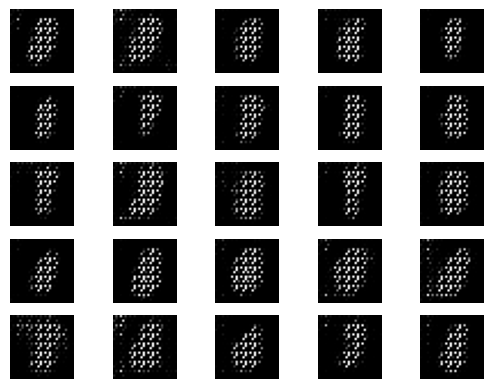

  0%|          | 0/750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 133ms/step


  0%|          | 1/750 [00:00<10:39,  1.17it/s]

1/1 [==============================] - 0s 136ms/step


  0%|          | 2/750 [00:01<10:41,  1.17it/s]

1/1 [==============================] - 0s 130ms/step


  0%|          | 3/750 [00:02<10:44,  1.16it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 4/750 [00:03<10:44,  1.16it/s]

1/1 [==============================] - 0s 136ms/step


  1%|          | 5/750 [00:04<10:46,  1.15it/s]

1/1 [==============================] - 0s 138ms/step


  1%|          | 6/750 [00:05<10:44,  1.15it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 7/750 [00:06<10:43,  1.15it/s]

1/1 [==============================] - 0s 185ms/step


  1%|          | 8/750 [00:07<12:54,  1.04s/it]

1/1 [==============================] - 0s 212ms/step


  1%|          | 9/750 [00:08<14:12,  1.15s/it]

1/1 [==============================] - 0s 203ms/step


  1%|▏         | 10/750 [00:10<14:58,  1.21s/it]

1/1 [==============================] - 0s 200ms/step


  1%|▏         | 11/750 [00:11<15:55,  1.29s/it]

1/1 [==============================] - 0s 213ms/step


  2%|▏         | 12/750 [00:13<16:11,  1.32s/it]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 13/750 [00:14<15:29,  1.26s/it]

1/1 [==============================] - 0s 129ms/step


  2%|▏         | 14/750 [00:15<14:02,  1.14s/it]

1/1 [==============================] - 0s 126ms/step


  2%|▏         | 15/750 [00:15<13:01,  1.06s/it]

1/1 [==============================] - 0s 127ms/step


  2%|▏         | 16/750 [00:16<12:14,  1.00s/it]

1/1 [==============================] - 0s 126ms/step


  2%|▏         | 17/750 [00:17<11:41,  1.05it/s]

1/1 [==============================] - 0s 129ms/step


  2%|▏         | 18/750 [00:18<11:18,  1.08it/s]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 19/750 [00:19<11:07,  1.10it/s]

1/1 [==============================] - 0s 132ms/step


  3%|▎         | 20/750 [00:20<10:56,  1.11it/s]

1/1 [==============================] - 0s 126ms/step


  3%|▎         | 21/750 [00:21<10:43,  1.13it/s]

1/1 [==============================] - 0s 131ms/step


  3%|▎         | 22/750 [00:21<10:37,  1.14it/s]

1/1 [==============================] - 0s 131ms/step


  3%|▎         | 23/750 [00:22<10:33,  1.15it/s]

1/1 [==============================] - 0s 128ms/step


  3%|▎         | 24/750 [00:23<10:42,  1.13it/s]

1/1 [==============================] - 0s 198ms/step


  3%|▎         | 25/750 [00:25<12:38,  1.05s/it]

1/1 [==============================] - 0s 218ms/step


  3%|▎         | 26/750 [00:26<14:20,  1.19s/it]

1/1 [==============================] - 0s 209ms/step


  4%|▎         | 27/750 [00:28<15:37,  1.30s/it]

1/1 [==============================] - 0s 225ms/step


  4%|▎         | 28/750 [00:29<16:18,  1.36s/it]

1/1 [==============================] - 0s 212ms/step


  4%|▍         | 29/750 [00:31<16:07,  1.34s/it]

1/1 [==============================] - 0s 124ms/step


  4%|▍         | 30/750 [00:31<14:23,  1.20s/it]

1/1 [==============================] - 0s 123ms/step


  4%|▍         | 31/750 [00:32<13:05,  1.09s/it]

1/1 [==============================] - 0s 129ms/step


  4%|▍         | 32/750 [00:33<12:15,  1.02s/it]

1/1 [==============================] - 0s 127ms/step


  4%|▍         | 33/750 [00:34<11:46,  1.01it/s]

1/1 [==============================] - 0s 139ms/step


  5%|▍         | 34/750 [00:35<11:19,  1.05it/s]

1/1 [==============================] - 0s 129ms/step


  5%|▍         | 35/750 [00:36<11:00,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


  5%|▍         | 36/750 [00:37<10:45,  1.11it/s]

1/1 [==============================] - 0s 133ms/step


  5%|▍         | 37/750 [00:37<10:39,  1.11it/s]

1/1 [==============================] - 0s 125ms/step


  5%|▌         | 38/750 [00:38<10:31,  1.13it/s]

1/1 [==============================] - 0s 132ms/step


  5%|▌         | 39/750 [00:39<10:25,  1.14it/s]

1/1 [==============================] - 0s 145ms/step


  5%|▌         | 40/750 [00:40<10:19,  1.15it/s]

1/1 [==============================] - 0s 130ms/step


  5%|▌         | 41/750 [00:41<11:48,  1.00it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 42/750 [00:43<13:24,  1.14s/it]

1/1 [==============================] - 0s 211ms/step


  6%|▌         | 43/750 [00:44<14:18,  1.21s/it]

1/1 [==============================] - 0s 210ms/step


  6%|▌         | 44/750 [00:46<14:52,  1.26s/it]

1/1 [==============================] - 0s 214ms/step


  6%|▌         | 45/750 [00:47<15:36,  1.33s/it]

1/1 [==============================] - 0s 217ms/step


  6%|▌         | 46/750 [00:48<15:19,  1.31s/it]

1/1 [==============================] - 0s 125ms/step


  6%|▋         | 47/750 [00:49<13:44,  1.17s/it]

1/1 [==============================] - 0s 128ms/step


  6%|▋         | 48/750 [00:50<12:40,  1.08s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 49/750 [00:51<11:56,  1.02s/it]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 50/750 [00:52<11:20,  1.03it/s]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 51/750 [00:53<10:56,  1.06it/s]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 52/750 [00:54<10:41,  1.09it/s]

1/1 [==============================] - 0s 137ms/step


  7%|▋         | 53/750 [00:54<10:31,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


  7%|▋         | 54/750 [00:55<10:20,  1.12it/s]

1/1 [==============================] - 0s 122ms/step


  7%|▋         | 55/750 [00:56<10:10,  1.14it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 56/750 [00:57<10:00,  1.16it/s]

1/1 [==============================] - 0s 130ms/step


  8%|▊         | 57/750 [00:58<09:57,  1.16it/s]

1/1 [==============================] - 0s 170ms/step


  8%|▊         | 58/750 [01:00<13:43,  1.19s/it]

1/1 [==============================] - 0s 217ms/step


  8%|▊         | 59/750 [01:01<14:23,  1.25s/it]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 60/750 [01:02<14:40,  1.28s/it]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 61/750 [01:04<15:05,  1.31s/it]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 62/750 [01:05<15:12,  1.33s/it]

1/1 [==============================] - 0s 134ms/step


  8%|▊         | 63/750 [01:06<13:36,  1.19s/it]

1/1 [==============================] - 0s 120ms/step


  9%|▊         | 64/750 [01:07<12:24,  1.09s/it]

1/1 [==============================] - 0s 128ms/step


  9%|▊         | 65/750 [01:08<11:38,  1.02s/it]

1/1 [==============================] - 0s 125ms/step


  9%|▉         | 66/750 [01:09<11:09,  1.02it/s]

1/1 [==============================] - 0s 126ms/step


  9%|▉         | 67/750 [01:10<10:47,  1.05it/s]

1/1 [==============================] - 0s 126ms/step


  9%|▉         | 68/750 [01:10<10:28,  1.09it/s]

1/1 [==============================] - 0s 129ms/step


  9%|▉         | 69/750 [01:11<10:11,  1.11it/s]

1/1 [==============================] - 0s 124ms/step


  9%|▉         | 70/750 [01:12<10:02,  1.13it/s]

1/1 [==============================] - 0s 129ms/step


  9%|▉         | 71/750 [01:13<09:56,  1.14it/s]

1/1 [==============================] - 0s 128ms/step


 10%|▉         | 72/750 [01:14<09:52,  1.14it/s]

1/1 [==============================] - 0s 117ms/step


 10%|▉         | 73/750 [01:15<09:46,  1.15it/s]

1/1 [==============================] - 0s 118ms/step


 10%|▉         | 74/750 [01:16<10:06,  1.11it/s]

1/1 [==============================] - 0s 212ms/step


 10%|█         | 75/750 [01:17<12:04,  1.07s/it]

1/1 [==============================] - 0s 197ms/step


 10%|█         | 76/750 [01:19<13:01,  1.16s/it]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 77/750 [01:20<13:37,  1.22s/it]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 78/750 [01:21<14:00,  1.25s/it]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 79/750 [01:23<14:23,  1.29s/it]

1/1 [==============================] - 0s 201ms/step


 11%|█         | 80/750 [01:24<13:35,  1.22s/it]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 81/750 [01:24<12:19,  1.10s/it]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 82/750 [01:25<11:23,  1.02s/it]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 83/750 [01:26<10:47,  1.03it/s]

1/1 [==============================] - 0s 130ms/step


 11%|█         | 84/750 [01:27<10:27,  1.06it/s]

1/1 [==============================] - 0s 127ms/step


 11%|█▏        | 85/750 [01:28<10:07,  1.09it/s]

1/1 [==============================] - 0s 129ms/step


 11%|█▏        | 86/750 [01:29<09:56,  1.11it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 87/750 [01:30<09:46,  1.13it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█▏        | 88/750 [01:30<09:42,  1.14it/s]

1/1 [==============================] - 0s 128ms/step


 12%|█▏        | 89/750 [01:31<09:35,  1.15it/s]

1/1 [==============================] - 0s 120ms/step


 12%|█▏        | 90/750 [01:32<09:31,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 12%|█▏        | 91/750 [01:33<09:28,  1.16it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 92/750 [01:35<11:32,  1.05s/it]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 93/750 [01:36<12:49,  1.17s/it]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 94/750 [01:37<13:47,  1.26s/it]

1/1 [==============================] - 0s 200ms/step


 13%|█▎        | 95/750 [01:39<14:06,  1.29s/it]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 96/750 [01:40<14:33,  1.34s/it]

1/1 [==============================] - 0s 156ms/step


 13%|█▎        | 97/750 [01:41<13:14,  1.22s/it]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 98/750 [01:42<12:00,  1.11s/it]

1/1 [==============================] - 0s 124ms/step


 13%|█▎        | 99/750 [01:43<11:15,  1.04s/it]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 100/750 [01:44<10:34,  1.02it/s]

1/1 [==============================] - 0s 133ms/step


 13%|█▎        | 101/750 [01:45<10:08,  1.07it/s]

1/1 [==============================] - 0s 132ms/step


 14%|█▎        | 102/750 [01:45<09:56,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█▎        | 103/750 [01:46<09:45,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 104/750 [01:47<09:35,  1.12it/s]

1/1 [==============================] - 0s 126ms/step


 14%|█▍        | 105/750 [01:48<09:29,  1.13it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█▍        | 106/750 [01:49<09:18,  1.15it/s]

1/1 [==============================] - 0s 127ms/step


 14%|█▍        | 107/750 [01:50<09:13,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 108/750 [01:51<09:24,  1.14it/s]

1/1 [==============================] - 0s 198ms/step


 15%|█▍        | 109/750 [01:52<11:12,  1.05s/it]

1/1 [==============================] - 0s 198ms/step


 15%|█▍        | 110/750 [01:54<13:43,  1.29s/it]

1/1 [==============================] - 0s 202ms/step


 15%|█▍        | 111/750 [01:55<14:12,  1.33s/it]

1/1 [==============================] - 0s 196ms/step


 15%|█▍        | 112/750 [01:57<14:40,  1.38s/it]

1/1 [==============================] - 0s 210ms/step


 15%|█▌        | 113/750 [01:58<14:54,  1.40s/it]

1/1 [==============================] - 0s 129ms/step


 15%|█▌        | 114/750 [01:59<13:06,  1.24s/it]

1/1 [==============================] - 0s 119ms/step


 15%|█▌        | 115/750 [02:00<11:50,  1.12s/it]

1/1 [==============================] - 0s 125ms/step


 15%|█▌        | 116/750 [02:01<10:56,  1.04s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█▌        | 117/750 [02:02<10:23,  1.01it/s]

1/1 [==============================] - 0s 118ms/step


 16%|█▌        | 118/750 [02:03<09:58,  1.06it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 119/750 [02:03<09:38,  1.09it/s]

1/1 [==============================] - 0s 132ms/step


 16%|█▌        | 120/750 [02:04<09:27,  1.11it/s]

1/1 [==============================] - 0s 117ms/step


 16%|█▌        | 121/750 [02:05<09:18,  1.13it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▋        | 122/750 [02:06<09:08,  1.14it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█▋        | 123/750 [02:07<09:05,  1.15it/s]

1/1 [==============================] - 0s 127ms/step


 17%|█▋        | 124/750 [02:08<09:01,  1.16it/s]

1/1 [==============================] - 0s 119ms/step


 17%|█▋        | 125/750 [02:09<09:29,  1.10it/s]

1/1 [==============================] - 0s 201ms/step


 17%|█▋        | 126/750 [02:10<11:07,  1.07s/it]

1/1 [==============================] - 0s 199ms/step


 17%|█▋        | 127/750 [02:12<12:05,  1.16s/it]

1/1 [==============================] - 0s 194ms/step


 17%|█▋        | 128/750 [02:13<12:47,  1.23s/it]

1/1 [==============================] - 0s 211ms/step


 17%|█▋        | 129/750 [02:14<13:14,  1.28s/it]

1/1 [==============================] - 0s 192ms/step


 17%|█▋        | 130/750 [02:16<13:34,  1.31s/it]

1/1 [==============================] - 0s 160ms/step


 17%|█▋        | 131/750 [02:17<12:18,  1.19s/it]

1/1 [==============================] - 0s 121ms/step


 18%|█▊        | 132/750 [02:17<11:13,  1.09s/it]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 133/750 [02:18<10:28,  1.02s/it]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 134/750 [02:19<09:58,  1.03it/s]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 135/750 [02:20<09:32,  1.07it/s]

1/1 [==============================] - 0s 128ms/step


 18%|█▊        | 136/750 [02:21<09:17,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 18%|█▊        | 137/750 [02:22<09:08,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 138/750 [02:23<09:02,  1.13it/s]

1/1 [==============================] - 0s 130ms/step


 19%|█▊        | 139/750 [02:23<08:56,  1.14it/s]

1/1 [==============================] - 0s 114ms/step


 19%|█▊        | 140/750 [02:24<08:50,  1.15it/s]

1/1 [==============================] - 0s 117ms/step


 19%|█▉        | 141/750 [02:25<08:44,  1.16it/s]

1/1 [==============================] - 0s 130ms/step


 19%|█▉        | 142/750 [02:26<08:49,  1.15it/s]

1/1 [==============================] - 0s 193ms/step


 19%|█▉        | 143/750 [02:27<10:23,  1.03s/it]

1/1 [==============================] - 0s 202ms/step


 19%|█▉        | 144/750 [02:29<11:37,  1.15s/it]

1/1 [==============================] - 0s 204ms/step


 19%|█▉        | 145/750 [02:30<12:39,  1.26s/it]

1/1 [==============================] - 0s 195ms/step


 19%|█▉        | 146/750 [02:32<12:48,  1.27s/it]

1/1 [==============================] - 0s 195ms/step


 20%|█▉        | 147/750 [02:33<13:21,  1.33s/it]

1/1 [==============================] - 0s 197ms/step


 20%|█▉        | 148/750 [02:34<12:20,  1.23s/it]

1/1 [==============================] - 0s 119ms/step


 20%|█▉        | 149/750 [02:35<11:08,  1.11s/it]

1/1 [==============================] - 0s 128ms/step


 20%|██        | 150/750 [02:36<10:23,  1.04s/it]

1/1 [==============================] - 0s 120ms/step


 20%|██        | 151/750 [02:37<09:52,  1.01it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 152/750 [02:38<09:24,  1.06it/s]

1/1 [==============================] - 0s 119ms/step


 20%|██        | 153/750 [02:38<09:06,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 21%|██        | 154/750 [02:39<08:55,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 21%|██        | 155/750 [02:40<08:47,  1.13it/s]

1/1 [==============================] - 0s 124ms/step


 21%|██        | 156/750 [02:41<08:42,  1.14it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 157/750 [02:42<08:33,  1.16it/s]

1/1 [==============================] - 0s 127ms/step


 21%|██        | 158/750 [02:43<08:30,  1.16it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 159/750 [02:44<08:34,  1.15it/s]

1/1 [==============================] - 0s 196ms/step


 21%|██▏       | 160/750 [02:45<10:15,  1.04s/it]

1/1 [==============================] - 0s 193ms/step


 21%|██▏       | 161/750 [02:46<11:18,  1.15s/it]

1/1 [==============================] - 0s 181ms/step


 22%|██▏       | 162/750 [02:48<11:54,  1.21s/it]

1/1 [==============================] - 0s 198ms/step


 22%|██▏       | 163/750 [02:49<12:27,  1.27s/it]

1/1 [==============================] - 0s 199ms/step


 22%|██▏       | 164/750 [02:51<13:08,  1.35s/it]

1/1 [==============================] - 0s 185ms/step


 22%|██▏       | 165/750 [02:52<11:55,  1.22s/it]

1/1 [==============================] - 0s 121ms/step


 22%|██▏       | 166/750 [02:53<10:49,  1.11s/it]

1/1 [==============================] - 0s 115ms/step


 22%|██▏       | 167/750 [02:53<10:03,  1.04s/it]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 168/750 [02:54<09:30,  1.02it/s]

1/1 [==============================] - 0s 129ms/step


 23%|██▎       | 169/750 [02:55<09:06,  1.06it/s]

1/1 [==============================] - 0s 119ms/step


 23%|██▎       | 170/750 [02:56<08:50,  1.09it/s]

1/1 [==============================] - 0s 126ms/step


 23%|██▎       | 171/750 [02:57<08:42,  1.11it/s]

1/1 [==============================] - 0s 126ms/step


 23%|██▎       | 172/750 [02:58<08:35,  1.12it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 173/750 [02:59<08:27,  1.14it/s]

1/1 [==============================] - 0s 121ms/step


 23%|██▎       | 174/750 [02:59<08:20,  1.15it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 175/750 [03:00<08:13,  1.16it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 176/750 [03:01<08:17,  1.15it/s]

1/1 [==============================] - 0s 193ms/step


 24%|██▎       | 177/750 [03:03<09:53,  1.04s/it]

1/1 [==============================] - 0s 208ms/step


 24%|██▎       | 178/750 [03:04<11:00,  1.15s/it]

1/1 [==============================] - 0s 192ms/step


 24%|██▍       | 179/750 [03:05<11:31,  1.21s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██▍       | 180/750 [03:07<12:00,  1.26s/it]

1/1 [==============================] - 0s 197ms/step


 24%|██▍       | 181/750 [03:08<12:13,  1.29s/it]

1/1 [==============================] - 0s 197ms/step


 24%|██▍       | 182/750 [03:09<11:35,  1.22s/it]

1/1 [==============================] - 0s 115ms/step


 24%|██▍       | 183/750 [03:10<10:26,  1.11s/it]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 184/750 [03:11<09:40,  1.03s/it]

1/1 [==============================] - 0s 117ms/step


 25%|██▍       | 185/750 [03:12<09:08,  1.03it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▍       | 186/750 [03:12<08:51,  1.06it/s]

1/1 [==============================] - 0s 124ms/step


 25%|██▍       | 187/750 [03:13<08:36,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 25%|██▌       | 188/750 [03:14<08:24,  1.11it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▌       | 189/750 [03:15<08:13,  1.14it/s]

1/1 [==============================] - 0s 131ms/step


 25%|██▌       | 190/750 [03:16<08:07,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 191/750 [03:17<08:03,  1.16it/s]

1/1 [==============================] - 0s 116ms/step


 26%|██▌       | 192/750 [03:18<07:58,  1.17it/s]

1/1 [==============================] - 0s 122ms/step


 26%|██▌       | 193/750 [03:18<07:56,  1.17it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 194/750 [03:20<09:02,  1.02it/s]

1/1 [==============================] - 0s 191ms/step


 26%|██▌       | 195/750 [03:21<10:12,  1.10s/it]

1/1 [==============================] - 0s 200ms/step


 26%|██▌       | 196/750 [03:22<10:57,  1.19s/it]

1/1 [==============================] - 0s 190ms/step


 26%|██▋       | 197/750 [03:24<11:43,  1.27s/it]

1/1 [==============================] - 0s 191ms/step


 26%|██▋       | 198/750 [03:25<12:02,  1.31s/it]

1/1 [==============================] - 0s 184ms/step


 27%|██▋       | 199/750 [03:26<11:34,  1.26s/it]

1/1 [==============================] - 0s 123ms/step


 27%|██▋       | 200/750 [03:27<10:26,  1.14s/it]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 201/750 [03:28<09:36,  1.05s/it]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 202/750 [03:29<09:03,  1.01it/s]

1/1 [==============================] - 0s 128ms/step


 27%|██▋       | 203/750 [03:30<08:39,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 204/750 [03:31<08:22,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 205/750 [03:32<08:09,  1.11it/s]

1/1 [==============================] - 0s 132ms/step


 27%|██▋       | 206/750 [03:32<08:02,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 207/750 [03:33<07:57,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 208/750 [03:34<07:52,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 209/750 [03:35<07:51,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 210/750 [03:36<07:46,  1.16it/s]

1/1 [==============================] - 0s 159ms/step


 28%|██▊       | 211/750 [03:37<09:05,  1.01s/it]

1/1 [==============================] - 0s 186ms/step


 28%|██▊       | 212/750 [03:39<09:57,  1.11s/it]

1/1 [==============================] - 0s 193ms/step


 28%|██▊       | 213/750 [03:40<10:32,  1.18s/it]

1/1 [==============================] - 0s 200ms/step


 29%|██▊       | 214/750 [03:41<11:02,  1.24s/it]

1/1 [==============================] - 0s 191ms/step


 29%|██▊       | 215/750 [03:43<11:34,  1.30s/it]

1/1 [==============================] - 0s 192ms/step


 29%|██▉       | 216/750 [03:44<11:17,  1.27s/it]

1/1 [==============================] - 0s 128ms/step


 29%|██▉       | 217/750 [03:45<10:10,  1.14s/it]

1/1 [==============================] - 0s 117ms/step


 29%|██▉       | 218/750 [03:46<09:20,  1.05s/it]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 219/750 [03:46<08:45,  1.01it/s]

1/1 [==============================] - 0s 115ms/step


 29%|██▉       | 220/750 [03:47<08:21,  1.06it/s]

1/1 [==============================] - 0s 126ms/step


 29%|██▉       | 221/750 [03:48<08:03,  1.09it/s]

1/1 [==============================] - 0s 131ms/step


 30%|██▉       | 222/750 [03:49<07:52,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 30%|██▉       | 223/750 [03:50<07:42,  1.14it/s]

1/1 [==============================] - 0s 122ms/step


 30%|██▉       | 224/750 [03:51<07:38,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 30%|███       | 225/750 [03:52<07:33,  1.16it/s]

1/1 [==============================] - 0s 126ms/step


 30%|███       | 226/750 [03:52<07:31,  1.16it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 227/750 [03:53<07:27,  1.17it/s]

1/1 [==============================] - 0s 127ms/step


 30%|███       | 228/750 [03:54<08:13,  1.06it/s]

1/1 [==============================] - 0s 198ms/step


 31%|███       | 229/750 [03:56<09:35,  1.10s/it]

1/1 [==============================] - 0s 198ms/step


 31%|███       | 230/750 [03:57<10:34,  1.22s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███       | 231/750 [03:59<11:18,  1.31s/it]

1/1 [==============================] - 0s 202ms/step


 31%|███       | 232/750 [04:00<11:33,  1.34s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███       | 233/750 [04:01<10:55,  1.27s/it]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 234/750 [04:02<09:48,  1.14s/it]

1/1 [==============================] - 0s 116ms/step


 31%|███▏      | 235/750 [04:03<09:01,  1.05s/it]

1/1 [==============================] - 0s 121ms/step


 31%|███▏      | 236/750 [04:04<08:28,  1.01it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 237/750 [04:05<08:06,  1.06it/s]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 238/750 [04:06<07:51,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 239/750 [04:06<07:37,  1.12it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 240/750 [04:07<07:28,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 241/750 [04:08<07:27,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 242/750 [04:09<07:20,  1.15it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 243/750 [04:10<07:17,  1.16it/s]

1/1 [==============================] - 0s 130ms/step


 33%|███▎      | 244/750 [04:11<07:12,  1.17it/s]

1/1 [==============================] - 0s 166ms/step


 33%|███▎      | 245/750 [04:12<08:31,  1.01s/it]

1/1 [==============================] - 0s 194ms/step


 33%|███▎      | 246/750 [04:14<09:33,  1.14s/it]

1/1 [==============================] - 0s 205ms/step


 33%|███▎      | 247/750 [04:15<10:24,  1.24s/it]

1/1 [==============================] - 0s 201ms/step


 33%|███▎      | 248/750 [04:16<11:02,  1.32s/it]

1/1 [==============================] - 0s 185ms/step


 33%|███▎      | 249/750 [04:18<11:09,  1.34s/it]

1/1 [==============================] - 0s 202ms/step


 33%|███▎      | 250/750 [04:19<10:15,  1.23s/it]

1/1 [==============================] - 0s 119ms/step


 33%|███▎      | 251/750 [04:20<09:16,  1.12s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 252/750 [04:21<08:35,  1.04s/it]

1/1 [==============================] - 0s 129ms/step


 34%|███▎      | 253/750 [04:21<08:04,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 254/750 [04:22<07:43,  1.07it/s]

1/1 [==============================] - 0s 114ms/step


 34%|███▍      | 255/750 [04:23<07:30,  1.10it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 256/750 [04:24<07:21,  1.12it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 257/750 [04:25<07:13,  1.14it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 258/750 [04:26<07:07,  1.15it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▍      | 259/750 [04:26<07:03,  1.16it/s]

1/1 [==============================] - 0s 131ms/step


 35%|███▍      | 260/750 [04:27<06:59,  1.17it/s]

1/1 [==============================] - 0s 117ms/step


 35%|███▍      | 261/750 [04:28<07:00,  1.16it/s]

1/1 [==============================] - 0s 194ms/step


 35%|███▍      | 262/750 [04:30<08:22,  1.03s/it]

1/1 [==============================] - 0s 199ms/step


 35%|███▌      | 263/750 [04:31<09:21,  1.15s/it]

1/1 [==============================] - 0s 202ms/step


 35%|███▌      | 264/750 [04:32<09:55,  1.23s/it]

1/1 [==============================] - 0s 191ms/step


 35%|███▌      | 265/750 [04:34<10:18,  1.28s/it]

1/1 [==============================] - 0s 192ms/step


 35%|███▌      | 266/750 [04:35<10:24,  1.29s/it]

1/1 [==============================] - 0s 187ms/step


 36%|███▌      | 267/750 [04:36<09:49,  1.22s/it]

1/1 [==============================] - 0s 128ms/step


 36%|███▌      | 268/750 [04:37<08:57,  1.11s/it]

1/1 [==============================] - 0s 120ms/step


 36%|███▌      | 269/750 [04:38<08:18,  1.04s/it]

1/1 [==============================] - 0s 140ms/step


 36%|███▌      | 270/750 [04:39<07:50,  1.02it/s]

1/1 [==============================] - 0s 115ms/step


 36%|███▌      | 271/750 [04:40<07:29,  1.07it/s]

1/1 [==============================] - 0s 123ms/step


 36%|███▋      | 272/750 [04:40<07:14,  1.10it/s]

1/1 [==============================] - 0s 119ms/step


 36%|███▋      | 273/750 [04:41<07:03,  1.13it/s]

1/1 [==============================] - 0s 117ms/step


 37%|███▋      | 274/750 [04:42<06:57,  1.14it/s]

1/1 [==============================] - 0s 118ms/step


 37%|███▋      | 275/750 [04:43<06:52,  1.15it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 276/750 [04:44<06:52,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 37%|███▋      | 277/750 [04:45<06:47,  1.16it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 278/750 [04:46<06:46,  1.16it/s]

1/1 [==============================] - 0s 122ms/step


 37%|███▋      | 279/750 [04:47<07:47,  1.01it/s]

1/1 [==============================] - 0s 197ms/step


 37%|███▋      | 280/750 [04:48<08:57,  1.14s/it]

1/1 [==============================] - 0s 187ms/step


 37%|███▋      | 281/750 [04:50<09:43,  1.24s/it]

1/1 [==============================] - 0s 198ms/step


 38%|███▊      | 282/750 [04:51<10:00,  1.28s/it]

1/1 [==============================] - 0s 196ms/step


 38%|███▊      | 283/750 [04:53<10:11,  1.31s/it]

1/1 [==============================] - 0s 192ms/step


 38%|███▊      | 284/750 [04:54<09:34,  1.23s/it]

1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 285/750 [04:55<08:39,  1.12s/it]

1/1 [==============================] - 0s 125ms/step


 38%|███▊      | 286/750 [04:55<08:00,  1.03s/it]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 287/750 [04:56<07:32,  1.02it/s]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 288/750 [04:57<07:13,  1.07it/s]

1/1 [==============================] - 0s 136ms/step


 39%|███▊      | 289/750 [04:58<07:00,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▊      | 290/750 [04:59<06:47,  1.13it/s]

1/1 [==============================] - 0s 116ms/step


 39%|███▉      | 291/750 [05:00<06:41,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 39%|███▉      | 292/750 [05:00<06:37,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▉      | 293/750 [05:01<06:36,  1.15it/s]

1/1 [==============================] - 0s 117ms/step


 39%|███▉      | 294/750 [05:02<06:34,  1.15it/s]

1/1 [==============================] - 0s 120ms/step


 39%|███▉      | 295/750 [05:03<06:30,  1.17it/s]

1/1 [==============================] - 0s 127ms/step


 39%|███▉      | 296/750 [05:04<07:32,  1.00it/s]

1/1 [==============================] - 0s 194ms/step


 40%|███▉      | 297/750 [05:06<08:29,  1.12s/it]

1/1 [==============================] - 0s 197ms/step


 40%|███▉      | 298/750 [05:07<09:13,  1.22s/it]

1/1 [==============================] - 0s 202ms/step


 40%|███▉      | 299/750 [05:09<09:45,  1.30s/it]

1/1 [==============================] - 0s 186ms/step


 40%|████      | 300/750 [05:10<10:11,  1.36s/it]

1/1 [==============================] - 0s 202ms/step


 40%|████      | 301/750 [05:11<09:22,  1.25s/it]

1/1 [==============================] - 0s 135ms/step


 40%|████      | 302/750 [05:12<08:26,  1.13s/it]

1/1 [==============================] - 0s 122ms/step


 40%|████      | 303/750 [05:13<07:49,  1.05s/it]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 304/750 [05:14<07:20,  1.01it/s]

1/1 [==============================] - 0s 120ms/step


 41%|████      | 305/750 [05:15<06:59,  1.06it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████      | 306/750 [05:15<06:44,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 307/750 [05:16<06:34,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 308/750 [05:17<06:28,  1.14it/s]

1/1 [==============================] - 0s 120ms/step


 41%|████      | 309/750 [05:18<06:23,  1.15it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████▏     | 310/750 [05:19<06:21,  1.15it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████▏     | 311/750 [05:20<06:20,  1.15it/s]

1/1 [==============================] - 0s 127ms/step


 42%|████▏     | 312/750 [05:20<06:15,  1.17it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████▏     | 313/750 [05:22<08:37,  1.18s/it]

1/1 [==============================] - 0s 192ms/step


 42%|████▏     | 314/750 [05:24<08:57,  1.23s/it]

1/1 [==============================] - 0s 196ms/step


 42%|████▏     | 315/750 [05:25<09:13,  1.27s/it]

1/1 [==============================] - 0s 188ms/step


 42%|████▏     | 316/750 [05:26<09:18,  1.29s/it]

1/1 [==============================] - 0s 191ms/step


 42%|████▏     | 317/750 [05:28<09:23,  1.30s/it]

1/1 [==============================] - 0s 117ms/step


 42%|████▏     | 318/750 [05:29<08:22,  1.16s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 319/750 [05:30<07:41,  1.07s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 320/750 [05:30<07:12,  1.01s/it]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 321/750 [05:31<06:53,  1.04it/s]

1/1 [==============================] - 0s 118ms/step


 43%|████▎     | 322/750 [05:32<06:38,  1.07it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 323/750 [05:33<06:25,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 324/750 [05:34<06:18,  1.13it/s]

1/1 [==============================] - 0s 116ms/step


 43%|████▎     | 325/750 [05:35<06:11,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 326/750 [05:35<06:10,  1.15it/s]

1/1 [==============================] - 0s 116ms/step


 44%|████▎     | 327/750 [05:36<06:08,  1.15it/s]

1/1 [==============================] - 0s 117ms/step


 44%|████▎     | 328/750 [05:37<06:03,  1.16it/s]

1/1 [==============================] - 0s 117ms/step


 44%|████▍     | 329/750 [05:38<06:38,  1.06it/s]

1/1 [==============================] - 0s 207ms/step


 44%|████▍     | 330/750 [05:40<07:40,  1.10s/it]

1/1 [==============================] - 0s 196ms/step


 44%|████▍     | 331/750 [05:41<08:14,  1.18s/it]

1/1 [==============================] - 0s 187ms/step


 44%|████▍     | 332/750 [05:42<08:29,  1.22s/it]

1/1 [==============================] - 0s 192ms/step


 44%|████▍     | 333/750 [05:44<08:45,  1.26s/it]

1/1 [==============================] - 0s 192ms/step


 45%|████▍     | 334/750 [05:45<08:57,  1.29s/it]

1/1 [==============================] - 0s 124ms/step


 45%|████▍     | 335/750 [05:46<08:02,  1.16s/it]

1/1 [==============================] - 0s 120ms/step


 45%|████▍     | 336/750 [05:47<07:22,  1.07s/it]

1/1 [==============================] - 0s 125ms/step


 45%|████▍     | 337/750 [05:48<06:55,  1.01s/it]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 338/750 [05:49<06:35,  1.04it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▌     | 339/750 [05:49<06:19,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


 45%|████▌     | 340/750 [05:50<06:08,  1.11it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▌     | 341/750 [05:51<06:03,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 342/750 [05:52<05:57,  1.14it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 343/750 [05:53<05:53,  1.15it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 344/750 [05:54<05:47,  1.17it/s]

1/1 [==============================] - 0s 125ms/step


 46%|████▌     | 345/750 [05:55<05:46,  1.17it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 346/750 [05:56<06:01,  1.12it/s]

1/1 [==============================] - 0s 197ms/step


 46%|████▋     | 347/750 [05:57<07:04,  1.05s/it]

1/1 [==============================] - 0s 192ms/step


 46%|████▋     | 348/750 [05:58<07:42,  1.15s/it]

1/1 [==============================] - 0s 196ms/step


 47%|████▋     | 349/750 [06:00<08:07,  1.21s/it]

1/1 [==============================] - 0s 195ms/step


 47%|████▋     | 350/750 [06:01<08:25,  1.26s/it]

1/1 [==============================] - 0s 192ms/step


 47%|████▋     | 351/750 [06:02<08:44,  1.31s/it]

1/1 [==============================] - 0s 195ms/step


 47%|████▋     | 352/750 [06:04<08:08,  1.23s/it]

1/1 [==============================] - 0s 117ms/step


 47%|████▋     | 353/750 [06:04<07:21,  1.11s/it]

1/1 [==============================] - 0s 117ms/step


 47%|████▋     | 354/750 [06:05<06:49,  1.03s/it]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 355/750 [06:06<06:28,  1.02it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 356/750 [06:07<06:11,  1.06it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 357/750 [06:08<05:59,  1.09it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 358/750 [06:09<05:49,  1.12it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 359/750 [06:09<05:46,  1.13it/s]

1/1 [==============================] - 0s 128ms/step


 48%|████▊     | 360/750 [06:10<05:38,  1.15it/s]

1/1 [==============================] - 0s 133ms/step


 48%|████▊     | 361/750 [06:11<05:36,  1.16it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 362/750 [06:12<05:34,  1.16it/s]

1/1 [==============================] - 0s 133ms/step


 48%|████▊     | 363/750 [06:13<05:36,  1.15it/s]

1/1 [==============================] - 0s 190ms/step


 49%|████▊     | 364/750 [06:14<06:42,  1.04s/it]

1/1 [==============================] - 0s 201ms/step


 49%|████▊     | 365/750 [06:16<07:35,  1.18s/it]

1/1 [==============================] - 0s 198ms/step


 49%|████▉     | 366/750 [06:17<08:00,  1.25s/it]

1/1 [==============================] - 0s 190ms/step


 49%|████▉     | 367/750 [06:19<08:18,  1.30s/it]

1/1 [==============================] - 0s 189ms/step


 49%|████▉     | 368/750 [06:20<08:23,  1.32s/it]

1/1 [==============================] - 0s 184ms/step


 49%|████▉     | 369/750 [06:21<07:40,  1.21s/it]

1/1 [==============================] - 0s 119ms/step


 49%|████▉     | 370/750 [06:22<06:57,  1.10s/it]

1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 371/750 [06:23<06:59,  1.11s/it]

1/1 [==============================] - 0s 140ms/step


 50%|████▉     | 372/750 [06:24<07:07,  1.13s/it]

1/1 [==============================] - 0s 138ms/step


 50%|████▉     | 373/750 [06:25<07:09,  1.14s/it]

1/1 [==============================] - 0s 142ms/step


 50%|████▉     | 374/750 [06:27<07:13,  1.15s/it]

1/1 [==============================] - 0s 145ms/step


 50%|█████     | 375/750 [06:28<07:06,  1.14s/it]

1/1 [==============================] - 0s 136ms/step


 50%|█████     | 376/750 [06:29<07:08,  1.14s/it]

1/1 [==============================] - 0s 180ms/step


 50%|█████     | 377/750 [06:30<07:08,  1.15s/it]

1/1 [==============================] - 0s 122ms/step


 50%|█████     | 378/750 [06:32<08:08,  1.31s/it]

1/1 [==============================] - 0s 321ms/step


 51%|█████     | 379/750 [06:33<08:52,  1.44s/it]

1/1 [==============================] - 0s 198ms/step


 51%|█████     | 380/750 [06:35<08:43,  1.41s/it]

1/1 [==============================] - 0s 174ms/step


 51%|█████     | 381/750 [06:36<08:25,  1.37s/it]

1/1 [==============================] - 0s 206ms/step


 51%|█████     | 382/750 [06:37<08:26,  1.38s/it]

1/1 [==============================] - 0s 196ms/step


 51%|█████     | 383/750 [06:39<08:22,  1.37s/it]

1/1 [==============================] - 0s 189ms/step


 51%|█████     | 384/750 [06:40<07:57,  1.30s/it]

1/1 [==============================] - 0s 124ms/step


 51%|█████▏    | 385/750 [06:41<07:06,  1.17s/it]

1/1 [==============================] - 0s 129ms/step


 51%|█████▏    | 386/750 [06:42<06:29,  1.07s/it]

1/1 [==============================] - 0s 121ms/step


 52%|█████▏    | 387/750 [06:42<06:05,  1.01s/it]

1/1 [==============================] - 0s 119ms/step


 52%|█████▏    | 388/750 [06:43<05:47,  1.04it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 389/750 [06:44<05:33,  1.08it/s]

1/1 [==============================] - 0s 122ms/step


 52%|█████▏    | 390/750 [06:45<05:26,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 52%|█████▏    | 391/750 [06:46<05:16,  1.13it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████▏    | 392/750 [06:47<05:10,  1.15it/s]

1/1 [==============================] - 0s 116ms/step


 52%|█████▏    | 393/750 [06:47<05:06,  1.16it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████▎    | 394/750 [06:48<05:03,  1.17it/s]

1/1 [==============================] - 0s 115ms/step


 53%|█████▎    | 395/750 [06:49<05:03,  1.17it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████▎    | 396/750 [06:50<05:41,  1.04it/s]

1/1 [==============================] - 0s 188ms/step


 53%|█████▎    | 397/750 [06:52<06:40,  1.13s/it]

1/1 [==============================] - 0s 196ms/step


 53%|█████▎    | 398/750 [06:53<07:01,  1.20s/it]

1/1 [==============================] - 0s 189ms/step


 53%|█████▎    | 399/750 [06:55<07:15,  1.24s/it]

1/1 [==============================] - 0s 195ms/step


 53%|█████▎    | 400/750 [06:56<07:39,  1.31s/it]

1/1 [==============================] - 0s 195ms/step


 53%|█████▎    | 401/750 [06:57<07:23,  1.27s/it]

1/1 [==============================] - 0s 131ms/step


 54%|█████▎    | 402/750 [06:58<06:38,  1.15s/it]

1/1 [==============================] - 0s 126ms/step


 54%|█████▎    | 403/750 [06:59<06:06,  1.06s/it]

1/1 [==============================] - 0s 120ms/step


 54%|█████▍    | 404/750 [07:00<05:42,  1.01it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████▍    | 405/750 [07:01<05:28,  1.05it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████▍    | 406/750 [07:02<05:17,  1.08it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▍    | 407/750 [07:02<05:08,  1.11it/s]

1/1 [==============================] - 0s 131ms/step


 54%|█████▍    | 408/750 [07:03<05:01,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 55%|█████▍    | 409/750 [07:04<04:57,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 55%|█████▍    | 410/750 [07:05<04:55,  1.15it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████▍    | 411/750 [07:06<04:52,  1.16it/s]

1/1 [==============================] - 0s 119ms/step


 55%|█████▍    | 412/750 [07:07<04:49,  1.17it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████▌    | 413/750 [07:08<05:27,  1.03it/s]

1/1 [==============================] - 0s 200ms/step


 55%|█████▌    | 414/750 [07:09<06:25,  1.15s/it]

1/1 [==============================] - 0s 190ms/step


 55%|█████▌    | 415/750 [07:11<06:39,  1.19s/it]

1/1 [==============================] - 0s 187ms/step


 55%|█████▌    | 416/750 [07:12<06:51,  1.23s/it]

1/1 [==============================] - 0s 187ms/step


 56%|█████▌    | 417/750 [07:13<07:02,  1.27s/it]

1/1 [==============================] - 0s 181ms/step


 56%|█████▌    | 418/750 [07:15<07:03,  1.27s/it]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 419/750 [07:16<06:20,  1.15s/it]

1/1 [==============================] - 0s 114ms/step


 56%|█████▌    | 420/750 [07:16<05:48,  1.06s/it]

1/1 [==============================] - 0s 115ms/step


 56%|█████▌    | 421/750 [07:17<05:26,  1.01it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▋    | 422/750 [07:18<05:11,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▋    | 423/750 [07:19<04:59,  1.09it/s]

1/1 [==============================] - 0s 116ms/step


 57%|█████▋    | 424/750 [07:20<04:50,  1.12it/s]

1/1 [==============================] - 0s 118ms/step


 57%|█████▋    | 425/750 [07:21<04:45,  1.14it/s]

1/1 [==============================] - 0s 129ms/step


 57%|█████▋    | 426/750 [07:21<04:42,  1.15it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 427/750 [07:22<04:40,  1.15it/s]

1/1 [==============================] - 0s 126ms/step


 57%|█████▋    | 428/750 [07:23<04:37,  1.16it/s]

1/1 [==============================] - 0s 127ms/step


 57%|█████▋    | 429/750 [07:24<04:35,  1.17it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 430/750 [07:25<04:52,  1.09it/s]

1/1 [==============================] - 0s 197ms/step


 57%|█████▋    | 431/750 [07:26<05:41,  1.07s/it]

1/1 [==============================] - 0s 195ms/step


 58%|█████▊    | 432/750 [07:28<06:11,  1.17s/it]

1/1 [==============================] - 0s 196ms/step


 58%|█████▊    | 433/750 [07:29<06:29,  1.23s/it]

1/1 [==============================] - 0s 199ms/step


 58%|█████▊    | 434/750 [07:31<06:52,  1.31s/it]

1/1 [==============================] - 0s 189ms/step


 58%|█████▊    | 435/750 [07:32<06:57,  1.33s/it]

1/1 [==============================] - 0s 132ms/step


 58%|█████▊    | 436/750 [07:33<06:13,  1.19s/it]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 437/750 [07:34<05:41,  1.09s/it]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 438/750 [07:35<05:16,  1.01s/it]

1/1 [==============================] - 0s 122ms/step


 59%|█████▊    | 439/750 [07:36<05:02,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 59%|█████▊    | 440/750 [07:36<04:50,  1.07it/s]

1/1 [==============================] - 0s 119ms/step


 59%|█████▉    | 441/750 [07:37<04:41,  1.10it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████▉    | 442/750 [07:38<04:36,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 443/750 [07:39<04:33,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 444/750 [07:40<04:28,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 445/750 [07:41<04:25,  1.15it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████▉    | 446/750 [07:42<04:24,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 60%|█████▉    | 447/750 [07:43<04:37,  1.09it/s]

1/1 [==============================] - 0s 199ms/step


 60%|█████▉    | 448/750 [07:44<05:37,  1.12s/it]

1/1 [==============================] - 0s 190ms/step


 60%|█████▉    | 449/750 [07:46<06:02,  1.20s/it]

1/1 [==============================] - 0s 204ms/step


 60%|██████    | 450/750 [07:47<06:20,  1.27s/it]

1/1 [==============================] - 0s 213ms/step


 60%|██████    | 451/750 [07:48<06:35,  1.32s/it]

1/1 [==============================] - 0s 196ms/step


 60%|██████    | 452/750 [07:50<06:22,  1.28s/it]

1/1 [==============================] - 0s 117ms/step


 60%|██████    | 453/750 [07:50<05:42,  1.15s/it]

1/1 [==============================] - 0s 116ms/step


 61%|██████    | 454/750 [07:51<05:14,  1.06s/it]

1/1 [==============================] - 0s 121ms/step


 61%|██████    | 455/750 [07:52<04:54,  1.00it/s]

1/1 [==============================] - 0s 135ms/step


 61%|██████    | 456/750 [07:53<04:42,  1.04it/s]

1/1 [==============================] - 0s 118ms/step


 61%|██████    | 457/750 [07:54<04:32,  1.08it/s]

1/1 [==============================] - 0s 117ms/step


 61%|██████    | 458/750 [07:55<04:25,  1.10it/s]

1/1 [==============================] - 0s 117ms/step


 61%|██████    | 459/750 [07:56<04:20,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████▏   | 460/750 [07:57<04:17,  1.13it/s]

1/1 [==============================] - 0s 117ms/step


 61%|██████▏   | 461/750 [07:57<04:13,  1.14it/s]

1/1 [==============================] - 0s 129ms/step


 62%|██████▏   | 462/750 [07:58<04:11,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 62%|██████▏   | 463/750 [07:59<04:08,  1.15it/s]

1/1 [==============================] - 0s 114ms/step


 62%|██████▏   | 464/750 [08:00<04:42,  1.01it/s]

1/1 [==============================] - 0s 197ms/step


 62%|██████▏   | 465/750 [08:02<05:17,  1.12s/it]

1/1 [==============================] - 0s 207ms/step


 62%|██████▏   | 466/750 [08:03<05:42,  1.21s/it]

1/1 [==============================] - 0s 190ms/step


 62%|██████▏   | 467/750 [08:05<05:58,  1.27s/it]

1/1 [==============================] - 0s 213ms/step


 62%|██████▏   | 468/750 [08:06<06:09,  1.31s/it]

1/1 [==============================] - 0s 202ms/step


 63%|██████▎   | 469/750 [08:07<06:01,  1.29s/it]

1/1 [==============================] - 0s 118ms/step


 63%|██████▎   | 470/750 [08:08<05:22,  1.15s/it]

1/1 [==============================] - 0s 119ms/step


 63%|██████▎   | 471/750 [08:09<04:56,  1.06s/it]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 472/750 [08:10<04:37,  1.00it/s]

1/1 [==============================] - 0s 131ms/step


 63%|██████▎   | 473/750 [08:11<04:25,  1.04it/s]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 474/750 [08:11<04:15,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 475/750 [08:12<04:08,  1.11it/s]

1/1 [==============================] - 0s 118ms/step


 63%|██████▎   | 476/750 [08:13<04:03,  1.12it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▎   | 477/750 [08:14<04:01,  1.13it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▎   | 478/750 [08:15<03:58,  1.14it/s]

1/1 [==============================] - 0s 135ms/step


 64%|██████▍   | 479/750 [08:16<03:56,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████▍   | 480/750 [08:17<03:54,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████▍   | 481/750 [08:18<04:25,  1.01it/s]

1/1 [==============================] - 0s 206ms/step


 64%|██████▍   | 482/750 [08:19<05:01,  1.12s/it]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 483/750 [08:21<05:19,  1.20s/it]

1/1 [==============================] - 0s 195ms/step


 65%|██████▍   | 484/750 [08:22<05:32,  1.25s/it]

1/1 [==============================] - 0s 191ms/step


 65%|██████▍   | 485/750 [08:24<05:50,  1.32s/it]

1/1 [==============================] - 0s 189ms/step


 65%|██████▍   | 486/750 [08:25<05:39,  1.29s/it]

1/1 [==============================] - 0s 121ms/step


 65%|██████▍   | 487/750 [08:26<05:04,  1.16s/it]

1/1 [==============================] - 0s 126ms/step


 65%|██████▌   | 488/750 [08:26<04:38,  1.06s/it]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 489/750 [08:27<04:21,  1.00s/it]

1/1 [==============================] - 0s 116ms/step


 65%|██████▌   | 490/750 [08:28<04:09,  1.04it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████▌   | 491/750 [08:29<04:00,  1.08it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 492/750 [08:30<03:56,  1.09it/s]

1/1 [==============================] - 0s 127ms/step


 66%|██████▌   | 493/750 [08:31<03:50,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 66%|██████▌   | 494/750 [08:32<03:46,  1.13it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 495/750 [08:33<03:44,  1.14it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 496/750 [08:33<03:42,  1.14it/s]

1/1 [==============================] - 0s 120ms/step


 66%|██████▋   | 497/750 [08:34<03:41,  1.14it/s]

1/1 [==============================] - 0s 130ms/step


 66%|██████▋   | 498/750 [08:36<04:12,  1.00s/it]

1/1 [==============================] - 0s 199ms/step


 67%|██████▋   | 499/750 [08:37<04:46,  1.14s/it]

1/1 [==============================] - 0s 198ms/step


 67%|██████▋   | 500/750 [08:38<05:03,  1.21s/it]

1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 501/750 [08:40<05:15,  1.27s/it]

1/1 [==============================] - 0s 206ms/step


 67%|██████▋   | 502/750 [08:41<05:26,  1.32s/it]

1/1 [==============================] - 0s 198ms/step


 67%|██████▋   | 503/750 [08:42<05:21,  1.30s/it]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 504/750 [08:43<04:49,  1.18s/it]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 505/750 [08:44<04:24,  1.08s/it]

1/1 [==============================] - 0s 119ms/step


 67%|██████▋   | 506/750 [08:45<04:08,  1.02s/it]

1/1 [==============================] - 0s 123ms/step


 68%|██████▊   | 507/750 [08:46<03:56,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 68%|██████▊   | 508/750 [08:47<03:46,  1.07it/s]

1/1 [==============================] - 0s 127ms/step


 68%|██████▊   | 509/750 [08:48<03:42,  1.08it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████▊   | 510/750 [08:49<03:37,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 68%|██████▊   | 511/750 [08:49<03:32,  1.12it/s]

1/1 [==============================] - 0s 121ms/step


 68%|██████▊   | 512/750 [08:50<03:30,  1.13it/s]

1/1 [==============================] - 0s 138ms/step


 68%|██████▊   | 513/750 [08:51<03:28,  1.14it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▊   | 514/750 [08:52<03:26,  1.14it/s]

1/1 [==============================] - 0s 195ms/step


 69%|██████▊   | 515/750 [08:53<04:05,  1.05s/it]

1/1 [==============================] - 0s 217ms/step


 69%|██████▉   | 516/750 [08:55<04:41,  1.20s/it]

1/1 [==============================] - 0s 195ms/step


 69%|██████▉   | 517/750 [08:56<04:53,  1.26s/it]

1/1 [==============================] - 0s 195ms/step


 69%|██████▉   | 518/750 [08:58<05:02,  1.30s/it]

1/1 [==============================] - 0s 205ms/step


 69%|██████▉   | 519/750 [08:59<05:06,  1.33s/it]

1/1 [==============================] - 0s 191ms/step


 69%|██████▉   | 520/750 [09:00<04:42,  1.23s/it]

1/1 [==============================] - 0s 125ms/step


 69%|██████▉   | 521/750 [09:01<04:17,  1.13s/it]

1/1 [==============================] - 0s 127ms/step


 70%|██████▉   | 522/750 [09:02<03:59,  1.05s/it]

1/1 [==============================] - 0s 120ms/step


 70%|██████▉   | 523/750 [09:03<03:43,  1.01it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████▉   | 524/750 [09:04<03:33,  1.06it/s]

1/1 [==============================] - 0s 122ms/step


 70%|███████   | 525/750 [09:05<03:27,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████   | 526/750 [09:05<03:23,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 70%|███████   | 527/750 [09:06<03:19,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 70%|███████   | 528/750 [09:07<03:17,  1.13it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████   | 529/750 [09:08<03:13,  1.14it/s]

1/1 [==============================] - 0s 133ms/step


 71%|███████   | 530/750 [09:09<03:11,  1.15it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████   | 531/750 [09:10<03:13,  1.13it/s]

1/1 [==============================] - 0s 197ms/step


 71%|███████   | 532/750 [09:11<03:55,  1.08s/it]

1/1 [==============================] - 0s 191ms/step


 71%|███████   | 533/750 [09:13<04:13,  1.17s/it]

1/1 [==============================] - 0s 195ms/step


 71%|███████   | 534/750 [09:14<04:29,  1.25s/it]

1/1 [==============================] - 0s 194ms/step


 71%|███████▏  | 535/750 [09:16<04:45,  1.33s/it]

1/1 [==============================] - 0s 197ms/step


 71%|███████▏  | 536/750 [09:17<04:42,  1.32s/it]

1/1 [==============================] - 0s 184ms/step


 72%|███████▏  | 537/750 [09:18<04:16,  1.20s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 538/750 [09:19<03:52,  1.10s/it]

1/1 [==============================] - 0s 125ms/step


 72%|███████▏  | 539/750 [09:20<03:35,  1.02s/it]

1/1 [==============================] - 0s 118ms/step


 72%|███████▏  | 540/750 [09:20<03:24,  1.03it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████▏  | 541/750 [09:21<03:17,  1.06it/s]

1/1 [==============================] - 0s 122ms/step


 72%|███████▏  | 542/750 [09:22<03:12,  1.08it/s]

1/1 [==============================] - 0s 122ms/step


 72%|███████▏  | 543/750 [09:23<03:07,  1.10it/s]

1/1 [==============================] - 0s 132ms/step


 73%|███████▎  | 544/750 [09:24<03:05,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 545/750 [09:25<03:01,  1.13it/s]

1/1 [==============================] - 0s 122ms/step


 73%|███████▎  | 546/750 [09:26<02:58,  1.14it/s]

1/1 [==============================] - 0s 137ms/step


 73%|███████▎  | 547/750 [09:27<02:58,  1.14it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 548/750 [09:28<03:03,  1.10it/s]

1/1 [==============================] - 0s 200ms/step


 73%|███████▎  | 549/750 [09:29<03:36,  1.08s/it]

1/1 [==============================] - 0s 222ms/step


 73%|███████▎  | 550/750 [09:30<03:56,  1.18s/it]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 551/750 [09:32<04:07,  1.25s/it]

1/1 [==============================] - 0s 205ms/step


 74%|███████▎  | 552/750 [09:33<04:12,  1.28s/it]

1/1 [==============================] - 0s 198ms/step


 74%|███████▎  | 553/750 [09:35<04:24,  1.34s/it]

1/1 [==============================] - 0s 138ms/step


 74%|███████▍  | 554/750 [09:36<03:58,  1.21s/it]

1/1 [==============================] - 0s 127ms/step


 74%|███████▍  | 555/750 [09:36<03:36,  1.11s/it]

1/1 [==============================] - 0s 122ms/step


 74%|███████▍  | 556/750 [09:37<03:23,  1.05s/it]

1/1 [==============================] - 0s 124ms/step


 74%|███████▍  | 557/750 [09:38<03:11,  1.01it/s]

1/1 [==============================] - 0s 130ms/step


 74%|███████▍  | 558/750 [09:39<03:03,  1.04it/s]

1/1 [==============================] - 0s 121ms/step


 75%|███████▍  | 559/750 [09:40<02:56,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 75%|███████▍  | 560/750 [09:41<02:52,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 75%|███████▍  | 561/750 [09:42<02:47,  1.13it/s]

1/1 [==============================] - 0s 122ms/step


 75%|███████▍  | 562/750 [09:43<02:46,  1.13it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▌  | 563/750 [09:43<02:44,  1.14it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▌  | 564/750 [09:44<02:43,  1.14it/s]

1/1 [==============================] - 0s 120ms/step


 75%|███████▌  | 565/750 [09:45<02:57,  1.04it/s]

1/1 [==============================] - 0s 199ms/step


 75%|███████▌  | 566/750 [09:47<03:24,  1.11s/it]

1/1 [==============================] - 0s 194ms/step


 76%|███████▌  | 567/750 [09:48<03:37,  1.19s/it]

1/1 [==============================] - 0s 186ms/step


 76%|███████▌  | 568/750 [09:50<03:44,  1.23s/it]

1/1 [==============================] - 0s 200ms/step


 76%|███████▌  | 569/750 [09:51<03:57,  1.31s/it]

1/1 [==============================] - 0s 198ms/step


 76%|███████▌  | 570/750 [09:52<03:57,  1.32s/it]

1/1 [==============================] - 0s 116ms/step


 76%|███████▌  | 571/750 [09:53<03:31,  1.18s/it]

1/1 [==============================] - 0s 121ms/step


 76%|███████▋  | 572/750 [09:54<03:13,  1.09s/it]

1/1 [==============================] - 0s 121ms/step


 76%|███████▋  | 573/750 [09:55<03:00,  1.02s/it]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 574/750 [09:56<02:50,  1.03it/s]

1/1 [==============================] - 0s 137ms/step


 77%|███████▋  | 575/750 [09:57<02:44,  1.07it/s]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 576/750 [09:58<02:39,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 577/750 [09:58<02:35,  1.11it/s]

1/1 [==============================] - 0s 117ms/step


 77%|███████▋  | 578/750 [09:59<02:33,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 579/750 [10:00<02:30,  1.13it/s]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 580/750 [10:01<02:28,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 77%|███████▋  | 581/750 [10:02<02:27,  1.15it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 582/750 [10:03<02:39,  1.05it/s]

1/1 [==============================] - 0s 201ms/step


 78%|███████▊  | 583/750 [10:05<03:10,  1.14s/it]

1/1 [==============================] - 0s 195ms/step


 78%|███████▊  | 584/750 [10:06<03:24,  1.23s/it]

1/1 [==============================] - 0s 211ms/step


 78%|███████▊  | 585/750 [10:07<03:29,  1.27s/it]

1/1 [==============================] - 0s 192ms/step


 78%|███████▊  | 586/750 [10:09<03:37,  1.33s/it]

1/1 [==============================] - 0s 203ms/step


 78%|███████▊  | 587/750 [10:10<03:30,  1.29s/it]

1/1 [==============================] - 0s 120ms/step


 78%|███████▊  | 588/750 [10:11<03:07,  1.16s/it]

1/1 [==============================] - 0s 125ms/step


 79%|███████▊  | 589/750 [10:12<02:51,  1.07s/it]

1/1 [==============================] - 0s 128ms/step


 79%|███████▊  | 590/750 [10:13<02:41,  1.01s/it]

1/1 [==============================] - 0s 123ms/step


 79%|███████▉  | 591/750 [10:14<02:33,  1.03it/s]

1/1 [==============================] - 0s 121ms/step


 79%|███████▉  | 592/750 [10:14<02:27,  1.07it/s]

1/1 [==============================] - 0s 123ms/step


 79%|███████▉  | 593/750 [10:15<02:23,  1.10it/s]

1/1 [==============================] - 0s 123ms/step


 79%|███████▉  | 594/750 [10:16<02:19,  1.11it/s]

1/1 [==============================] - 0s 116ms/step


 79%|███████▉  | 595/750 [10:17<02:16,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 79%|███████▉  | 596/750 [10:18<02:15,  1.14it/s]

1/1 [==============================] - 0s 126ms/step


 80%|███████▉  | 597/750 [10:19<02:12,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 80%|███████▉  | 598/750 [10:20<02:11,  1.16it/s]

1/1 [==============================] - 0s 121ms/step


 80%|███████▉  | 599/750 [10:21<02:29,  1.01it/s]

1/1 [==============================] - 0s 201ms/step


 80%|████████  | 600/750 [10:22<02:50,  1.14s/it]

1/1 [==============================] - 0s 197ms/step


 80%|████████  | 601/750 [10:24<03:00,  1.21s/it]

1/1 [==============================] - 0s 195ms/step


 80%|████████  | 602/750 [10:25<03:07,  1.26s/it]

1/1 [==============================] - 0s 186ms/step


 80%|████████  | 603/750 [10:27<03:16,  1.34s/it]

1/1 [==============================] - 0s 197ms/step


 81%|████████  | 604/750 [10:28<03:05,  1.27s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████  | 605/750 [10:29<02:46,  1.15s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████  | 606/750 [10:29<02:33,  1.06s/it]

1/1 [==============================] - 0s 117ms/step


 81%|████████  | 607/750 [10:30<02:23,  1.00s/it]

1/1 [==============================] - 0s 120ms/step


 81%|████████  | 608/750 [10:31<02:15,  1.05it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████  | 609/750 [10:32<02:11,  1.07it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████▏ | 610/750 [10:33<02:08,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 81%|████████▏ | 611/750 [10:34<02:04,  1.11it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 612/750 [10:35<02:02,  1.13it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 613/750 [10:35<02:01,  1.13it/s]

1/1 [==============================] - 0s 118ms/step


 82%|████████▏ | 614/750 [10:36<01:59,  1.14it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 615/750 [10:37<01:57,  1.15it/s]

1/1 [==============================] - 0s 191ms/step


 82%|████████▏ | 616/750 [10:39<02:19,  1.04s/it]

1/1 [==============================] - 0s 216ms/step


 82%|████████▏ | 617/750 [10:40<02:35,  1.17s/it]

1/1 [==============================] - 0s 206ms/step


 82%|████████▏ | 618/750 [10:41<02:41,  1.22s/it]

1/1 [==============================] - 0s 196ms/step


 83%|████████▎ | 619/750 [10:43<02:50,  1.31s/it]

1/1 [==============================] - 0s 198ms/step


 83%|████████▎ | 620/750 [10:44<02:51,  1.32s/it]

1/1 [==============================] - 0s 191ms/step


 83%|████████▎ | 621/750 [10:45<02:43,  1.26s/it]

1/1 [==============================] - 0s 121ms/step


 83%|████████▎ | 622/750 [10:46<02:26,  1.15s/it]

1/1 [==============================] - 0s 119ms/step


 83%|████████▎ | 623/750 [10:47<02:15,  1.06s/it]

1/1 [==============================] - 0s 122ms/step


 83%|████████▎ | 624/750 [10:48<02:06,  1.01s/it]

1/1 [==============================] - 0s 120ms/step


 83%|████████▎ | 625/750 [10:49<02:00,  1.04it/s]

1/1 [==============================] - 0s 120ms/step


 83%|████████▎ | 626/750 [10:50<01:55,  1.07it/s]

1/1 [==============================] - 0s 121ms/step


 84%|████████▎ | 627/750 [10:51<01:52,  1.09it/s]

1/1 [==============================] - 0s 129ms/step


 84%|████████▎ | 628/750 [10:52<01:49,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 84%|████████▍ | 629/750 [10:52<01:47,  1.12it/s]

1/1 [==============================] - 0s 125ms/step


 84%|████████▍ | 630/750 [10:53<01:46,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 84%|████████▍ | 631/750 [10:54<01:44,  1.14it/s]

1/1 [==============================] - 0s 121ms/step


 84%|████████▍ | 632/750 [10:55<01:43,  1.14it/s]

1/1 [==============================] - 0s 203ms/step


 84%|████████▍ | 633/750 [10:56<02:02,  1.05s/it]

1/1 [==============================] - 0s 196ms/step


 85%|████████▍ | 634/750 [10:58<02:17,  1.18s/it]

1/1 [==============================] - 0s 197ms/step


 85%|████████▍ | 635/750 [10:59<02:24,  1.26s/it]

1/1 [==============================] - 0s 196ms/step


 85%|████████▍ | 636/750 [11:01<02:27,  1.29s/it]

1/1 [==============================] - 0s 196ms/step


 85%|████████▍ | 637/750 [11:02<02:27,  1.31s/it]

1/1 [==============================] - 0s 195ms/step


 85%|████████▌ | 638/750 [11:03<02:16,  1.22s/it]

1/1 [==============================] - 0s 121ms/step


 85%|████████▌ | 639/750 [11:04<02:03,  1.11s/it]

1/1 [==============================] - 0s 118ms/step


 85%|████████▌ | 640/750 [11:05<01:54,  1.04s/it]

1/1 [==============================] - 0s 119ms/step


 85%|████████▌ | 641/750 [11:06<01:46,  1.02it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 642/750 [11:07<01:41,  1.06it/s]

1/1 [==============================] - 0s 130ms/step


 86%|████████▌ | 643/750 [11:07<01:38,  1.09it/s]

1/1 [==============================] - 0s 116ms/step


 86%|████████▌ | 644/750 [11:08<01:35,  1.11it/s]

1/1 [==============================] - 0s 117ms/step


 86%|████████▌ | 645/750 [11:09<01:33,  1.13it/s]

1/1 [==============================] - 0s 129ms/step


 86%|████████▌ | 646/750 [11:10<01:32,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▋ | 647/750 [11:11<01:30,  1.14it/s]

1/1 [==============================] - 0s 129ms/step


 86%|████████▋ | 648/750 [11:12<01:28,  1.15it/s]

1/1 [==============================] - 0s 130ms/step


 87%|████████▋ | 649/750 [11:13<01:27,  1.16it/s]

1/1 [==============================] - 0s 201ms/step


 87%|████████▋ | 650/750 [11:14<01:44,  1.04s/it]

1/1 [==============================] - 0s 204ms/step


 87%|████████▋ | 651/750 [11:15<01:55,  1.17s/it]

1/1 [==============================] - 0s 198ms/step


 87%|████████▋ | 652/750 [11:17<02:00,  1.23s/it]

1/1 [==============================] - 0s 204ms/step


 87%|████████▋ | 653/750 [11:18<02:05,  1.29s/it]

1/1 [==============================] - 0s 194ms/step


 87%|████████▋ | 654/750 [11:20<02:06,  1.32s/it]

1/1 [==============================] - 0s 195ms/step


 87%|████████▋ | 655/750 [11:21<01:57,  1.24s/it]

1/1 [==============================] - 0s 118ms/step


 87%|████████▋ | 656/750 [11:22<01:45,  1.12s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 657/750 [11:22<01:37,  1.04s/it]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 658/750 [11:23<01:30,  1.02it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 659/750 [11:24<01:25,  1.06it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 660/750 [11:25<01:22,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████▊ | 661/750 [11:26<01:20,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 662/750 [11:27<01:18,  1.12it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████▊ | 663/750 [11:28<01:16,  1.14it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▊ | 664/750 [11:28<01:14,  1.15it/s]

1/1 [==============================] - 0s 121ms/step


 89%|████████▊ | 665/750 [11:29<01:14,  1.15it/s]

1/1 [==============================] - 0s 138ms/step


 89%|████████▉ | 666/750 [11:30<01:13,  1.14it/s]

1/1 [==============================] - 0s 205ms/step


 89%|████████▉ | 667/750 [11:32<01:27,  1.05s/it]

1/1 [==============================] - 0s 192ms/step


 89%|████████▉ | 668/750 [11:33<01:34,  1.16s/it]

1/1 [==============================] - 0s 195ms/step


 89%|████████▉ | 669/750 [11:34<01:38,  1.22s/it]

1/1 [==============================] - 0s 204ms/step


 89%|████████▉ | 670/750 [11:36<01:42,  1.28s/it]

1/1 [==============================] - 0s 190ms/step


 89%|████████▉ | 671/750 [11:37<01:43,  1.31s/it]

1/1 [==============================] - 0s 196ms/step


 90%|████████▉ | 672/750 [11:38<01:37,  1.25s/it]

1/1 [==============================] - 0s 121ms/step


 90%|████████▉ | 673/750 [11:39<01:27,  1.13s/it]

1/1 [==============================] - 0s 115ms/step


 90%|████████▉ | 674/750 [11:40<01:19,  1.05s/it]

1/1 [==============================] - 0s 136ms/step


 90%|█████████ | 675/750 [11:41<01:14,  1.00it/s]

1/1 [==============================] - 0s 120ms/step


 90%|█████████ | 676/750 [11:42<01:10,  1.05it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████ | 677/750 [11:43<01:07,  1.08it/s]

1/1 [==============================] - 0s 122ms/step


 90%|█████████ | 678/750 [11:43<01:05,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 679/750 [11:44<01:03,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 91%|█████████ | 680/750 [11:45<01:02,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 681/750 [11:46<01:00,  1.14it/s]

1/1 [==============================] - 0s 127ms/step


 91%|█████████ | 682/750 [11:47<00:59,  1.14it/s]

1/1 [==============================] - 0s 131ms/step


 91%|█████████ | 683/750 [11:48<00:58,  1.14it/s]

1/1 [==============================] - 0s 161ms/step


 91%|█████████ | 684/750 [11:49<01:07,  1.02s/it]

1/1 [==============================] - 0s 199ms/step


 91%|█████████▏| 685/750 [11:51<01:14,  1.15s/it]

1/1 [==============================] - 0s 200ms/step


 91%|█████████▏| 686/750 [11:52<01:18,  1.22s/it]

1/1 [==============================] - 0s 195ms/step


 92%|█████████▏| 687/750 [11:53<01:20,  1.27s/it]

1/1 [==============================] - 0s 197ms/step


 92%|█████████▏| 688/750 [11:55<01:20,  1.30s/it]

1/1 [==============================] - 0s 198ms/step


 92%|█████████▏| 689/750 [11:56<01:16,  1.26s/it]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 690/750 [11:57<01:08,  1.14s/it]

1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 691/750 [11:58<01:02,  1.06s/it]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 692/750 [11:59<00:57,  1.01it/s]

1/1 [==============================] - 0s 132ms/step


 92%|█████████▏| 693/750 [11:59<00:54,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 93%|█████████▎| 694/750 [12:00<00:51,  1.08it/s]

1/1 [==============================] - 0s 127ms/step


 93%|█████████▎| 695/750 [12:01<00:49,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 696/750 [12:02<00:48,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 697/750 [12:03<00:47,  1.13it/s]

1/1 [==============================] - 0s 115ms/step


 93%|█████████▎| 698/750 [12:04<00:45,  1.14it/s]

1/1 [==============================] - 0s 134ms/step


 93%|█████████▎| 699/750 [12:05<00:44,  1.15it/s]

1/1 [==============================] - 0s 120ms/step


 93%|█████████▎| 700/750 [12:05<00:43,  1.16it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 701/750 [12:07<00:49,  1.00s/it]

1/1 [==============================] - 0s 200ms/step


 94%|█████████▎| 702/750 [12:08<00:53,  1.12s/it]

1/1 [==============================] - 0s 191ms/step


 94%|█████████▎| 703/750 [12:09<00:55,  1.18s/it]

1/1 [==============================] - 0s 199ms/step


 94%|█████████▍| 704/750 [12:11<00:57,  1.25s/it]

1/1 [==============================] - 0s 197ms/step


 94%|█████████▍| 705/750 [12:12<00:57,  1.28s/it]

1/1 [==============================] - 0s 193ms/step


 94%|█████████▍| 706/750 [12:14<00:57,  1.30s/it]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 707/750 [12:14<00:50,  1.16s/it]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 708/750 [12:15<00:45,  1.07s/it]

1/1 [==============================] - 0s 118ms/step


 95%|█████████▍| 709/750 [12:16<00:41,  1.01s/it]

1/1 [==============================] - 0s 116ms/step


 95%|█████████▍| 710/750 [12:17<00:38,  1.04it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▍| 711/750 [12:18<00:36,  1.07it/s]

1/1 [==============================] - 0s 119ms/step


 95%|█████████▍| 712/750 [12:19<00:34,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▌| 713/750 [12:20<00:33,  1.12it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▌| 714/750 [12:20<00:31,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 95%|█████████▌| 715/750 [12:21<00:30,  1.14it/s]

1/1 [==============================] - 0s 118ms/step


 95%|█████████▌| 716/750 [12:22<00:29,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 717/750 [12:23<00:28,  1.15it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████▌| 718/750 [12:24<00:31,  1.02it/s]

1/1 [==============================] - 0s 193ms/step


 96%|█████████▌| 719/750 [12:26<00:34,  1.12s/it]

1/1 [==============================] - 0s 190ms/step


 96%|█████████▌| 720/750 [12:27<00:35,  1.20s/it]

1/1 [==============================] - 0s 191ms/step


 96%|█████████▌| 721/750 [12:28<00:36,  1.25s/it]

1/1 [==============================] - 0s 190ms/step


 96%|█████████▋| 722/750 [12:30<00:35,  1.28s/it]

1/1 [==============================] - 0s 196ms/step


 96%|█████████▋| 723/750 [12:31<00:34,  1.29s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 724/750 [12:32<00:30,  1.16s/it]

1/1 [==============================] - 0s 141ms/step


 97%|█████████▋| 725/750 [12:33<00:26,  1.07s/it]

1/1 [==============================] - 0s 132ms/step


 97%|█████████▋| 726/750 [12:34<00:24,  1.01s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 727/750 [12:35<00:22,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 728/750 [12:35<00:20,  1.07it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 729/750 [12:36<00:19,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 730/750 [12:37<00:18,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 731/750 [12:38<00:16,  1.13it/s]

1/1 [==============================] - 0s 137ms/step


 98%|█████████▊| 732/750 [12:39<00:15,  1.13it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 733/750 [12:40<00:14,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 734/750 [12:41<00:13,  1.15it/s]

1/1 [==============================] - 0s 123ms/step


 98%|█████████▊| 735/750 [12:42<00:14,  1.05it/s]

1/1 [==============================] - 0s 194ms/step


 98%|█████████▊| 736/750 [12:43<00:15,  1.12s/it]

1/1 [==============================] - 0s 211ms/step


 98%|█████████▊| 737/750 [12:45<00:15,  1.19s/it]

1/1 [==============================] - 0s 193ms/step


 98%|█████████▊| 738/750 [12:46<00:14,  1.23s/it]

1/1 [==============================] - 0s 200ms/step


 99%|█████████▊| 739/750 [12:47<00:14,  1.28s/it]

1/1 [==============================] - 0s 204ms/step


 99%|█████████▊| 740/750 [12:49<00:13,  1.31s/it]

1/1 [==============================] - 0s 145ms/step


 99%|█████████▉| 741/750 [12:50<00:10,  1.19s/it]

1/1 [==============================] - 0s 124ms/step


 99%|█████████▉| 742/750 [12:50<00:08,  1.09s/it]

1/1 [==============================] - 0s 130ms/step


 99%|█████████▉| 743/750 [12:51<00:07,  1.03s/it]

1/1 [==============================] - 0s 119ms/step


 99%|█████████▉| 744/750 [12:52<00:05,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 99%|█████████▉| 745/750 [12:53<00:04,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▉| 746/750 [12:54<00:03,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


100%|█████████▉| 747/750 [12:55<00:02,  1.11it/s]

1/1 [==============================] - 0s 116ms/step


100%|█████████▉| 748/750 [12:56<00:01,  1.13it/s]

1/1 [==============================] - 0s 133ms/step


100%|█████████▉| 749/750 [12:56<00:00,  1.14it/s]

1/1 [==============================] - 0s 118ms/step


100%|██████████| 750/750 [12:57<00:00,  1.04s/it]


1/1 [==============================] - 0s 339ms/step


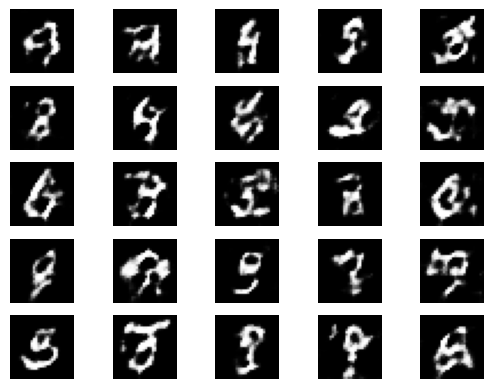

  0%|          | 0/750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 219ms/step


  0%|          | 1/750 [00:01<18:04,  1.45s/it]

1/1 [==============================] - 0s 206ms/step


  0%|          | 2/750 [00:02<17:52,  1.43s/it]

1/1 [==============================] - 0s 206ms/step


  0%|          | 3/750 [00:04<18:15,  1.47s/it]

1/1 [==============================] - 0s 210ms/step


  1%|          | 4/750 [00:05<18:03,  1.45s/it]

1/1 [==============================] - 0s 230ms/step


  1%|          | 5/750 [00:07<18:05,  1.46s/it]

1/1 [==============================] - 0s 209ms/step


  1%|          | 6/750 [00:08<16:11,  1.31s/it]

1/1 [==============================] - 0s 133ms/step


  1%|          | 7/750 [00:09<14:24,  1.16s/it]

1/1 [==============================] - 0s 133ms/step


  1%|          | 8/750 [00:10<13:16,  1.07s/it]

1/1 [==============================] - 0s 137ms/step


  1%|          | 9/750 [00:10<12:29,  1.01s/it]

1/1 [==============================] - 0s 129ms/step


  1%|▏         | 10/750 [00:11<12:06,  1.02it/s]

1/1 [==============================] - 0s 134ms/step


  1%|▏         | 11/750 [00:12<11:42,  1.05it/s]

1/1 [==============================] - 0s 131ms/step


  2%|▏         | 12/750 [00:13<11:28,  1.07it/s]

1/1 [==============================] - 0s 137ms/step


  2%|▏         | 13/750 [00:14<11:20,  1.08it/s]

1/1 [==============================] - 0s 130ms/step


  2%|▏         | 14/750 [00:15<11:10,  1.10it/s]

1/1 [==============================] - 0s 134ms/step


  2%|▏         | 15/750 [00:16<11:02,  1.11it/s]

1/1 [==============================] - 0s 143ms/step


  2%|▏         | 16/750 [00:17<11:01,  1.11it/s]

1/1 [==============================] - 0s 133ms/step


  2%|▏         | 17/750 [00:18<12:01,  1.02it/s]

1/1 [==============================] - 0s 231ms/step


  2%|▏         | 18/750 [00:19<13:55,  1.14s/it]

1/1 [==============================] - 0s 222ms/step


  3%|▎         | 19/750 [00:21<15:10,  1.25s/it]

1/1 [==============================] - 0s 214ms/step


  3%|▎         | 20/750 [00:22<15:50,  1.30s/it]

1/1 [==============================] - 0s 212ms/step


  3%|▎         | 21/750 [00:24<16:44,  1.38s/it]

1/1 [==============================] - 0s 210ms/step


  3%|▎         | 22/750 [00:25<15:58,  1.32s/it]

1/1 [==============================] - 0s 131ms/step


  3%|▎         | 23/750 [00:26<14:23,  1.19s/it]

1/1 [==============================] - 0s 129ms/step


  3%|▎         | 24/750 [00:27<13:16,  1.10s/it]

1/1 [==============================] - 0s 130ms/step


  3%|▎         | 25/750 [00:28<12:29,  1.03s/it]

1/1 [==============================] - 0s 127ms/step


  3%|▎         | 26/750 [00:29<11:55,  1.01it/s]

1/1 [==============================] - 0s 129ms/step


  4%|▎         | 27/750 [00:29<11:29,  1.05it/s]

1/1 [==============================] - 0s 138ms/step


  4%|▎         | 28/750 [00:30<11:20,  1.06it/s]

1/1 [==============================] - 0s 153ms/step


  4%|▍         | 29/750 [00:31<11:09,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


  4%|▍         | 30/750 [00:32<10:59,  1.09it/s]

1/1 [==============================] - 0s 140ms/step


  4%|▍         | 31/750 [00:33<10:54,  1.10it/s]

1/1 [==============================] - 0s 132ms/step


  4%|▍         | 32/750 [00:34<10:47,  1.11it/s]

1/1 [==============================] - 0s 129ms/step


  4%|▍         | 33/750 [00:35<11:06,  1.08it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▍         | 34/750 [00:36<13:09,  1.10s/it]

1/1 [==============================] - 0s 218ms/step


  5%|▍         | 35/750 [00:38<14:35,  1.22s/it]

1/1 [==============================] - 0s 216ms/step


  5%|▍         | 36/750 [00:39<15:28,  1.30s/it]

1/1 [==============================] - 0s 212ms/step


  5%|▍         | 37/750 [00:41<15:57,  1.34s/it]

1/1 [==============================] - 0s 214ms/step


  5%|▌         | 38/750 [00:42<16:03,  1.35s/it]

1/1 [==============================] - 0s 170ms/step


  5%|▌         | 39/750 [00:43<14:38,  1.24s/it]

1/1 [==============================] - 0s 133ms/step


  5%|▌         | 40/750 [00:44<13:21,  1.13s/it]

1/1 [==============================] - 0s 133ms/step


  5%|▌         | 41/750 [00:45<12:30,  1.06s/it]

1/1 [==============================] - 0s 135ms/step


  6%|▌         | 42/750 [00:46<11:57,  1.01s/it]

1/1 [==============================] - 0s 149ms/step


  6%|▌         | 43/750 [00:47<11:31,  1.02it/s]

1/1 [==============================] - 0s 133ms/step


  6%|▌         | 44/750 [00:48<11:13,  1.05it/s]

1/1 [==============================] - 0s 132ms/step


  6%|▌         | 45/750 [00:49<11:05,  1.06it/s]

1/1 [==============================] - 0s 129ms/step


  6%|▌         | 46/750 [00:49<10:54,  1.08it/s]

1/1 [==============================] - 0s 134ms/step


  6%|▋         | 47/750 [00:50<10:50,  1.08it/s]

1/1 [==============================] - 0s 134ms/step


  6%|▋         | 48/750 [00:51<10:41,  1.09it/s]

1/1 [==============================] - 0s 137ms/step


  7%|▋         | 49/750 [00:52<10:32,  1.11it/s]

1/1 [==============================] - 0s 142ms/step


  7%|▋         | 50/750 [00:53<12:05,  1.04s/it]

1/1 [==============================] - 0s 212ms/step


  7%|▋         | 51/750 [00:55<13:39,  1.17s/it]

1/1 [==============================] - 0s 218ms/step


  7%|▋         | 52/750 [00:56<14:22,  1.24s/it]

1/1 [==============================] - 0s 218ms/step


  7%|▋         | 53/750 [00:58<15:06,  1.30s/it]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 54/750 [00:59<15:26,  1.33s/it]

1/1 [==============================] - 0s 214ms/step


  7%|▋         | 55/750 [01:00<15:09,  1.31s/it]

1/1 [==============================] - 0s 135ms/step


  7%|▋         | 56/750 [01:01<13:42,  1.18s/it]

1/1 [==============================] - 0s 135ms/step


  8%|▊         | 57/750 [01:02<12:42,  1.10s/it]

1/1 [==============================] - 0s 134ms/step


  8%|▊         | 58/750 [01:03<12:01,  1.04s/it]

1/1 [==============================] - 0s 133ms/step


  8%|▊         | 59/750 [01:04<11:32,  1.00s/it]

1/1 [==============================] - 0s 132ms/step


  8%|▊         | 60/750 [01:05<11:07,  1.03it/s]

1/1 [==============================] - 0s 129ms/step


  8%|▊         | 61/750 [01:06<10:52,  1.06it/s]

1/1 [==============================] - 0s 139ms/step


  8%|▊         | 62/750 [01:07<10:51,  1.06it/s]

1/1 [==============================] - 0s 144ms/step


  8%|▊         | 63/750 [01:08<10:37,  1.08it/s]

1/1 [==============================] - 0s 140ms/step


  9%|▊         | 64/750 [01:09<10:35,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


  9%|▊         | 65/750 [01:09<10:26,  1.09it/s]

1/1 [==============================] - 0s 135ms/step


  9%|▉         | 66/750 [01:10<10:27,  1.09it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 67/750 [01:12<12:46,  1.12s/it]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 68/750 [01:14<14:07,  1.24s/it]

1/1 [==============================] - 0s 198ms/step


  9%|▉         | 69/750 [01:15<14:40,  1.29s/it]

1/1 [==============================] - 0s 202ms/step


  9%|▉         | 70/750 [01:16<14:55,  1.32s/it]

1/1 [==============================] - 0s 209ms/step


  9%|▉         | 71/750 [01:18<15:20,  1.36s/it]

1/1 [==============================] - 0s 131ms/step


 10%|▉         | 72/750 [01:19<13:49,  1.22s/it]

1/1 [==============================] - 0s 125ms/step


 10%|▉         | 73/750 [01:20<12:37,  1.12s/it]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 74/750 [01:20<11:44,  1.04s/it]

1/1 [==============================] - 0s 127ms/step


 10%|█         | 75/750 [01:21<11:08,  1.01it/s]

1/1 [==============================] - 0s 132ms/step


 10%|█         | 76/750 [01:22<10:40,  1.05it/s]

1/1 [==============================] - 0s 120ms/step


 10%|█         | 77/750 [01:23<10:22,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 10%|█         | 78/750 [01:24<10:13,  1.10it/s]

1/1 [==============================] - 0s 132ms/step


 11%|█         | 79/750 [01:25<10:07,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 80/750 [01:26<09:56,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█         | 81/750 [01:27<09:50,  1.13it/s]

1/1 [==============================] - 0s 132ms/step


 11%|█         | 82/750 [01:27<09:45,  1.14it/s]

1/1 [==============================] - 0s 131ms/step


 11%|█         | 83/750 [01:29<10:39,  1.04it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 84/750 [01:30<12:22,  1.11s/it]

1/1 [==============================] - 0s 195ms/step


 11%|█▏        | 85/750 [01:31<13:25,  1.21s/it]

1/1 [==============================] - 0s 194ms/step


 11%|█▏        | 86/750 [01:33<13:52,  1.25s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 87/750 [01:34<14:21,  1.30s/it]

1/1 [==============================] - 0s 200ms/step


 12%|█▏        | 88/750 [01:36<14:37,  1.33s/it]

1/1 [==============================] - 0s 125ms/step


 12%|█▏        | 89/750 [01:36<13:10,  1.20s/it]

1/1 [==============================] - 0s 119ms/step


 12%|█▏        | 90/750 [01:37<12:07,  1.10s/it]

1/1 [==============================] - 0s 128ms/step


 12%|█▏        | 91/750 [01:38<11:20,  1.03s/it]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 92/750 [01:39<10:43,  1.02it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█▏        | 93/750 [01:40<10:19,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 94/750 [01:41<10:03,  1.09it/s]

1/1 [==============================] - 0s 118ms/step


 13%|█▎        | 95/750 [01:42<09:52,  1.10it/s]

1/1 [==============================] - 0s 116ms/step


 13%|█▎        | 96/750 [01:43<10:26,  1.04it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 97/750 [01:44<10:13,  1.06it/s]

1/1 [==============================] - 0s 133ms/step


 13%|█▎        | 98/750 [01:45<10:00,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 99/750 [01:45<09:50,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 100/750 [01:47<11:00,  1.02s/it]

1/1 [==============================] - 0s 188ms/step


 13%|█▎        | 101/750 [01:48<12:28,  1.15s/it]

1/1 [==============================] - 0s 196ms/step


 14%|█▎        | 102/750 [01:50<13:07,  1.22s/it]

1/1 [==============================] - 0s 194ms/step


 14%|█▎        | 103/750 [01:51<13:39,  1.27s/it]

1/1 [==============================] - 0s 186ms/step


 14%|█▍        | 104/750 [01:52<14:00,  1.30s/it]

1/1 [==============================] - 0s 193ms/step


 14%|█▍        | 105/750 [01:54<13:46,  1.28s/it]

1/1 [==============================] - 0s 140ms/step


 14%|█▍        | 106/750 [01:54<12:30,  1.17s/it]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 107/750 [01:55<11:31,  1.08s/it]

1/1 [==============================] - 0s 124ms/step


 14%|█▍        | 108/750 [01:56<10:50,  1.01s/it]

1/1 [==============================] - 0s 115ms/step


 15%|█▍        | 109/750 [01:57<10:20,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▍        | 110/750 [01:58<10:01,  1.06it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 111/750 [01:59<09:42,  1.10it/s]

1/1 [==============================] - 0s 130ms/step


 15%|█▍        | 112/750 [02:00<09:36,  1.11it/s]

1/1 [==============================] - 0s 118ms/step


 15%|█▌        | 113/750 [02:00<09:27,  1.12it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▌        | 114/750 [02:01<09:23,  1.13it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▌        | 115/750 [02:02<09:23,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 15%|█▌        | 116/750 [02:03<09:15,  1.14it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 117/750 [02:04<10:33,  1.00s/it]

1/1 [==============================] - 0s 197ms/step


 16%|█▌        | 118/750 [02:06<11:51,  1.13s/it]

1/1 [==============================] - 0s 192ms/step


 16%|█▌        | 119/750 [02:07<12:47,  1.22s/it]

1/1 [==============================] - 0s 186ms/step


 16%|█▌        | 120/750 [02:09<13:14,  1.26s/it]

1/1 [==============================] - 0s 184ms/step


 16%|█▌        | 121/750 [02:10<13:28,  1.29s/it]

1/1 [==============================] - 0s 196ms/step


 16%|█▋        | 122/750 [02:11<13:30,  1.29s/it]

1/1 [==============================] - 0s 123ms/step


 16%|█▋        | 123/750 [02:12<12:09,  1.16s/it]

1/1 [==============================] - 0s 117ms/step


 17%|█▋        | 124/750 [02:13<11:12,  1.07s/it]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 125/750 [02:14<10:31,  1.01s/it]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 126/750 [02:15<10:05,  1.03it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 127/750 [02:16<09:44,  1.07it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 128/750 [02:16<09:26,  1.10it/s]

1/1 [==============================] - 0s 126ms/step


 17%|█▋        | 129/750 [02:17<09:17,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 130/750 [02:18<09:08,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 131/750 [02:19<09:02,  1.14it/s]

1/1 [==============================] - 0s 134ms/step


 18%|█▊        | 132/750 [02:20<09:00,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 18%|█▊        | 133/750 [02:21<09:00,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 134/750 [02:22<10:18,  1.00s/it]

1/1 [==============================] - 0s 190ms/step


 18%|█▊        | 135/750 [02:23<11:28,  1.12s/it]

1/1 [==============================] - 0s 183ms/step


 18%|█▊        | 136/750 [02:25<12:03,  1.18s/it]

1/1 [==============================] - 0s 192ms/step


 18%|█▊        | 137/750 [02:26<12:38,  1.24s/it]

1/1 [==============================] - 0s 193ms/step


 18%|█▊        | 138/750 [02:28<13:08,  1.29s/it]

1/1 [==============================] - 0s 194ms/step


 19%|█▊        | 139/750 [02:29<13:12,  1.30s/it]

1/1 [==============================] - 0s 133ms/step


 19%|█▊        | 140/750 [02:30<11:55,  1.17s/it]

1/1 [==============================] - 0s 117ms/step


 19%|█▉        | 141/750 [02:31<11:00,  1.08s/it]

1/1 [==============================] - 0s 124ms/step


 19%|█▉        | 142/750 [02:31<10:22,  1.02s/it]

1/1 [==============================] - 0s 123ms/step


 19%|█▉        | 143/750 [02:32<09:53,  1.02it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 144/750 [02:33<09:29,  1.06it/s]

1/1 [==============================] - 0s 114ms/step


 19%|█▉        | 145/750 [02:34<09:11,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 146/750 [02:35<09:01,  1.12it/s]

1/1 [==============================] - 0s 122ms/step


 20%|█▉        | 147/750 [02:36<08:57,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 20%|█▉        | 148/750 [02:37<08:56,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 20%|█▉        | 149/750 [02:38<08:49,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 20%|██        | 150/750 [02:38<08:47,  1.14it/s]

1/1 [==============================] - 0s 127ms/step


 20%|██        | 151/750 [02:40<09:51,  1.01it/s]

1/1 [==============================] - 0s 201ms/step


 20%|██        | 152/750 [02:41<11:07,  1.12s/it]

1/1 [==============================] - 0s 196ms/step


 20%|██        | 153/750 [02:42<11:56,  1.20s/it]

1/1 [==============================] - 0s 197ms/step


 21%|██        | 154/750 [02:44<12:22,  1.25s/it]

1/1 [==============================] - 0s 203ms/step


 21%|██        | 155/750 [02:45<12:49,  1.29s/it]

1/1 [==============================] - 0s 199ms/step


 21%|██        | 156/750 [02:47<13:04,  1.32s/it]

1/1 [==============================] - 0s 119ms/step


 21%|██        | 157/750 [02:47<11:38,  1.18s/it]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 158/750 [02:48<10:39,  1.08s/it]

1/1 [==============================] - 0s 123ms/step


 21%|██        | 159/750 [02:49<10:01,  1.02s/it]

1/1 [==============================] - 0s 119ms/step


 21%|██▏       | 160/750 [02:50<09:35,  1.03it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██▏       | 161/750 [02:51<09:15,  1.06it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 162/750 [02:52<09:02,  1.08it/s]

1/1 [==============================] - 0s 116ms/step


 22%|██▏       | 163/750 [02:53<08:49,  1.11it/s]

1/1 [==============================] - 0s 128ms/step


 22%|██▏       | 164/750 [02:54<08:40,  1.13it/s]

1/1 [==============================] - 0s 118ms/step


 22%|██▏       | 165/750 [02:54<08:33,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 22%|██▏       | 166/750 [02:55<08:26,  1.15it/s]

1/1 [==============================] - 0s 119ms/step


 22%|██▏       | 167/750 [02:56<08:26,  1.15it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 168/750 [02:57<09:09,  1.06it/s]

1/1 [==============================] - 0s 199ms/step


 23%|██▎       | 169/750 [02:59<10:30,  1.09s/it]

1/1 [==============================] - 0s 190ms/step


 23%|██▎       | 170/750 [03:00<11:16,  1.17s/it]

1/1 [==============================] - 0s 194ms/step


 23%|██▎       | 171/750 [03:01<12:02,  1.25s/it]

1/1 [==============================] - 0s 188ms/step


 23%|██▎       | 172/750 [03:03<12:27,  1.29s/it]

1/1 [==============================] - 0s 193ms/step


 23%|██▎       | 173/750 [03:04<12:56,  1.35s/it]

1/1 [==============================] - 0s 122ms/step


 23%|██▎       | 174/750 [03:05<11:31,  1.20s/it]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 175/750 [03:06<10:32,  1.10s/it]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 176/750 [03:07<09:54,  1.04s/it]

1/1 [==============================] - 0s 122ms/step


 24%|██▎       | 177/750 [03:08<09:27,  1.01it/s]

1/1 [==============================] - 0s 116ms/step


 24%|██▎       | 178/750 [03:09<09:06,  1.05it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 179/750 [03:10<08:52,  1.07it/s]

1/1 [==============================] - 0s 122ms/step


 24%|██▍       | 180/750 [03:10<08:40,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 181/750 [03:11<08:34,  1.11it/s]

1/1 [==============================] - 0s 131ms/step


 24%|██▍       | 182/750 [03:12<08:26,  1.12it/s]

1/1 [==============================] - 0s 118ms/step


 24%|██▍       | 183/750 [03:13<08:19,  1.14it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▍       | 184/750 [03:14<08:16,  1.14it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▍       | 185/750 [03:15<09:06,  1.03it/s]

1/1 [==============================] - 0s 198ms/step


 25%|██▍       | 186/750 [03:16<10:20,  1.10s/it]

1/1 [==============================] - 0s 198ms/step


 25%|██▍       | 187/750 [03:18<11:09,  1.19s/it]

1/1 [==============================] - 0s 191ms/step


 25%|██▌       | 188/750 [03:19<11:41,  1.25s/it]

1/1 [==============================] - 0s 202ms/step


 25%|██▌       | 189/750 [03:21<12:22,  1.32s/it]

1/1 [==============================] - 0s 202ms/step


 25%|██▌       | 190/750 [03:22<12:28,  1.34s/it]

1/1 [==============================] - 0s 116ms/step


 25%|██▌       | 191/750 [03:23<11:08,  1.20s/it]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 192/750 [03:24<10:12,  1.10s/it]

1/1 [==============================] - 0s 131ms/step


 26%|██▌       | 193/750 [03:25<09:33,  1.03s/it]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 194/750 [03:26<09:09,  1.01it/s]

1/1 [==============================] - 0s 127ms/step


 26%|██▌       | 195/750 [03:26<08:50,  1.05it/s]

1/1 [==============================] - 0s 130ms/step


 26%|██▌       | 196/750 [03:27<08:33,  1.08it/s]

1/1 [==============================] - 0s 131ms/step


 26%|██▋       | 197/750 [03:28<08:24,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▋       | 198/750 [03:29<08:13,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 199/750 [03:30<08:10,  1.12it/s]

1/1 [==============================] - 0s 131ms/step


 27%|██▋       | 200/750 [03:31<08:07,  1.13it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 201/750 [03:32<08:06,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 202/750 [03:33<09:06,  1.00it/s]

1/1 [==============================] - 0s 211ms/step


 27%|██▋       | 203/750 [03:34<10:23,  1.14s/it]

1/1 [==============================] - 0s 210ms/step


 27%|██▋       | 204/750 [03:36<11:18,  1.24s/it]

1/1 [==============================] - 0s 191ms/step


 27%|██▋       | 205/750 [03:37<11:42,  1.29s/it]

1/1 [==============================] - 0s 221ms/step


 27%|██▋       | 206/750 [03:39<12:17,  1.36s/it]

1/1 [==============================] - 0s 190ms/step


 28%|██▊       | 207/750 [03:40<11:36,  1.28s/it]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 208/750 [03:41<10:28,  1.16s/it]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 209/750 [03:42<09:38,  1.07s/it]

1/1 [==============================] - 0s 128ms/step


 28%|██▊       | 210/750 [03:43<09:03,  1.01s/it]

1/1 [==============================] - 0s 131ms/step


 28%|██▊       | 211/750 [03:43<08:38,  1.04it/s]

1/1 [==============================] - 0s 128ms/step


 28%|██▊       | 212/750 [03:44<08:25,  1.06it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 213/750 [03:45<08:12,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▊       | 214/750 [03:46<08:01,  1.11it/s]

1/1 [==============================] - 0s 126ms/step


 29%|██▊       | 215/750 [03:47<07:55,  1.13it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 216/750 [03:48<07:50,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 217/750 [03:49<07:48,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▉       | 218/750 [03:49<07:45,  1.14it/s]

1/1 [==============================] - 0s 168ms/step


 29%|██▉       | 219/750 [03:51<09:10,  1.04s/it]

1/1 [==============================] - 0s 215ms/step


 29%|██▉       | 220/750 [03:52<10:34,  1.20s/it]

1/1 [==============================] - 0s 202ms/step


 29%|██▉       | 221/750 [03:54<11:00,  1.25s/it]

1/1 [==============================] - 0s 208ms/step


 30%|██▉       | 222/750 [03:55<11:23,  1.30s/it]

1/1 [==============================] - 0s 193ms/step


 30%|██▉       | 223/750 [03:57<11:28,  1.31s/it]

1/1 [==============================] - 0s 192ms/step


 30%|██▉       | 224/750 [03:58<10:56,  1.25s/it]

1/1 [==============================] - 0s 115ms/step


 30%|███       | 225/750 [03:59<09:56,  1.14s/it]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 226/750 [03:59<09:14,  1.06s/it]

1/1 [==============================] - 0s 119ms/step


 30%|███       | 227/750 [04:00<08:41,  1.00it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███       | 228/750 [04:01<08:22,  1.04it/s]

1/1 [==============================] - 0s 141ms/step


 31%|███       | 229/750 [04:02<08:08,  1.07it/s]

1/1 [==============================] - 0s 129ms/step


 31%|███       | 230/750 [04:03<07:57,  1.09it/s]

1/1 [==============================] - 0s 130ms/step


 31%|███       | 231/750 [04:04<07:50,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 232/750 [04:05<07:42,  1.12it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███       | 233/750 [04:06<07:38,  1.13it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███       | 234/750 [04:06<07:32,  1.14it/s]

1/1 [==============================] - 0s 132ms/step


 31%|███▏      | 235/750 [04:07<07:30,  1.14it/s]

1/1 [==============================] - 0s 180ms/step


 31%|███▏      | 236/750 [04:09<08:47,  1.03s/it]

1/1 [==============================] - 0s 201ms/step


 32%|███▏      | 237/750 [04:10<09:48,  1.15s/it]

1/1 [==============================] - 0s 188ms/step


 32%|███▏      | 238/750 [04:11<10:20,  1.21s/it]

1/1 [==============================] - 0s 217ms/step


 32%|███▏      | 239/750 [04:13<10:48,  1.27s/it]

1/1 [==============================] - 0s 192ms/step


 32%|███▏      | 240/750 [04:14<10:57,  1.29s/it]

1/1 [==============================] - 0s 190ms/step


 32%|███▏      | 241/750 [04:15<10:39,  1.26s/it]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 242/750 [04:16<09:40,  1.14s/it]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 243/750 [04:17<08:58,  1.06s/it]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 244/750 [04:18<08:25,  1.00it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 245/750 [04:19<08:05,  1.04it/s]

1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 246/750 [04:20<07:47,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 247/750 [04:21<07:38,  1.10it/s]

1/1 [==============================] - 0s 119ms/step


 33%|███▎      | 248/750 [04:21<07:30,  1.12it/s]

1/1 [==============================] - 0s 117ms/step


 33%|███▎      | 249/750 [04:22<07:25,  1.13it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 250/750 [04:23<07:21,  1.13it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 251/750 [04:24<07:15,  1.15it/s]

1/1 [==============================] - 0s 129ms/step


 34%|███▎      | 252/750 [04:25<07:12,  1.15it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 253/750 [04:26<08:20,  1.01s/it]

1/1 [==============================] - 0s 201ms/step


 34%|███▍      | 254/750 [04:28<09:26,  1.14s/it]

1/1 [==============================] - 0s 197ms/step


 34%|███▍      | 255/750 [04:29<10:14,  1.24s/it]

1/1 [==============================] - 0s 197ms/step


 34%|███▍      | 256/750 [04:30<10:28,  1.27s/it]

1/1 [==============================] - 0s 200ms/step


 34%|███▍      | 257/750 [04:32<10:39,  1.30s/it]

1/1 [==============================] - 0s 195ms/step


 34%|███▍      | 258/750 [04:33<10:30,  1.28s/it]

1/1 [==============================] - 0s 115ms/step


 35%|███▍      | 259/750 [04:34<09:26,  1.15s/it]

1/1 [==============================] - 0s 117ms/step


 35%|███▍      | 260/750 [04:35<08:43,  1.07s/it]

1/1 [==============================] - 0s 117ms/step


 35%|███▍      | 261/750 [04:36<08:08,  1.00it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 262/750 [04:36<07:48,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 35%|███▌      | 263/750 [04:37<07:34,  1.07it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▌      | 264/750 [04:38<07:23,  1.10it/s]

1/1 [==============================] - 0s 117ms/step


 35%|███▌      | 265/750 [04:39<07:14,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 266/750 [04:40<07:11,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 36%|███▌      | 267/750 [04:41<07:08,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 36%|███▌      | 268/750 [04:42<07:02,  1.14it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▌      | 269/750 [04:43<07:00,  1.14it/s]

1/1 [==============================] - 0s 124ms/step


 36%|███▌      | 270/750 [04:44<07:59,  1.00it/s]

1/1 [==============================] - 0s 196ms/step


 36%|███▌      | 271/750 [04:45<09:04,  1.14s/it]

1/1 [==============================] - 0s 193ms/step


 36%|███▋      | 272/750 [04:47<09:35,  1.20s/it]

1/1 [==============================] - 0s 190ms/step


 36%|███▋      | 273/750 [04:48<09:57,  1.25s/it]

1/1 [==============================] - 0s 199ms/step


 37%|███▋      | 274/750 [04:49<10:08,  1.28s/it]

1/1 [==============================] - 0s 193ms/step


 37%|███▋      | 275/750 [04:51<10:14,  1.29s/it]

1/1 [==============================] - 0s 116ms/step


 37%|███▋      | 276/750 [04:52<09:10,  1.16s/it]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 277/750 [04:52<08:27,  1.07s/it]

1/1 [==============================] - 0s 118ms/step


 37%|███▋      | 278/750 [04:53<07:56,  1.01s/it]

1/1 [==============================] - 0s 121ms/step


 37%|███▋      | 279/750 [04:54<07:34,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 37%|███▋      | 280/750 [04:55<07:18,  1.07it/s]

1/1 [==============================] - 0s 116ms/step


 37%|███▋      | 281/750 [04:56<07:07,  1.10it/s]

1/1 [==============================] - 0s 116ms/step


 38%|███▊      | 282/750 [04:57<07:00,  1.11it/s]

1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 283/750 [04:58<06:56,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 38%|███▊      | 284/750 [04:58<06:51,  1.13it/s]

1/1 [==============================] - 0s 128ms/step


 38%|███▊      | 285/750 [04:59<06:49,  1.14it/s]

1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 286/750 [05:00<06:46,  1.14it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 287/750 [05:01<07:25,  1.04it/s]

1/1 [==============================] - 0s 206ms/step


 38%|███▊      | 288/750 [05:03<08:30,  1.10s/it]

1/1 [==============================] - 0s 188ms/step


 39%|███▊      | 289/750 [05:04<08:54,  1.16s/it]

1/1 [==============================] - 0s 193ms/step


 39%|███▊      | 290/750 [05:05<09:24,  1.23s/it]

1/1 [==============================] - 0s 190ms/step


 39%|███▉      | 291/750 [05:07<09:46,  1.28s/it]

1/1 [==============================] - 0s 190ms/step


 39%|███▉      | 292/750 [05:08<09:56,  1.30s/it]

1/1 [==============================] - 0s 187ms/step


 39%|███▉      | 293/750 [05:09<09:06,  1.20s/it]

1/1 [==============================] - 0s 117ms/step


 39%|███▉      | 294/750 [05:10<08:19,  1.10s/it]

1/1 [==============================] - 0s 116ms/step


 39%|███▉      | 295/750 [05:11<07:42,  1.02s/it]

1/1 [==============================] - 0s 128ms/step


 39%|███▉      | 296/750 [05:12<07:20,  1.03it/s]

1/1 [==============================] - 0s 116ms/step


 40%|███▉      | 297/750 [05:13<07:03,  1.07it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███▉      | 298/750 [05:13<06:54,  1.09it/s]

1/1 [==============================] - 0s 132ms/step


 40%|███▉      | 299/750 [05:14<06:50,  1.10it/s]

1/1 [==============================] - 0s 128ms/step


 40%|████      | 300/750 [05:15<06:44,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 40%|████      | 301/750 [05:16<06:37,  1.13it/s]

1/1 [==============================] - 0s 117ms/step


 40%|████      | 302/750 [05:17<06:33,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 40%|████      | 303/750 [05:18<06:29,  1.15it/s]

1/1 [==============================] - 0s 114ms/step


 41%|████      | 304/750 [05:19<06:35,  1.13it/s]

1/1 [==============================] - 0s 191ms/step


 41%|████      | 305/750 [05:20<07:45,  1.05s/it]

1/1 [==============================] - 0s 201ms/step


 41%|████      | 306/750 [05:22<08:28,  1.15s/it]

1/1 [==============================] - 0s 193ms/step


 41%|████      | 307/750 [05:23<08:49,  1.19s/it]

1/1 [==============================] - 0s 197ms/step


 41%|████      | 308/750 [05:24<09:11,  1.25s/it]

1/1 [==============================] - 0s 201ms/step


 41%|████      | 309/750 [05:26<09:40,  1.32s/it]

1/1 [==============================] - 0s 197ms/step


 41%|████▏     | 310/750 [05:27<09:09,  1.25s/it]

1/1 [==============================] - 0s 121ms/step


 41%|████▏     | 311/750 [05:28<08:17,  1.13s/it]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 312/750 [05:28<07:39,  1.05s/it]

1/1 [==============================] - 0s 129ms/step


 42%|████▏     | 313/750 [05:29<07:13,  1.01it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 314/750 [05:30<07:02,  1.03it/s]

1/1 [==============================] - 0s 117ms/step


 42%|████▏     | 315/750 [05:31<06:49,  1.06it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 316/750 [05:32<06:38,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████▏     | 317/750 [05:33<06:31,  1.11it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 318/750 [05:34<06:24,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 319/750 [05:35<06:22,  1.13it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 320/750 [05:35<06:19,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 321/750 [05:36<06:15,  1.14it/s]

1/1 [==============================] - 0s 185ms/step


 43%|████▎     | 322/750 [05:38<07:22,  1.03s/it]

1/1 [==============================] - 0s 198ms/step


 43%|████▎     | 323/750 [05:39<08:06,  1.14s/it]

1/1 [==============================] - 0s 201ms/step


 43%|████▎     | 324/750 [05:40<08:32,  1.20s/it]

1/1 [==============================] - 0s 197ms/step


 43%|████▎     | 325/750 [05:42<08:56,  1.26s/it]

1/1 [==============================] - 0s 201ms/step


 43%|████▎     | 326/750 [05:43<09:28,  1.34s/it]

1/1 [==============================] - 0s 192ms/step


 44%|████▎     | 327/750 [05:45<08:55,  1.27s/it]

1/1 [==============================] - 0s 114ms/step


 44%|████▎     | 328/750 [05:45<08:02,  1.14s/it]

1/1 [==============================] - 0s 129ms/step


 44%|████▍     | 329/750 [05:46<07:26,  1.06s/it]

1/1 [==============================] - 0s 120ms/step


 44%|████▍     | 330/750 [05:47<06:59,  1.00it/s]

1/1 [==============================] - 0s 125ms/step


 44%|████▍     | 331/750 [05:48<06:41,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 44%|████▍     | 332/750 [05:49<06:28,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 44%|████▍     | 333/750 [05:50<06:19,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▍     | 334/750 [05:51<06:11,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▍     | 335/750 [05:51<06:06,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 45%|████▍     | 336/750 [05:52<06:04,  1.14it/s]

1/1 [==============================] - 0s 118ms/step


 45%|████▍     | 337/750 [05:53<06:01,  1.14it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▌     | 338/750 [05:54<05:58,  1.15it/s]

1/1 [==============================] - 0s 189ms/step


 45%|████▌     | 339/750 [05:55<07:07,  1.04s/it]

1/1 [==============================] - 0s 211ms/step


 45%|████▌     | 340/750 [05:57<07:55,  1.16s/it]

1/1 [==============================] - 0s 191ms/step


 45%|████▌     | 341/750 [05:58<08:16,  1.21s/it]

1/1 [==============================] - 0s 198ms/step


 46%|████▌     | 342/750 [06:00<08:37,  1.27s/it]

1/1 [==============================] - 0s 201ms/step


 46%|████▌     | 343/750 [06:01<09:04,  1.34s/it]

1/1 [==============================] - 0s 197ms/step


 46%|████▌     | 344/750 [06:02<08:26,  1.25s/it]

1/1 [==============================] - 0s 117ms/step


 46%|████▌     | 345/750 [06:03<07:37,  1.13s/it]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 346/750 [06:04<07:02,  1.05s/it]

1/1 [==============================] - 0s 119ms/step


 46%|████▋     | 347/750 [06:05<06:39,  1.01it/s]

1/1 [==============================] - 0s 115ms/step


 46%|████▋     | 348/750 [06:06<06:23,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 349/750 [06:06<06:12,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 47%|████▋     | 350/750 [06:07<06:06,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████▋     | 351/750 [06:08<05:59,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 352/750 [06:09<05:53,  1.13it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████▋     | 353/750 [06:10<05:49,  1.14it/s]

1/1 [==============================] - 0s 132ms/step


 47%|████▋     | 354/750 [06:11<05:47,  1.14it/s]

1/1 [==============================] - 0s 116ms/step


 47%|████▋     | 355/750 [06:12<05:47,  1.14it/s]

1/1 [==============================] - 0s 202ms/step


 47%|████▋     | 356/750 [06:13<06:47,  1.03s/it]

1/1 [==============================] - 0s 209ms/step


 48%|████▊     | 357/750 [06:15<07:36,  1.16s/it]

1/1 [==============================] - 0s 193ms/step


 48%|████▊     | 358/750 [06:16<08:11,  1.25s/it]

1/1 [==============================] - 0s 195ms/step


 48%|████▊     | 359/750 [06:17<08:21,  1.28s/it]

1/1 [==============================] - 0s 202ms/step


 48%|████▊     | 360/750 [06:19<08:37,  1.33s/it]

1/1 [==============================] - 0s 191ms/step


 48%|████▊     | 361/750 [06:20<08:04,  1.25s/it]

1/1 [==============================] - 0s 117ms/step


 48%|████▊     | 362/750 [06:21<07:17,  1.13s/it]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 363/750 [06:22<06:44,  1.05s/it]

1/1 [==============================] - 0s 120ms/step


 49%|████▊     | 364/750 [06:22<06:22,  1.01it/s]

1/1 [==============================] - 0s 128ms/step


 49%|████▊     | 365/750 [06:23<06:07,  1.05it/s]

1/1 [==============================] - 0s 118ms/step


 49%|████▉     | 366/750 [06:24<05:55,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 367/750 [06:25<05:46,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 49%|████▉     | 368/750 [06:26<05:41,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 369/750 [06:27<05:38,  1.12it/s]

1/1 [==============================] - 0s 121ms/step


 49%|████▉     | 370/750 [06:28<05:35,  1.13it/s]

1/1 [==============================] - 0s 137ms/step


 49%|████▉     | 371/750 [06:28<05:34,  1.13it/s]

1/1 [==============================] - 0s 121ms/step


 50%|████▉     | 372/750 [06:29<05:31,  1.14it/s]

1/1 [==============================] - 0s 191ms/step


 50%|████▉     | 373/750 [06:31<06:34,  1.05s/it]

1/1 [==============================] - 0s 188ms/step


 50%|████▉     | 374/750 [06:32<07:16,  1.16s/it]

1/1 [==============================] - 0s 207ms/step


 50%|█████     | 375/750 [06:34<07:46,  1.24s/it]

1/1 [==============================] - 0s 187ms/step


 50%|█████     | 376/750 [06:35<07:59,  1.28s/it]

1/1 [==============================] - 0s 198ms/step


 50%|█████     | 377/750 [06:36<08:10,  1.32s/it]

1/1 [==============================] - 0s 198ms/step


 50%|█████     | 378/750 [06:38<07:44,  1.25s/it]

1/1 [==============================] - 0s 116ms/step


 51%|█████     | 379/750 [06:38<06:59,  1.13s/it]

1/1 [==============================] - 0s 116ms/step


 51%|█████     | 380/750 [06:39<06:27,  1.05s/it]

1/1 [==============================] - 0s 119ms/step


 51%|█████     | 381/750 [06:40<06:03,  1.01it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 382/750 [06:41<05:48,  1.06it/s]

1/1 [==============================] - 0s 117ms/step


 51%|█████     | 383/750 [06:42<05:38,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 51%|█████     | 384/750 [06:43<05:31,  1.10it/s]

1/1 [==============================] - 0s 128ms/step


 51%|█████▏    | 385/750 [06:44<05:29,  1.11it/s]

1/1 [==============================] - 0s 129ms/step


 51%|█████▏    | 386/750 [06:44<05:25,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 52%|█████▏    | 387/750 [06:45<05:20,  1.13it/s]

1/1 [==============================] - 0s 130ms/step


 52%|█████▏    | 388/750 [06:46<05:15,  1.15it/s]

1/1 [==============================] - 0s 123ms/step


 52%|█████▏    | 389/750 [06:47<05:13,  1.15it/s]

1/1 [==============================] - 0s 191ms/step


 52%|█████▏    | 390/750 [06:48<06:10,  1.03s/it]

1/1 [==============================] - 0s 196ms/step


 52%|█████▏    | 391/750 [06:50<06:49,  1.14s/it]

1/1 [==============================] - 0s 189ms/step


 52%|█████▏    | 392/750 [06:51<07:12,  1.21s/it]

1/1 [==============================] - 0s 187ms/step


 52%|█████▏    | 393/750 [06:52<07:26,  1.25s/it]

1/1 [==============================] - 0s 194ms/step


 53%|█████▎    | 394/750 [06:54<07:36,  1.28s/it]

1/1 [==============================] - 0s 199ms/step


 53%|█████▎    | 395/750 [06:55<07:26,  1.26s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████▎    | 396/750 [06:56<06:43,  1.14s/it]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 397/750 [06:57<06:12,  1.06s/it]

1/1 [==============================] - 0s 129ms/step


 53%|█████▎    | 398/750 [06:58<05:49,  1.01it/s]

1/1 [==============================] - 0s 128ms/step


 53%|█████▎    | 399/750 [06:58<05:35,  1.05it/s]

1/1 [==============================] - 0s 120ms/step


 53%|█████▎    | 400/750 [06:59<05:24,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 401/750 [07:00<05:17,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████▎    | 402/750 [07:01<05:13,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▎    | 403/750 [07:02<05:07,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▍    | 404/750 [07:03<05:05,  1.13it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████▍    | 405/750 [07:04<05:02,  1.14it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▍    | 406/750 [07:05<05:01,  1.14it/s]

1/1 [==============================] - 0s 117ms/step


 54%|█████▍    | 407/750 [07:06<05:43,  1.00s/it]

1/1 [==============================] - 0s 196ms/step


 54%|█████▍    | 408/750 [07:07<06:25,  1.13s/it]

1/1 [==============================] - 0s 203ms/step


 55%|█████▍    | 409/750 [07:09<06:54,  1.22s/it]

1/1 [==============================] - 0s 189ms/step


 55%|█████▍    | 410/750 [07:10<07:06,  1.25s/it]

1/1 [==============================] - 0s 191ms/step


 55%|█████▍    | 411/750 [07:12<07:27,  1.32s/it]

1/1 [==============================] - 0s 182ms/step


 55%|█████▍    | 412/750 [07:13<07:15,  1.29s/it]

1/1 [==============================] - 0s 124ms/step


 55%|█████▌    | 413/750 [07:14<06:31,  1.16s/it]

1/1 [==============================] - 0s 120ms/step


 55%|█████▌    | 414/750 [07:14<05:59,  1.07s/it]

1/1 [==============================] - 0s 132ms/step


 55%|█████▌    | 415/750 [07:15<05:37,  1.01s/it]

1/1 [==============================] - 0s 127ms/step


 55%|█████▌    | 416/750 [07:16<05:24,  1.03it/s]

1/1 [==============================] - 0s 117ms/step


 56%|█████▌    | 417/750 [07:17<05:11,  1.07it/s]

1/1 [==============================] - 0s 114ms/step


 56%|█████▌    | 418/750 [07:18<05:04,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▌    | 419/750 [07:19<04:58,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▌    | 420/750 [07:20<04:54,  1.12it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████▌    | 421/750 [07:21<04:50,  1.13it/s]

1/1 [==============================] - 0s 134ms/step


 56%|█████▋    | 422/750 [07:21<04:48,  1.14it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████▋    | 423/750 [07:22<04:46,  1.14it/s]

1/1 [==============================] - 0s 117ms/step


 57%|█████▋    | 424/750 [07:24<05:27,  1.00s/it]

1/1 [==============================] - 0s 212ms/step


 57%|█████▋    | 425/750 [07:25<06:08,  1.14s/it]

1/1 [==============================] - 0s 192ms/step


 57%|█████▋    | 426/750 [07:26<06:28,  1.20s/it]

1/1 [==============================] - 0s 187ms/step


 57%|█████▋    | 427/750 [07:28<06:42,  1.25s/it]

1/1 [==============================] - 0s 205ms/step


 57%|█████▋    | 428/750 [07:29<06:55,  1.29s/it]

1/1 [==============================] - 0s 208ms/step


 57%|█████▋    | 429/750 [07:30<07:01,  1.31s/it]

1/1 [==============================] - 0s 125ms/step


 57%|█████▋    | 430/750 [07:31<06:17,  1.18s/it]

1/1 [==============================] - 0s 126ms/step


 57%|█████▋    | 431/750 [07:32<05:47,  1.09s/it]

1/1 [==============================] - 0s 117ms/step


 58%|█████▊    | 432/750 [07:33<05:22,  1.01s/it]

1/1 [==============================] - 0s 128ms/step


 58%|█████▊    | 433/750 [07:34<05:06,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 434/750 [07:35<04:58,  1.06it/s]

1/1 [==============================] - 0s 115ms/step


 58%|█████▊    | 435/750 [07:36<04:49,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████▊    | 436/750 [07:37<04:43,  1.11it/s]

1/1 [==============================] - 0s 117ms/step


 58%|█████▊    | 437/750 [07:37<04:40,  1.12it/s]

1/1 [==============================] - 0s 118ms/step


 58%|█████▊    | 438/750 [07:38<04:36,  1.13it/s]

1/1 [==============================] - 0s 135ms/step


 59%|█████▊    | 439/750 [07:39<04:36,  1.13it/s]

1/1 [==============================] - 0s 116ms/step


 59%|█████▊    | 440/750 [07:40<04:32,  1.14it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 441/750 [07:41<05:03,  1.02it/s]

1/1 [==============================] - 0s 208ms/step


 59%|█████▉    | 442/750 [07:43<05:42,  1.11s/it]

1/1 [==============================] - 0s 195ms/step


 59%|█████▉    | 443/750 [07:44<06:07,  1.20s/it]

1/1 [==============================] - 0s 198ms/step


 59%|█████▉    | 444/750 [07:46<06:32,  1.28s/it]

1/1 [==============================] - 0s 202ms/step


 59%|█████▉    | 445/750 [07:47<06:41,  1.32s/it]

1/1 [==============================] - 0s 189ms/step


 59%|█████▉    | 446/750 [07:48<06:35,  1.30s/it]

1/1 [==============================] - 0s 120ms/step


 60%|█████▉    | 447/750 [07:49<05:56,  1.18s/it]

1/1 [==============================] - 0s 118ms/step


 60%|█████▉    | 448/750 [07:50<05:28,  1.09s/it]

1/1 [==============================] - 0s 121ms/step


 60%|█████▉    | 449/750 [07:51<05:05,  1.02s/it]

1/1 [==============================] - 0s 121ms/step


 60%|██████    | 450/750 [07:52<04:51,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 60%|██████    | 451/750 [07:53<04:40,  1.07it/s]

1/1 [==============================] - 0s 117ms/step


 60%|██████    | 452/750 [07:53<04:33,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 60%|██████    | 453/750 [07:54<04:27,  1.11it/s]

1/1 [==============================] - 0s 115ms/step


 61%|██████    | 454/750 [07:55<04:23,  1.12it/s]

1/1 [==============================] - 0s 118ms/step


 61%|██████    | 455/750 [07:56<04:20,  1.13it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 456/750 [07:57<04:17,  1.14it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 457/750 [07:58<04:17,  1.14it/s]

1/1 [==============================] - 0s 118ms/step


 61%|██████    | 458/750 [07:59<04:45,  1.02it/s]

1/1 [==============================] - 0s 207ms/step


 61%|██████    | 459/750 [08:00<05:28,  1.13s/it]

1/1 [==============================] - 0s 201ms/step


 61%|██████▏   | 460/750 [08:02<05:47,  1.20s/it]

1/1 [==============================] - 0s 189ms/step


 61%|██████▏   | 461/750 [08:03<06:00,  1.25s/it]

1/1 [==============================] - 0s 197ms/step


 62%|██████▏   | 462/750 [08:05<06:11,  1.29s/it]

1/1 [==============================] - 0s 194ms/step


 62%|██████▏   | 463/750 [08:06<06:17,  1.31s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████▏   | 464/750 [08:07<05:38,  1.18s/it]

1/1 [==============================] - 0s 121ms/step


 62%|██████▏   | 465/750 [08:08<05:11,  1.09s/it]

1/1 [==============================] - 0s 116ms/step


 62%|██████▏   | 466/750 [08:09<04:52,  1.03s/it]

1/1 [==============================] - 0s 122ms/step


 62%|██████▏   | 467/750 [08:09<04:36,  1.02it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 468/750 [08:10<04:27,  1.06it/s]

1/1 [==============================] - 0s 129ms/step


 63%|██████▎   | 469/750 [08:11<04:20,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 470/750 [08:12<04:15,  1.10it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 471/750 [08:13<04:11,  1.11it/s]

1/1 [==============================] - 0s 126ms/step


 63%|██████▎   | 472/750 [08:14<04:08,  1.12it/s]

1/1 [==============================] - 0s 125ms/step


 63%|██████▎   | 473/750 [08:15<04:07,  1.12it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 474/750 [08:16<04:04,  1.13it/s]

1/1 [==============================] - 0s 138ms/step


 63%|██████▎   | 475/750 [08:17<04:36,  1.00s/it]

1/1 [==============================] - 0s 202ms/step


 63%|██████▎   | 476/750 [08:18<05:11,  1.14s/it]

1/1 [==============================] - 0s 210ms/step


 64%|██████▎   | 477/750 [08:20<05:28,  1.20s/it]

1/1 [==============================] - 0s 201ms/step


 64%|██████▎   | 478/750 [08:21<05:41,  1.26s/it]

1/1 [==============================] - 0s 181ms/step


 64%|██████▍   | 479/750 [08:22<05:45,  1.28s/it]

1/1 [==============================] - 0s 201ms/step


 64%|██████▍   | 480/750 [08:24<05:52,  1.31s/it]

1/1 [==============================] - 0s 132ms/step


 64%|██████▍   | 481/750 [08:25<05:18,  1.19s/it]

1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 482/750 [08:26<04:53,  1.09s/it]

1/1 [==============================] - 0s 122ms/step


 64%|██████▍   | 483/750 [08:26<04:35,  1.03s/it]

1/1 [==============================] - 0s 120ms/step


 65%|██████▍   | 484/750 [08:27<04:23,  1.01it/s]

1/1 [==============================] - 0s 119ms/step


 65%|██████▍   | 485/750 [08:28<04:11,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 65%|██████▍   | 486/750 [08:29<04:04,  1.08it/s]

1/1 [==============================] - 0s 134ms/step


 65%|██████▍   | 487/750 [08:30<04:00,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 65%|██████▌   | 488/750 [08:31<03:57,  1.10it/s]

1/1 [==============================] - 0s 132ms/step


 65%|██████▌   | 489/750 [08:32<03:54,  1.11it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████▌   | 490/750 [08:33<03:51,  1.12it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████▌   | 491/750 [08:33<03:50,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 492/750 [08:35<04:10,  1.03it/s]

1/1 [==============================] - 0s 208ms/step


 66%|██████▌   | 493/750 [08:36<04:53,  1.14s/it]

1/1 [==============================] - 0s 202ms/step


 66%|██████▌   | 494/750 [08:38<05:08,  1.21s/it]

1/1 [==============================] - 0s 195ms/step


 66%|██████▌   | 495/750 [08:39<05:21,  1.26s/it]

1/1 [==============================] - 0s 194ms/step


 66%|██████▌   | 496/750 [08:40<05:25,  1.28s/it]

1/1 [==============================] - 0s 203ms/step


 66%|██████▋   | 497/750 [08:42<05:29,  1.30s/it]

1/1 [==============================] - 0s 160ms/step


 66%|██████▋   | 498/750 [08:43<05:00,  1.19s/it]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 499/750 [08:43<04:35,  1.10s/it]

1/1 [==============================] - 0s 132ms/step


 67%|██████▋   | 500/750 [08:44<04:18,  1.04s/it]

1/1 [==============================] - 0s 127ms/step


 67%|██████▋   | 501/750 [08:45<04:06,  1.01it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 502/750 [08:46<03:57,  1.04it/s]

1/1 [==============================] - 0s 125ms/step


 67%|██████▋   | 503/750 [08:47<03:49,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 504/750 [08:48<03:45,  1.09it/s]

1/1 [==============================] - 0s 128ms/step


 67%|██████▋   | 505/750 [08:49<03:41,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 506/750 [08:50<03:39,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 68%|██████▊   | 507/750 [08:50<03:35,  1.13it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████▊   | 508/750 [08:51<03:34,  1.13it/s]

1/1 [==============================] - 0s 123ms/step


 68%|██████▊   | 509/750 [08:52<03:53,  1.03it/s]

1/1 [==============================] - 0s 198ms/step


 68%|██████▊   | 510/750 [08:54<04:35,  1.15s/it]

1/1 [==============================] - 0s 206ms/step


 68%|██████▊   | 511/750 [08:55<04:55,  1.24s/it]

1/1 [==============================] - 0s 208ms/step


 68%|██████▊   | 512/750 [08:57<05:04,  1.28s/it]

1/1 [==============================] - 0s 197ms/step


 68%|██████▊   | 513/750 [08:58<05:12,  1.32s/it]

1/1 [==============================] - 0s 201ms/step


 69%|██████▊   | 514/750 [09:00<05:13,  1.33s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████▊   | 515/750 [09:00<04:40,  1.19s/it]

1/1 [==============================] - 0s 124ms/step


 69%|██████▉   | 516/750 [09:01<04:15,  1.09s/it]

1/1 [==============================] - 0s 133ms/step


 69%|██████▉   | 517/750 [09:02<04:01,  1.03s/it]

1/1 [==============================] - 0s 119ms/step


 69%|██████▉   | 518/750 [09:03<03:48,  1.02it/s]

1/1 [==============================] - 0s 118ms/step


 69%|██████▉   | 519/750 [09:04<03:39,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 69%|██████▉   | 520/750 [09:05<03:34,  1.07it/s]

1/1 [==============================] - 0s 118ms/step


 69%|██████▉   | 521/750 [09:06<03:29,  1.09it/s]

1/1 [==============================] - 0s 118ms/step


 70%|██████▉   | 522/750 [09:07<03:24,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 70%|██████▉   | 523/750 [09:07<03:21,  1.13it/s]

1/1 [==============================] - 0s 133ms/step


 70%|██████▉   | 524/750 [09:08<03:20,  1.13it/s]

1/1 [==============================] - 0s 130ms/step


 70%|███████   | 525/750 [09:09<03:19,  1.13it/s]

1/1 [==============================] - 0s 128ms/step


 70%|███████   | 526/750 [09:10<03:43,  1.00it/s]

1/1 [==============================] - 0s 198ms/step


 70%|███████   | 527/750 [09:12<04:14,  1.14s/it]

1/1 [==============================] - 0s 215ms/step


 70%|███████   | 528/750 [09:13<04:39,  1.26s/it]

1/1 [==============================] - 0s 205ms/step


 71%|███████   | 529/750 [09:15<04:46,  1.30s/it]

1/1 [==============================] - 0s 210ms/step


 71%|███████   | 530/750 [09:16<04:51,  1.32s/it]

1/1 [==============================] - 0s 197ms/step


 71%|███████   | 531/750 [09:18<04:45,  1.30s/it]

1/1 [==============================] - 0s 120ms/step


 71%|███████   | 532/750 [09:18<04:16,  1.17s/it]

1/1 [==============================] - 0s 131ms/step


 71%|███████   | 533/750 [09:19<03:55,  1.09s/it]

1/1 [==============================] - 0s 126ms/step


 71%|███████   | 534/750 [09:20<03:40,  1.02s/it]

1/1 [==============================] - 0s 124ms/step


 71%|███████▏  | 535/750 [09:21<03:33,  1.01it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████▏  | 536/750 [09:22<03:24,  1.04it/s]

1/1 [==============================] - 0s 129ms/step


 72%|███████▏  | 537/750 [09:23<03:20,  1.06it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████▏  | 538/750 [09:24<03:15,  1.08it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 539/750 [09:25<03:12,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 540/750 [09:25<03:08,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 541/750 [09:26<03:05,  1.13it/s]

1/1 [==============================] - 0s 122ms/step


 72%|███████▏  | 542/750 [09:27<03:03,  1.13it/s]

1/1 [==============================] - 0s 195ms/step


 72%|███████▏  | 543/750 [09:29<03:34,  1.03s/it]

1/1 [==============================] - 0s 192ms/step


 73%|███████▎  | 544/750 [09:30<03:58,  1.16s/it]

1/1 [==============================] - 0s 196ms/step


 73%|███████▎  | 545/750 [09:31<04:12,  1.23s/it]

1/1 [==============================] - 0s 208ms/step


 73%|███████▎  | 546/750 [09:33<04:21,  1.28s/it]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 547/750 [09:34<04:28,  1.32s/it]

1/1 [==============================] - 0s 208ms/step


 73%|███████▎  | 548/750 [09:36<04:22,  1.30s/it]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 549/750 [09:36<03:56,  1.17s/it]

1/1 [==============================] - 0s 122ms/step


 73%|███████▎  | 550/750 [09:37<03:36,  1.08s/it]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 551/750 [09:38<03:23,  1.02s/it]

1/1 [==============================] - 0s 120ms/step


 74%|███████▎  | 552/750 [09:39<03:14,  1.02it/s]

1/1 [==============================] - 0s 120ms/step


 74%|███████▎  | 553/750 [09:40<03:06,  1.06it/s]

1/1 [==============================] - 0s 117ms/step


 74%|███████▍  | 554/750 [09:41<03:01,  1.08it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████▍  | 555/750 [09:42<02:58,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 74%|███████▍  | 556/750 [09:43<02:55,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 74%|███████▍  | 557/750 [09:43<02:53,  1.11it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████▍  | 558/750 [09:44<02:51,  1.12it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▍  | 559/750 [09:45<02:49,  1.13it/s]

1/1 [==============================] - 0s 129ms/step


 75%|███████▍  | 560/750 [09:47<03:15,  1.03s/it]

1/1 [==============================] - 0s 195ms/step


 75%|███████▍  | 561/750 [09:48<03:39,  1.16s/it]

1/1 [==============================] - 0s 208ms/step


 75%|███████▍  | 562/750 [09:49<03:52,  1.24s/it]

1/1 [==============================] - 0s 182ms/step


 75%|███████▌  | 563/750 [09:51<04:01,  1.29s/it]

1/1 [==============================] - 0s 198ms/step


 75%|███████▌  | 564/750 [09:52<04:03,  1.31s/it]

1/1 [==============================] - 0s 209ms/step


 75%|███████▌  | 565/750 [09:53<03:57,  1.29s/it]

1/1 [==============================] - 0s 122ms/step


 75%|███████▌  | 566/750 [09:54<03:34,  1.17s/it]

1/1 [==============================] - 0s 127ms/step


 76%|███████▌  | 567/750 [09:55<03:18,  1.08s/it]

1/1 [==============================] - 0s 116ms/step


 76%|███████▌  | 568/750 [09:56<03:04,  1.01s/it]

1/1 [==============================] - 0s 114ms/step


 76%|███████▌  | 569/750 [09:57<02:55,  1.03it/s]

1/1 [==============================] - 0s 126ms/step


 76%|███████▌  | 570/750 [09:58<02:49,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 76%|███████▌  | 571/750 [09:59<02:45,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 76%|███████▋  | 572/750 [10:00<02:41,  1.10it/s]

1/1 [==============================] - 0s 134ms/step


 76%|███████▋  | 573/750 [10:00<02:39,  1.11it/s]

1/1 [==============================] - 0s 116ms/step


 77%|███████▋  | 574/750 [10:01<02:37,  1.12it/s]

1/1 [==============================] - 0s 132ms/step


 77%|███████▋  | 575/750 [10:02<02:35,  1.13it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 576/750 [10:03<02:33,  1.13it/s]

1/1 [==============================] - 0s 192ms/step


 77%|███████▋  | 577/750 [10:05<03:02,  1.05s/it]

1/1 [==============================] - 0s 198ms/step


 77%|███████▋  | 578/750 [10:06<03:26,  1.20s/it]

1/1 [==============================] - 0s 191ms/step


 77%|███████▋  | 579/750 [10:07<03:33,  1.25s/it]

1/1 [==============================] - 0s 192ms/step


 77%|███████▋  | 580/750 [10:09<03:40,  1.30s/it]

1/1 [==============================] - 0s 193ms/step


 77%|███████▋  | 581/750 [10:10<03:42,  1.32s/it]

1/1 [==============================] - 0s 211ms/step


 78%|███████▊  | 582/750 [10:11<03:34,  1.27s/it]

1/1 [==============================] - 0s 121ms/step


 78%|███████▊  | 583/750 [10:12<03:12,  1.15s/it]

1/1 [==============================] - 0s 120ms/step


 78%|███████▊  | 584/750 [10:13<02:57,  1.07s/it]

1/1 [==============================] - 0s 120ms/step


 78%|███████▊  | 585/750 [10:14<02:46,  1.01s/it]

1/1 [==============================] - 0s 132ms/step


 78%|███████▊  | 586/750 [10:15<02:39,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 78%|███████▊  | 587/750 [10:16<02:35,  1.05it/s]

1/1 [==============================] - 0s 120ms/step


 78%|███████▊  | 588/750 [10:17<02:30,  1.08it/s]

1/1 [==============================] - 0s 122ms/step


 79%|███████▊  | 589/750 [10:18<02:27,  1.09it/s]

1/1 [==============================] - 0s 132ms/step


 79%|███████▊  | 590/750 [10:18<02:24,  1.10it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 591/750 [10:19<02:21,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 79%|███████▉  | 592/750 [10:20<02:19,  1.13it/s]

1/1 [==============================] - 0s 120ms/step


 79%|███████▉  | 593/750 [10:21<02:21,  1.11it/s]

1/1 [==============================] - 0s 190ms/step


 79%|███████▉  | 594/750 [10:23<02:48,  1.08s/it]

1/1 [==============================] - 0s 202ms/step


 79%|███████▉  | 595/750 [10:24<03:00,  1.17s/it]

1/1 [==============================] - 0s 201ms/step


 79%|███████▉  | 596/750 [10:25<03:12,  1.25s/it]

1/1 [==============================] - 0s 207ms/step


 80%|███████▉  | 597/750 [10:27<03:17,  1.29s/it]

1/1 [==============================] - 0s 193ms/step


 80%|███████▉  | 598/750 [10:28<03:21,  1.32s/it]

1/1 [==============================] - 0s 201ms/step


 80%|███████▉  | 599/750 [10:29<03:10,  1.26s/it]

1/1 [==============================] - 0s 134ms/step


 80%|████████  | 600/750 [10:30<02:52,  1.15s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████  | 601/750 [10:31<02:38,  1.07s/it]

1/1 [==============================] - 0s 125ms/step


 80%|████████  | 602/750 [10:32<02:30,  1.02s/it]

1/1 [==============================] - 0s 123ms/step


 80%|████████  | 603/750 [10:33<02:22,  1.03it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████  | 604/750 [10:34<02:17,  1.06it/s]

1/1 [==============================] - 0s 135ms/step


 81%|████████  | 605/750 [10:35<02:15,  1.07it/s]

1/1 [==============================] - 0s 128ms/step


 81%|████████  | 606/750 [10:35<02:12,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 81%|████████  | 607/750 [10:36<02:09,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████  | 608/750 [10:37<02:07,  1.11it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████  | 609/750 [10:38<02:06,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 81%|████████▏ | 610/750 [10:39<02:06,  1.11it/s]

1/1 [==============================] - 0s 192ms/step


 81%|████████▏ | 611/750 [10:41<02:32,  1.10s/it]

1/1 [==============================] - 0s 194ms/step


 82%|████████▏ | 612/750 [10:42<02:43,  1.19s/it]

1/1 [==============================] - 0s 204ms/step


 82%|████████▏ | 613/750 [10:44<02:56,  1.29s/it]

1/1 [==============================] - 0s 198ms/step


 82%|████████▏ | 614/750 [10:45<03:04,  1.35s/it]

1/1 [==============================] - 0s 196ms/step


 82%|████████▏ | 615/750 [10:47<03:07,  1.39s/it]

1/1 [==============================] - 0s 142ms/step


 82%|████████▏ | 616/750 [10:47<02:47,  1.25s/it]

1/1 [==============================] - 0s 128ms/step


 82%|████████▏ | 617/750 [10:48<02:31,  1.14s/it]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 618/750 [10:49<02:19,  1.06s/it]

1/1 [==============================] - 0s 119ms/step


 83%|████████▎ | 619/750 [10:50<02:11,  1.00s/it]

1/1 [==============================] - 0s 125ms/step


 83%|████████▎ | 620/750 [10:51<02:05,  1.04it/s]

1/1 [==============================] - 0s 122ms/step


 83%|████████▎ | 621/750 [10:52<02:01,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 83%|████████▎ | 622/750 [10:53<01:58,  1.08it/s]

1/1 [==============================] - 0s 114ms/step


 83%|████████▎ | 623/750 [10:54<01:54,  1.11it/s]

1/1 [==============================] - 0s 134ms/step


 83%|████████▎ | 624/750 [10:54<01:52,  1.12it/s]

1/1 [==============================] - 0s 125ms/step


 83%|████████▎ | 625/750 [10:55<01:51,  1.13it/s]

1/1 [==============================] - 0s 124ms/step


 83%|████████▎ | 626/750 [10:56<01:49,  1.13it/s]

1/1 [==============================] - 0s 119ms/step


 84%|████████▎ | 627/750 [10:57<01:57,  1.05it/s]

1/1 [==============================] - 0s 209ms/step


 84%|████████▎ | 628/750 [10:59<02:20,  1.15s/it]

1/1 [==============================] - 0s 196ms/step


 84%|████████▍ | 629/750 [11:00<02:28,  1.23s/it]

1/1 [==============================] - 0s 198ms/step


 84%|████████▍ | 630/750 [11:02<02:32,  1.27s/it]

1/1 [==============================] - 0s 198ms/step


 84%|████████▍ | 631/750 [11:03<02:35,  1.31s/it]

1/1 [==============================] - 0s 193ms/step


 84%|████████▍ | 632/750 [11:04<02:35,  1.32s/it]

1/1 [==============================] - 0s 130ms/step


 84%|████████▍ | 633/750 [11:05<02:19,  1.19s/it]

1/1 [==============================] - 0s 120ms/step


 85%|████████▍ | 634/750 [11:06<02:07,  1.10s/it]

1/1 [==============================] - 0s 123ms/step


 85%|████████▍ | 635/750 [11:07<01:58,  1.03s/it]

1/1 [==============================] - 0s 129ms/step


 85%|████████▍ | 636/750 [11:08<01:52,  1.01it/s]

1/1 [==============================] - 0s 121ms/step


 85%|████████▍ | 637/750 [11:09<01:47,  1.05it/s]

1/1 [==============================] - 0s 121ms/step


 85%|████████▌ | 638/750 [11:10<01:44,  1.07it/s]

1/1 [==============================] - 0s 119ms/step


 85%|████████▌ | 639/750 [11:11<01:41,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▌ | 640/750 [11:11<01:39,  1.10it/s]

1/1 [==============================] - 0s 129ms/step


 85%|████████▌ | 641/750 [11:12<01:37,  1.11it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 642/750 [11:13<01:36,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 86%|████████▌ | 643/750 [11:14<01:34,  1.13it/s]

1/1 [==============================] - 0s 123ms/step


 86%|████████▌ | 644/750 [11:15<01:47,  1.02s/it]

1/1 [==============================] - 0s 198ms/step


 86%|████████▌ | 645/750 [11:17<02:01,  1.15s/it]

1/1 [==============================] - 0s 197ms/step


 86%|████████▌ | 646/750 [11:18<02:08,  1.23s/it]

1/1 [==============================] - 0s 199ms/step


 86%|████████▋ | 647/750 [11:20<02:12,  1.29s/it]

1/1 [==============================] - 0s 185ms/step


 86%|████████▋ | 648/750 [11:21<02:12,  1.30s/it]

1/1 [==============================] - 0s 194ms/step


 87%|████████▋ | 649/750 [11:22<02:10,  1.29s/it]

1/1 [==============================] - 0s 126ms/step


 87%|████████▋ | 650/750 [11:23<01:56,  1.17s/it]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 651/750 [11:24<01:47,  1.08s/it]

1/1 [==============================] - 0s 117ms/step


 87%|████████▋ | 652/750 [11:25<01:39,  1.02s/it]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 653/750 [11:26<01:34,  1.03it/s]

1/1 [==============================] - 0s 128ms/step


 87%|████████▋ | 654/750 [11:27<01:30,  1.06it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 655/750 [11:28<01:27,  1.08it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 656/750 [11:28<01:25,  1.10it/s]

1/1 [==============================] - 0s 129ms/step


 88%|████████▊ | 657/750 [11:29<01:24,  1.10it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 658/750 [11:30<01:22,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 659/750 [11:31<01:21,  1.12it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████▊ | 660/750 [11:32<01:20,  1.12it/s]

1/1 [==============================] - 0s 139ms/step


 88%|████████▊ | 661/750 [11:33<01:31,  1.03s/it]

1/1 [==============================] - 0s 205ms/step


 88%|████████▊ | 662/750 [11:35<01:40,  1.14s/it]

1/1 [==============================] - 0s 201ms/step


 88%|████████▊ | 663/750 [11:36<01:47,  1.24s/it]

1/1 [==============================] - 0s 195ms/step


 89%|████████▊ | 664/750 [11:38<01:50,  1.29s/it]

1/1 [==============================] - 0s 196ms/step


 89%|████████▊ | 665/750 [11:39<01:55,  1.35s/it]

1/1 [==============================] - 0s 200ms/step


 89%|████████▉ | 666/750 [11:40<01:47,  1.28s/it]

1/1 [==============================] - 0s 117ms/step


 89%|████████▉ | 667/750 [11:41<01:36,  1.16s/it]

1/1 [==============================] - 0s 120ms/step


 89%|████████▉ | 668/750 [11:42<01:28,  1.08s/it]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 669/750 [11:43<01:23,  1.03s/it]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 670/750 [11:44<01:18,  1.02it/s]

1/1 [==============================] - 0s 125ms/step


 89%|████████▉ | 671/750 [11:45<01:15,  1.05it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 672/750 [11:46<01:11,  1.08it/s]

1/1 [==============================] - 0s 127ms/step


 90%|████████▉ | 673/750 [11:46<01:09,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 90%|████████▉ | 674/750 [11:47<01:08,  1.12it/s]

1/1 [==============================] - 0s 125ms/step


 90%|█████████ | 675/750 [11:48<01:06,  1.12it/s]

1/1 [==============================] - 0s 117ms/step


 90%|█████████ | 676/750 [11:49<01:05,  1.13it/s]

1/1 [==============================] - 0s 118ms/step


 90%|█████████ | 677/750 [11:50<01:04,  1.13it/s]

1/1 [==============================] - 0s 200ms/step


 90%|█████████ | 678/750 [11:51<01:17,  1.08s/it]

1/1 [==============================] - 0s 196ms/step


 91%|█████████ | 679/750 [11:53<01:26,  1.21s/it]

1/1 [==============================] - 0s 194ms/step


 91%|█████████ | 680/750 [11:54<01:28,  1.27s/it]

1/1 [==============================] - 0s 198ms/step


 91%|█████████ | 681/750 [11:56<01:29,  1.30s/it]

1/1 [==============================] - 0s 189ms/step


 91%|█████████ | 682/750 [11:57<01:28,  1.31s/it]

1/1 [==============================] - 0s 207ms/step


 91%|█████████ | 683/750 [11:58<01:23,  1.24s/it]

1/1 [==============================] - 0s 128ms/step


 91%|█████████ | 684/750 [11:59<01:14,  1.13s/it]

1/1 [==============================] - 0s 118ms/step


 91%|█████████▏| 685/750 [12:00<01:08,  1.06s/it]

1/1 [==============================] - 0s 120ms/step


 91%|█████████▏| 686/750 [12:01<01:03,  1.00it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 687/750 [12:02<01:00,  1.04it/s]

1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 688/750 [12:03<00:57,  1.08it/s]

1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 689/750 [12:03<00:55,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 690/750 [12:04<00:54,  1.11it/s]

1/1 [==============================] - 0s 131ms/step


 92%|█████████▏| 691/750 [12:05<00:52,  1.12it/s]

1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 692/750 [12:06<00:51,  1.12it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 693/750 [12:07<00:50,  1.12it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 694/750 [12:08<00:50,  1.12it/s]

1/1 [==============================] - 0s 205ms/step


 93%|█████████▎| 695/750 [12:09<00:58,  1.06s/it]

1/1 [==============================] - 0s 194ms/step


 93%|█████████▎| 696/750 [12:11<01:02,  1.16s/it]

1/1 [==============================] - 0s 192ms/step


 93%|█████████▎| 697/750 [12:12<01:05,  1.25s/it]

1/1 [==============================] - 0s 198ms/step


 93%|█████████▎| 698/750 [12:13<01:06,  1.28s/it]

1/1 [==============================] - 0s 191ms/step


 93%|█████████▎| 699/750 [12:15<01:06,  1.31s/it]

1/1 [==============================] - 0s 193ms/step


 93%|█████████▎| 700/750 [12:16<01:03,  1.28s/it]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 701/750 [12:17<00:57,  1.16s/it]

1/1 [==============================] - 0s 126ms/step


 94%|█████████▎| 702/750 [12:18<00:51,  1.08s/it]

1/1 [==============================] - 0s 131ms/step


 94%|█████████▎| 703/750 [12:19<00:47,  1.02s/it]

1/1 [==============================] - 0s 116ms/step


 94%|█████████▍| 704/750 [12:20<00:44,  1.03it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▍| 705/750 [12:20<00:42,  1.06it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 706/750 [12:21<00:40,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████▍| 707/750 [12:22<00:39,  1.09it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 708/750 [12:23<00:37,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▍| 709/750 [12:24<00:36,  1.12it/s]

1/1 [==============================] - 0s 133ms/step


 95%|█████████▍| 710/750 [12:25<00:35,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▍| 711/750 [12:26<00:34,  1.12it/s]

1/1 [==============================] - 0s 179ms/step


 95%|█████████▍| 712/750 [12:27<00:39,  1.03s/it]

1/1 [==============================] - 0s 205ms/step


 95%|█████████▌| 713/750 [12:29<00:42,  1.14s/it]

1/1 [==============================] - 0s 183ms/step


 95%|█████████▌| 714/750 [12:30<00:43,  1.21s/it]

1/1 [==============================] - 0s 186ms/step


 95%|█████████▌| 715/750 [12:31<00:43,  1.24s/it]

1/1 [==============================] - 0s 198ms/step


 95%|█████████▌| 716/750 [12:33<00:44,  1.31s/it]

1/1 [==============================] - 0s 199ms/step


 96%|█████████▌| 717/750 [12:34<00:43,  1.31s/it]

1/1 [==============================] - 0s 132ms/step


 96%|█████████▌| 718/750 [12:35<00:37,  1.18s/it]

1/1 [==============================] - 0s 118ms/step


 96%|█████████▌| 719/750 [12:36<00:33,  1.09s/it]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 720/750 [12:37<00:30,  1.03s/it]

1/1 [==============================] - 0s 133ms/step


 96%|█████████▌| 721/750 [12:37<00:28,  1.02it/s]

1/1 [==============================] - 0s 117ms/step


 96%|█████████▋| 722/750 [12:38<00:26,  1.04it/s]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▋| 723/750 [12:39<00:25,  1.07it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 724/750 [12:40<00:23,  1.09it/s]

1/1 [==============================] - 0s 117ms/step


 97%|█████████▋| 725/750 [12:41<00:22,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 726/750 [12:42<00:21,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 727/750 [12:43<00:20,  1.12it/s]

1/1 [==============================] - 0s 133ms/step


 97%|█████████▋| 728/750 [12:44<00:19,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 729/750 [12:45<00:20,  1.02it/s]

1/1 [==============================] - 0s 209ms/step


 97%|█████████▋| 730/750 [12:46<00:22,  1.12s/it]

1/1 [==============================] - 0s 198ms/step


 97%|█████████▋| 731/750 [12:48<00:22,  1.20s/it]

1/1 [==============================] - 0s 206ms/step


 98%|█████████▊| 732/750 [12:49<00:23,  1.31s/it]

1/1 [==============================] - 0s 191ms/step


 98%|█████████▊| 733/750 [12:51<00:22,  1.33s/it]

1/1 [==============================] - 0s 203ms/step


 98%|█████████▊| 734/750 [12:52<00:21,  1.33s/it]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 735/750 [12:53<00:17,  1.19s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 736/750 [12:54<00:15,  1.10s/it]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 737/750 [12:55<00:13,  1.03s/it]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 738/750 [12:55<00:11,  1.01it/s]

1/1 [==============================] - 0s 125ms/step


 99%|█████████▊| 739/750 [12:56<00:10,  1.06it/s]

1/1 [==============================] - 0s 130ms/step


 99%|█████████▊| 740/750 [12:57<00:09,  1.08it/s]

1/1 [==============================] - 0s 115ms/step


 99%|█████████▉| 741/750 [12:58<00:08,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 99%|█████████▉| 742/750 [12:59<00:07,  1.10it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 743/750 [13:00<00:06,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 99%|█████████▉| 744/750 [13:01<00:05,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 99%|█████████▉| 745/750 [13:02<00:04,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 99%|█████████▉| 746/750 [13:03<00:04,  1.04s/it]

1/1 [==============================] - 0s 199ms/step


100%|█████████▉| 747/750 [13:05<00:03,  1.17s/it]

1/1 [==============================] - 0s 194ms/step


100%|█████████▉| 748/750 [13:06<00:02,  1.23s/it]

1/1 [==============================] - 0s 201ms/step


100%|█████████▉| 749/750 [13:07<00:01,  1.29s/it]

1/1 [==============================] - 0s 199ms/step


100%|██████████| 750/750 [13:09<00:00,  1.05s/it]


1/1 [==============================] - 1s 560ms/step


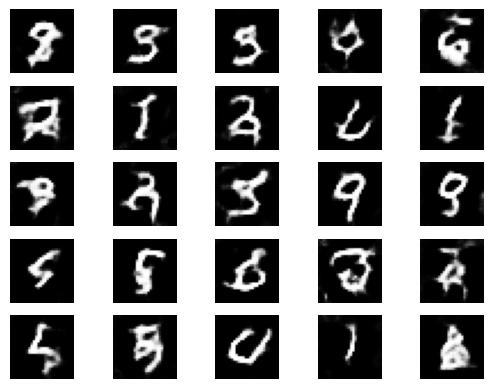

  0%|          | 0/750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 148ms/step


  0%|          | 1/750 [00:00<11:17,  1.11it/s]

1/1 [==============================] - 0s 134ms/step


  0%|          | 2/750 [00:01<11:12,  1.11it/s]

1/1 [==============================] - 0s 135ms/step


  0%|          | 3/750 [00:02<11:19,  1.10it/s]

1/1 [==============================] - 0s 129ms/step


  1%|          | 4/750 [00:03<11:14,  1.11it/s]

1/1 [==============================] - 0s 127ms/step


  1%|          | 5/750 [00:04<11:13,  1.11it/s]

1/1 [==============================] - 0s 131ms/step


  1%|          | 6/750 [00:05<11:09,  1.11it/s]

1/1 [==============================] - 0s 131ms/step


  1%|          | 7/750 [00:06<11:01,  1.12it/s]

1/1 [==============================] - 0s 127ms/step


  1%|          | 8/750 [00:07<11:04,  1.12it/s]

1/1 [==============================] - 0s 143ms/step


  1%|          | 9/750 [00:08<11:04,  1.12it/s]

1/1 [==============================] - 0s 129ms/step


  1%|▏         | 10/750 [00:08<11:05,  1.11it/s]

1/1 [==============================] - 0s 202ms/step


  1%|▏         | 11/750 [00:10<13:03,  1.06s/it]

1/1 [==============================] - 0s 223ms/step


  2%|▏         | 12/750 [00:11<14:29,  1.18s/it]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 13/750 [00:13<15:24,  1.25s/it]

1/1 [==============================] - 0s 206ms/step


  2%|▏         | 14/750 [00:14<15:55,  1.30s/it]

1/1 [==============================] - 0s 211ms/step


  2%|▏         | 15/750 [00:16<16:23,  1.34s/it]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 16/750 [00:17<15:47,  1.29s/it]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 17/750 [00:18<14:14,  1.17s/it]

1/1 [==============================] - 0s 136ms/step


  2%|▏         | 18/750 [00:19<13:16,  1.09s/it]

1/1 [==============================] - 0s 139ms/step


  3%|▎         | 19/750 [00:19<12:32,  1.03s/it]

1/1 [==============================] - 0s 127ms/step


  3%|▎         | 20/750 [00:20<12:01,  1.01it/s]

1/1 [==============================] - 0s 138ms/step


  3%|▎         | 21/750 [00:21<11:41,  1.04it/s]

1/1 [==============================] - 0s 137ms/step


  3%|▎         | 22/750 [00:22<11:29,  1.06it/s]

1/1 [==============================] - 0s 131ms/step


  3%|▎         | 23/750 [00:23<11:20,  1.07it/s]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 24/750 [00:24<11:13,  1.08it/s]

1/1 [==============================] - 0s 134ms/step


  3%|▎         | 25/750 [00:25<11:10,  1.08it/s]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 26/750 [00:26<11:05,  1.09it/s]

1/1 [==============================] - 0s 135ms/step


  4%|▎         | 27/750 [00:27<11:28,  1.05it/s]

1/1 [==============================] - 0s 203ms/step


  4%|▎         | 28/750 [00:28<13:21,  1.11s/it]

1/1 [==============================] - 0s 204ms/step


  4%|▍         | 29/750 [00:30<14:54,  1.24s/it]

1/1 [==============================] - 0s 208ms/step


  4%|▍         | 30/750 [00:31<15:27,  1.29s/it]

1/1 [==============================] - 0s 206ms/step


  4%|▍         | 31/750 [00:33<15:50,  1.32s/it]

1/1 [==============================] - 0s 211ms/step


  4%|▍         | 32/750 [00:34<16:03,  1.34s/it]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 33/750 [00:35<14:47,  1.24s/it]

1/1 [==============================] - 0s 135ms/step


  5%|▍         | 34/750 [00:36<13:36,  1.14s/it]

1/1 [==============================] - 0s 141ms/step


  5%|▍         | 35/750 [00:37<12:43,  1.07s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▍         | 36/750 [00:38<12:06,  1.02s/it]

1/1 [==============================] - 0s 136ms/step


  5%|▍         | 37/750 [00:39<11:39,  1.02it/s]

1/1 [==============================] - 0s 128ms/step


  5%|▌         | 38/750 [00:40<11:21,  1.04it/s]

1/1 [==============================] - 0s 133ms/step


  5%|▌         | 39/750 [00:40<11:12,  1.06it/s]

1/1 [==============================] - 0s 134ms/step


  5%|▌         | 40/750 [00:41<11:04,  1.07it/s]

1/1 [==============================] - 0s 131ms/step


  5%|▌         | 41/750 [00:42<10:58,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


  6%|▌         | 42/750 [00:43<10:54,  1.08it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▌         | 43/750 [00:44<10:45,  1.09it/s]

1/1 [==============================] - 0s 139ms/step


  6%|▌         | 44/750 [00:46<12:37,  1.07s/it]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 45/750 [00:47<13:50,  1.18s/it]

1/1 [==============================] - 0s 215ms/step


  6%|▌         | 46/750 [00:48<14:36,  1.24s/it]

1/1 [==============================] - 0s 210ms/step


  6%|▋         | 47/750 [00:50<15:18,  1.31s/it]

1/1 [==============================] - 0s 212ms/step


  6%|▋         | 48/750 [00:51<15:45,  1.35s/it]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 49/750 [00:52<15:09,  1.30s/it]

1/1 [==============================] - 0s 139ms/step


  7%|▋         | 50/750 [00:53<13:44,  1.18s/it]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 51/750 [00:54<12:48,  1.10s/it]

1/1 [==============================] - 0s 134ms/step


  7%|▋         | 52/750 [00:55<12:04,  1.04s/it]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 53/750 [00:56<11:33,  1.00it/s]

1/1 [==============================] - 0s 136ms/step


  7%|▋         | 54/750 [00:57<11:15,  1.03it/s]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 55/750 [00:58<10:56,  1.06it/s]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 56/750 [00:59<10:41,  1.08it/s]

1/1 [==============================] - 0s 139ms/step


  8%|▊         | 57/750 [01:00<10:31,  1.10it/s]

1/1 [==============================] - 0s 128ms/step


  8%|▊         | 58/750 [01:01<10:25,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


  8%|▊         | 59/750 [01:01<10:21,  1.11it/s]

1/1 [==============================] - 0s 133ms/step


  8%|▊         | 60/750 [01:02<10:56,  1.05it/s]

1/1 [==============================] - 0s 215ms/step


  8%|▊         | 61/750 [01:04<13:29,  1.17s/it]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 62/750 [01:06<14:44,  1.29s/it]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 63/750 [01:07<15:33,  1.36s/it]

1/1 [==============================] - 0s 194ms/step


  9%|▊         | 64/750 [01:09<15:37,  1.37s/it]

1/1 [==============================] - 0s 191ms/step


  9%|▊         | 65/750 [01:10<14:54,  1.31s/it]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 66/750 [01:11<13:30,  1.18s/it]

1/1 [==============================] - 0s 119ms/step


  9%|▉         | 67/750 [01:12<12:26,  1.09s/it]

1/1 [==============================] - 0s 125ms/step


  9%|▉         | 68/750 [01:12<11:41,  1.03s/it]

1/1 [==============================] - 0s 126ms/step


  9%|▉         | 69/750 [01:13<11:15,  1.01it/s]

1/1 [==============================] - 0s 131ms/step


  9%|▉         | 70/750 [01:14<10:54,  1.04it/s]

1/1 [==============================] - 0s 124ms/step


  9%|▉         | 71/750 [01:15<10:38,  1.06it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 72/750 [01:16<10:24,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 10%|▉         | 73/750 [01:17<10:14,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 10%|▉         | 74/750 [01:18<10:09,  1.11it/s]

1/1 [==============================] - 0s 124ms/step


 10%|█         | 75/750 [01:19<10:06,  1.11it/s]

1/1 [==============================] - 0s 125ms/step


 10%|█         | 76/750 [01:20<10:11,  1.10it/s]

1/1 [==============================] - 0s 202ms/step


 10%|█         | 77/750 [01:21<11:54,  1.06s/it]

1/1 [==============================] - 0s 202ms/step


 10%|█         | 78/750 [01:22<13:13,  1.18s/it]

1/1 [==============================] - 0s 198ms/step


 11%|█         | 79/750 [01:24<13:55,  1.24s/it]

1/1 [==============================] - 0s 198ms/step


 11%|█         | 80/750 [01:25<14:38,  1.31s/it]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 81/750 [01:27<14:52,  1.33s/it]

1/1 [==============================] - 0s 218ms/step


 11%|█         | 82/750 [01:28<14:05,  1.27s/it]

1/1 [==============================] - 0s 117ms/step


 11%|█         | 83/750 [01:29<12:47,  1.15s/it]

1/1 [==============================] - 0s 131ms/step


 11%|█         | 84/750 [01:30<11:52,  1.07s/it]

1/1 [==============================] - 0s 122ms/step


 11%|█▏        | 85/750 [01:30<11:15,  1.02s/it]

1/1 [==============================] - 0s 129ms/step


 11%|█▏        | 86/750 [01:31<10:56,  1.01it/s]

1/1 [==============================] - 0s 139ms/step


 12%|█▏        | 87/750 [01:32<10:39,  1.04it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 88/750 [01:33<10:23,  1.06it/s]

1/1 [==============================] - 0s 127ms/step


 12%|█▏        | 89/750 [01:34<10:13,  1.08it/s]

1/1 [==============================] - 0s 137ms/step


 12%|█▏        | 90/750 [01:35<10:04,  1.09it/s]

1/1 [==============================] - 0s 127ms/step


 12%|█▏        | 91/750 [01:36<09:57,  1.10it/s]

1/1 [==============================] - 0s 119ms/step


 12%|█▏        | 92/750 [01:37<09:50,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 12%|█▏        | 93/750 [01:38<10:29,  1.04it/s]

1/1 [==============================] - 0s 198ms/step


 13%|█▎        | 94/750 [01:39<11:59,  1.10s/it]

1/1 [==============================] - 0s 209ms/step


 13%|█▎        | 95/750 [01:41<13:12,  1.21s/it]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 96/750 [01:42<13:57,  1.28s/it]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 97/750 [01:44<14:13,  1.31s/it]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 98/750 [01:45<14:23,  1.32s/it]

1/1 [==============================] - 0s 154ms/step


 13%|█▎        | 99/750 [01:46<13:09,  1.21s/it]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 100/750 [01:47<12:01,  1.11s/it]

1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 101/750 [01:48<11:14,  1.04s/it]

1/1 [==============================] - 0s 132ms/step


 14%|█▎        | 102/750 [01:48<10:40,  1.01it/s]

1/1 [==============================] - 0s 117ms/step


 14%|█▎        | 103/750 [01:49<10:17,  1.05it/s]

1/1 [==============================] - 0s 124ms/step


 14%|█▍        | 104/750 [01:50<10:04,  1.07it/s]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 105/750 [01:51<09:57,  1.08it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 106/750 [01:52<09:50,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 107/750 [01:53<09:44,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 14%|█▍        | 108/750 [01:54<09:39,  1.11it/s]

1/1 [==============================] - 0s 132ms/step


 15%|█▍        | 109/750 [01:55<09:33,  1.12it/s]

1/1 [==============================] - 0s 129ms/step


 15%|█▍        | 110/750 [01:56<10:36,  1.00it/s]

1/1 [==============================] - 0s 205ms/step


 15%|█▍        | 111/750 [01:57<12:11,  1.15s/it]

1/1 [==============================] - 0s 189ms/step


 15%|█▍        | 112/750 [01:59<12:56,  1.22s/it]

1/1 [==============================] - 0s 193ms/step


 15%|█▌        | 113/750 [02:00<13:27,  1.27s/it]

1/1 [==============================] - 0s 189ms/step


 15%|█▌        | 114/750 [02:02<13:51,  1.31s/it]

1/1 [==============================] - 0s 196ms/step


 15%|█▌        | 115/750 [02:03<13:56,  1.32s/it]

1/1 [==============================] - 0s 123ms/step


 15%|█▌        | 116/750 [02:04<12:35,  1.19s/it]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 117/750 [02:05<11:39,  1.10s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█▌        | 118/750 [02:06<10:54,  1.04s/it]

1/1 [==============================] - 0s 121ms/step


 16%|█▌        | 119/750 [02:07<10:23,  1.01it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 120/750 [02:07<09:59,  1.05it/s]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 121/750 [02:08<09:46,  1.07it/s]

1/1 [==============================] - 0s 121ms/step


 16%|█▋        | 122/750 [02:09<09:41,  1.08it/s]

1/1 [==============================] - 0s 117ms/step


 16%|█▋        | 123/750 [02:10<09:30,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 17%|█▋        | 124/750 [02:11<09:25,  1.11it/s]

1/1 [==============================] - 0s 115ms/step


 17%|█▋        | 125/750 [02:12<09:19,  1.12it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 126/750 [02:13<09:19,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 127/750 [02:14<10:29,  1.01s/it]

1/1 [==============================] - 0s 195ms/step


 17%|█▋        | 128/750 [02:15<11:44,  1.13s/it]

1/1 [==============================] - 0s 190ms/step


 17%|█▋        | 129/750 [02:17<12:29,  1.21s/it]

1/1 [==============================] - 0s 216ms/step


 17%|█▋        | 130/750 [02:18<13:11,  1.28s/it]

1/1 [==============================] - 0s 195ms/step


 17%|█▋        | 131/750 [02:20<13:36,  1.32s/it]

1/1 [==============================] - 0s 194ms/step


 18%|█▊        | 132/750 [02:21<13:29,  1.31s/it]

1/1 [==============================] - 0s 135ms/step


 18%|█▊        | 133/750 [02:22<12:08,  1.18s/it]

1/1 [==============================] - 0s 116ms/step


 18%|█▊        | 134/750 [02:23<11:16,  1.10s/it]

1/1 [==============================] - 0s 118ms/step


 18%|█▊        | 135/750 [02:24<10:59,  1.07s/it]

1/1 [==============================] - 0s 130ms/step


 18%|█▊        | 136/750 [02:25<10:26,  1.02s/it]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 137/750 [02:26<10:00,  1.02it/s]

1/1 [==============================] - 0s 118ms/step


 18%|█▊        | 138/750 [02:26<09:40,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▊        | 139/750 [02:27<09:35,  1.06it/s]

1/1 [==============================] - 0s 126ms/step


 19%|█▊        | 140/750 [02:28<09:23,  1.08it/s]

1/1 [==============================] - 0s 133ms/step


 19%|█▉        | 141/750 [02:29<09:17,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 142/750 [02:30<09:10,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▉        | 143/750 [02:31<09:12,  1.10it/s]

1/1 [==============================] - 0s 196ms/step


 19%|█▉        | 144/750 [02:32<10:50,  1.07s/it]

1/1 [==============================] - 0s 215ms/step


 19%|█▉        | 145/750 [02:34<12:05,  1.20s/it]

1/1 [==============================] - 0s 225ms/step


 19%|█▉        | 146/750 [02:35<12:52,  1.28s/it]

1/1 [==============================] - 0s 197ms/step


 20%|█▉        | 147/750 [02:37<13:11,  1.31s/it]

1/1 [==============================] - 0s 201ms/step


 20%|█▉        | 148/750 [02:38<13:26,  1.34s/it]

1/1 [==============================] - 0s 200ms/step


 20%|█▉        | 149/750 [02:39<12:41,  1.27s/it]

1/1 [==============================] - 0s 126ms/step


 20%|██        | 150/750 [02:40<11:32,  1.15s/it]

1/1 [==============================] - 0s 131ms/step


 20%|██        | 151/750 [02:41<10:42,  1.07s/it]

1/1 [==============================] - 0s 118ms/step


 20%|██        | 152/750 [02:42<10:02,  1.01s/it]

1/1 [==============================] - 0s 122ms/step


 20%|██        | 153/750 [02:43<09:38,  1.03it/s]

1/1 [==============================] - 0s 119ms/step


 21%|██        | 154/750 [02:44<09:22,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██        | 155/750 [02:44<09:09,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██        | 156/750 [02:45<09:03,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██        | 157/750 [02:46<09:02,  1.09it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 158/750 [02:47<08:59,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██        | 159/750 [02:48<08:51,  1.11it/s]

1/1 [==============================] - 0s 126ms/step


 21%|██▏       | 160/750 [02:49<09:31,  1.03it/s]

1/1 [==============================] - 0s 196ms/step


 21%|██▏       | 161/750 [02:51<10:52,  1.11s/it]

1/1 [==============================] - 0s 201ms/step


 22%|██▏       | 162/750 [02:52<11:33,  1.18s/it]

1/1 [==============================] - 0s 187ms/step


 22%|██▏       | 163/750 [02:53<12:06,  1.24s/it]

1/1 [==============================] - 0s 206ms/step


 22%|██▏       | 164/750 [02:55<12:32,  1.28s/it]

1/1 [==============================] - 0s 201ms/step


 22%|██▏       | 165/750 [02:56<12:52,  1.32s/it]

1/1 [==============================] - 0s 197ms/step


 22%|██▏       | 166/750 [02:57<12:08,  1.25s/it]

1/1 [==============================] - 0s 127ms/step


 22%|██▏       | 167/750 [02:58<11:08,  1.15s/it]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 168/750 [02:59<10:22,  1.07s/it]

1/1 [==============================] - 0s 121ms/step


 23%|██▎       | 169/750 [03:00<09:48,  1.01s/it]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 170/750 [03:01<09:25,  1.03it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 171/750 [03:02<09:11,  1.05it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 172/750 [03:03<08:57,  1.08it/s]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 173/750 [03:03<08:47,  1.09it/s]

1/1 [==============================] - 0s 117ms/step


 23%|██▎       | 174/750 [03:04<08:43,  1.10it/s]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 175/750 [03:05<08:42,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 176/750 [03:06<08:39,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 24%|██▎       | 177/750 [03:07<09:13,  1.04it/s]

1/1 [==============================] - 0s 205ms/step


 24%|██▎       | 178/750 [03:09<10:52,  1.14s/it]

1/1 [==============================] - 0s 209ms/step


 24%|██▍       | 179/750 [03:10<11:50,  1.24s/it]

1/1 [==============================] - 0s 212ms/step


 24%|██▍       | 180/750 [03:12<12:30,  1.32s/it]

1/1 [==============================] - 0s 213ms/step


 24%|██▍       | 181/750 [03:13<12:54,  1.36s/it]

1/1 [==============================] - 0s 202ms/step


 24%|██▍       | 182/750 [03:15<12:45,  1.35s/it]

1/1 [==============================] - 0s 126ms/step


 24%|██▍       | 183/750 [03:15<11:30,  1.22s/it]

1/1 [==============================] - 0s 120ms/step


 25%|██▍       | 184/750 [03:16<10:35,  1.12s/it]

1/1 [==============================] - 0s 124ms/step


 25%|██▍       | 185/750 [03:17<09:55,  1.05s/it]

1/1 [==============================] - 0s 132ms/step


 25%|██▍       | 186/750 [03:18<09:28,  1.01s/it]

1/1 [==============================] - 0s 133ms/step


 25%|██▍       | 187/750 [03:19<09:08,  1.03it/s]

1/1 [==============================] - 0s 126ms/step


 25%|██▌       | 188/750 [03:20<08:54,  1.05it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▌       | 189/750 [03:21<08:44,  1.07it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▌       | 190/750 [03:22<08:38,  1.08it/s]

1/1 [==============================] - 0s 135ms/step


 25%|██▌       | 191/750 [03:23<08:32,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 26%|██▌       | 192/750 [03:24<08:26,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 26%|██▌       | 193/750 [03:25<08:47,  1.06it/s]

1/1 [==============================] - 0s 202ms/step


 26%|██▌       | 194/750 [03:26<10:23,  1.12s/it]

1/1 [==============================] - 0s 206ms/step


 26%|██▌       | 195/750 [03:27<11:07,  1.20s/it]

1/1 [==============================] - 0s 204ms/step


 26%|██▌       | 196/750 [03:29<11:36,  1.26s/it]

1/1 [==============================] - 0s 202ms/step


 26%|██▋       | 197/750 [03:30<11:58,  1.30s/it]

1/1 [==============================] - 0s 200ms/step


 26%|██▋       | 198/750 [03:32<12:29,  1.36s/it]

1/1 [==============================] - 0s 199ms/step


 27%|██▋       | 199/750 [03:33<11:41,  1.27s/it]

1/1 [==============================] - 0s 138ms/step


 27%|██▋       | 200/750 [03:34<10:38,  1.16s/it]

1/1 [==============================] - 0s 127ms/step


 27%|██▋       | 201/750 [03:35<09:53,  1.08s/it]

1/1 [==============================] - 0s 145ms/step


 27%|██▋       | 202/750 [03:36<09:28,  1.04s/it]

1/1 [==============================] - 0s 127ms/step


 27%|██▋       | 203/750 [03:36<09:06,  1.00it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 204/750 [03:37<08:48,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 205/750 [03:38<08:34,  1.06it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 206/750 [03:39<08:23,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


 28%|██▊       | 207/750 [03:40<08:20,  1.09it/s]

1/1 [==============================] - 0s 134ms/step


 28%|██▊       | 208/750 [03:41<08:14,  1.10it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 209/750 [03:42<08:07,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 210/750 [03:43<08:48,  1.02it/s]

1/1 [==============================] - 0s 210ms/step


 28%|██▊       | 211/750 [03:44<10:15,  1.14s/it]

1/1 [==============================] - 0s 209ms/step


 28%|██▊       | 212/750 [03:46<11:02,  1.23s/it]

1/1 [==============================] - 0s 204ms/step


 28%|██▊       | 213/750 [03:47<11:34,  1.29s/it]

1/1 [==============================] - 0s 199ms/step


 29%|██▊       | 214/750 [03:49<11:54,  1.33s/it]

1/1 [==============================] - 0s 194ms/step


 29%|██▊       | 215/750 [03:50<11:54,  1.34s/it]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 216/750 [03:51<10:42,  1.20s/it]

1/1 [==============================] - 0s 126ms/step


 29%|██▉       | 217/750 [03:52<09:51,  1.11s/it]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 218/750 [03:53<09:15,  1.04s/it]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 219/750 [03:54<08:48,  1.00it/s]

1/1 [==============================] - 0s 139ms/step


 29%|██▉       | 220/750 [03:55<08:36,  1.03it/s]

1/1 [==============================] - 0s 130ms/step


 29%|██▉       | 221/750 [03:56<08:27,  1.04it/s]

1/1 [==============================] - 0s 134ms/step


 30%|██▉       | 222/750 [03:56<08:19,  1.06it/s]

1/1 [==============================] - 0s 121ms/step


 30%|██▉       | 223/750 [03:57<08:13,  1.07it/s]

1/1 [==============================] - 0s 123ms/step


 30%|██▉       | 224/750 [03:58<08:04,  1.09it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 225/750 [03:59<08:02,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 226/750 [04:00<07:56,  1.10it/s]

1/1 [==============================] - 0s 203ms/step


 30%|███       | 227/750 [04:02<09:21,  1.07s/it]

1/1 [==============================] - 0s 214ms/step


 30%|███       | 228/750 [04:03<10:13,  1.17s/it]

1/1 [==============================] - 0s 215ms/step


 31%|███       | 229/750 [04:04<10:55,  1.26s/it]

1/1 [==============================] - 0s 197ms/step


 31%|███       | 230/750 [04:06<11:07,  1.28s/it]

1/1 [==============================] - 0s 200ms/step


 31%|███       | 231/750 [04:07<11:32,  1.33s/it]

1/1 [==============================] - 0s 200ms/step


 31%|███       | 232/750 [04:08<11:16,  1.31s/it]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 233/750 [04:09<10:13,  1.19s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███       | 234/750 [04:10<09:25,  1.10s/it]

1/1 [==============================] - 0s 117ms/step


 31%|███▏      | 235/750 [04:11<08:51,  1.03s/it]

1/1 [==============================] - 0s 123ms/step


 31%|███▏      | 236/750 [04:12<08:29,  1.01it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 237/750 [04:13<08:18,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 238/750 [04:14<08:05,  1.05it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 239/750 [04:15<07:55,  1.07it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 240/750 [04:16<07:49,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 241/750 [04:16<07:44,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 242/750 [04:17<07:41,  1.10it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 243/750 [04:18<07:46,  1.09it/s]

1/1 [==============================] - 0s 217ms/step


 33%|███▎      | 244/750 [04:20<09:08,  1.08s/it]

1/1 [==============================] - 0s 219ms/step


 33%|███▎      | 245/750 [04:21<10:06,  1.20s/it]

1/1 [==============================] - 0s 203ms/step


 33%|███▎      | 246/750 [04:23<10:53,  1.30s/it]

1/1 [==============================] - 0s 196ms/step


 33%|███▎      | 247/750 [04:24<11:08,  1.33s/it]

1/1 [==============================] - 0s 201ms/step


 33%|███▎      | 248/750 [04:26<11:30,  1.38s/it]

1/1 [==============================] - 0s 140ms/step


 33%|███▎      | 249/750 [04:27<10:28,  1.25s/it]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 250/750 [04:28<09:35,  1.15s/it]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 251/750 [04:28<08:55,  1.07s/it]

1/1 [==============================] - 0s 125ms/step


 34%|███▎      | 252/750 [04:29<08:28,  1.02s/it]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 253/750 [04:30<08:04,  1.03it/s]

1/1 [==============================] - 0s 130ms/step


 34%|███▍      | 254/750 [04:31<07:49,  1.06it/s]

1/1 [==============================] - 0s 139ms/step


 34%|███▍      | 255/750 [04:32<07:45,  1.06it/s]

1/1 [==============================] - 0s 129ms/step


 34%|███▍      | 256/750 [04:33<07:37,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


 34%|███▍      | 257/750 [04:34<07:33,  1.09it/s]

1/1 [==============================] - 0s 131ms/step


 34%|███▍      | 258/750 [04:35<07:28,  1.10it/s]

1/1 [==============================] - 0s 129ms/step


 35%|███▍      | 259/750 [04:36<07:25,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 260/750 [04:37<08:27,  1.04s/it]

1/1 [==============================] - 0s 198ms/step


 35%|███▍      | 261/750 [04:38<09:27,  1.16s/it]

1/1 [==============================] - 0s 203ms/step


 35%|███▍      | 262/750 [04:40<10:00,  1.23s/it]

1/1 [==============================] - 0s 192ms/step


 35%|███▌      | 263/750 [04:41<10:13,  1.26s/it]

1/1 [==============================] - 0s 196ms/step


 35%|███▌      | 264/750 [04:43<10:29,  1.30s/it]

1/1 [==============================] - 0s 196ms/step


 35%|███▌      | 265/750 [04:44<10:37,  1.31s/it]

1/1 [==============================] - 0s 135ms/step


 35%|███▌      | 266/750 [04:45<09:35,  1.19s/it]

1/1 [==============================] - 0s 129ms/step


 36%|███▌      | 267/750 [04:46<08:50,  1.10s/it]

1/1 [==============================] - 0s 120ms/step


 36%|███▌      | 268/750 [04:47<08:17,  1.03s/it]

1/1 [==============================] - 0s 121ms/step


 36%|███▌      | 269/750 [04:47<07:55,  1.01it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 270/750 [04:48<07:43,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 36%|███▌      | 271/750 [04:49<07:31,  1.06it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▋      | 272/750 [04:50<07:23,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


 36%|███▋      | 273/750 [04:51<07:15,  1.09it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 274/750 [04:52<07:11,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 275/750 [04:53<07:07,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 37%|███▋      | 276/750 [04:54<07:04,  1.12it/s]

1/1 [==============================] - 0s 120ms/step


 37%|███▋      | 277/750 [04:55<07:57,  1.01s/it]

1/1 [==============================] - 0s 206ms/step


 37%|███▋      | 278/750 [04:56<09:07,  1.16s/it]

1/1 [==============================] - 0s 197ms/step


 37%|███▋      | 279/750 [04:58<09:40,  1.23s/it]

1/1 [==============================] - 0s 198ms/step


 37%|███▋      | 280/750 [04:59<10:01,  1.28s/it]

1/1 [==============================] - 0s 203ms/step


 37%|███▋      | 281/750 [05:01<10:18,  1.32s/it]

1/1 [==============================] - 0s 195ms/step


 38%|███▊      | 282/750 [05:02<10:23,  1.33s/it]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 283/750 [05:03<09:19,  1.20s/it]

1/1 [==============================] - 0s 116ms/step


 38%|███▊      | 284/750 [05:04<08:32,  1.10s/it]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 285/750 [05:05<07:58,  1.03s/it]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 286/750 [05:06<07:37,  1.01it/s]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 287/750 [05:06<07:24,  1.04it/s]

1/1 [==============================] - 0s 117ms/step


 38%|███▊      | 288/750 [05:07<07:10,  1.07it/s]

1/1 [==============================] - 0s 120ms/step


 39%|███▊      | 289/750 [05:08<07:03,  1.09it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▊      | 290/750 [05:09<06:59,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███▉      | 291/750 [05:10<06:52,  1.11it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███▉      | 292/750 [05:11<06:52,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▉      | 293/750 [05:12<06:48,  1.12it/s]

1/1 [==============================] - 0s 186ms/step


 39%|███▉      | 294/750 [05:13<07:59,  1.05s/it]

1/1 [==============================] - 0s 186ms/step


 39%|███▉      | 295/750 [05:14<08:41,  1.15s/it]

1/1 [==============================] - 0s 195ms/step


 39%|███▉      | 296/750 [05:16<09:14,  1.22s/it]

1/1 [==============================] - 0s 199ms/step


 40%|███▉      | 297/750 [05:17<09:33,  1.27s/it]

1/1 [==============================] - 0s 201ms/step


 40%|███▉      | 298/750 [05:19<09:49,  1.30s/it]

1/1 [==============================] - 0s 199ms/step


 40%|███▉      | 299/750 [05:20<09:55,  1.32s/it]

1/1 [==============================] - 0s 137ms/step


 40%|████      | 300/750 [05:21<08:59,  1.20s/it]

1/1 [==============================] - 0s 124ms/step


 40%|████      | 301/750 [05:22<08:21,  1.12s/it]

1/1 [==============================] - 0s 122ms/step


 40%|████      | 302/750 [05:23<07:52,  1.05s/it]

1/1 [==============================] - 0s 129ms/step


 40%|████      | 303/750 [05:24<07:29,  1.01s/it]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 304/750 [05:25<07:16,  1.02it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████      | 305/750 [05:25<07:02,  1.05it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 306/750 [05:26<06:52,  1.08it/s]

1/1 [==============================] - 0s 132ms/step


 41%|████      | 307/750 [05:27<06:46,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████      | 308/750 [05:28<06:44,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 309/750 [05:29<06:43,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████▏     | 310/750 [05:30<06:40,  1.10it/s]

1/1 [==============================] - 0s 201ms/step


 41%|████▏     | 311/750 [05:31<07:51,  1.07s/it]

1/1 [==============================] - 0s 216ms/step


 42%|████▏     | 312/750 [05:33<08:34,  1.17s/it]

1/1 [==============================] - 0s 201ms/step


 42%|████▏     | 313/750 [05:34<09:06,  1.25s/it]

1/1 [==============================] - 0s 209ms/step


 42%|████▏     | 314/750 [05:36<09:33,  1.32s/it]

1/1 [==============================] - 0s 195ms/step


 42%|████▏     | 315/750 [05:37<09:38,  1.33s/it]

1/1 [==============================] - 0s 196ms/step


 42%|████▏     | 316/750 [05:38<09:19,  1.29s/it]

1/1 [==============================] - 0s 131ms/step


 42%|████▏     | 317/750 [05:39<08:29,  1.18s/it]

1/1 [==============================] - 0s 121ms/step


 42%|████▏     | 318/750 [05:40<07:52,  1.09s/it]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 319/750 [05:41<07:23,  1.03s/it]

1/1 [==============================] - 0s 134ms/step


 43%|████▎     | 320/750 [05:42<07:06,  1.01it/s]

1/1 [==============================] - 0s 131ms/step


 43%|████▎     | 321/750 [05:43<06:52,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 322/750 [05:44<06:43,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 323/750 [05:45<06:36,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 324/750 [05:45<06:29,  1.09it/s]

1/1 [==============================] - 0s 126ms/step


 43%|████▎     | 325/750 [05:46<06:26,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 326/750 [05:47<06:23,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▎     | 327/750 [05:48<06:24,  1.10it/s]

1/1 [==============================] - 0s 208ms/step


 44%|████▎     | 328/750 [05:50<07:40,  1.09s/it]

1/1 [==============================] - 0s 210ms/step


 44%|████▍     | 329/750 [05:51<08:20,  1.19s/it]

1/1 [==============================] - 0s 197ms/step


 44%|████▍     | 330/750 [05:53<08:58,  1.28s/it]

1/1 [==============================] - 0s 191ms/step


 44%|████▍     | 331/750 [05:54<09:14,  1.32s/it]

1/1 [==============================] - 0s 186ms/step


 44%|████▍     | 332/750 [05:55<09:20,  1.34s/it]

1/1 [==============================] - 0s 195ms/step


 44%|████▍     | 333/750 [05:56<08:39,  1.25s/it]

1/1 [==============================] - 0s 118ms/step


 45%|████▍     | 334/750 [05:57<07:53,  1.14s/it]

1/1 [==============================] - 0s 122ms/step


 45%|████▍     | 335/750 [05:58<07:23,  1.07s/it]

1/1 [==============================] - 0s 125ms/step


 45%|████▍     | 336/750 [05:59<07:00,  1.02s/it]

1/1 [==============================] - 0s 125ms/step


 45%|████▍     | 337/750 [06:00<06:45,  1.02it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▌     | 338/750 [06:01<06:33,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▌     | 339/750 [06:02<06:23,  1.07it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▌     | 340/750 [06:03<06:18,  1.08it/s]

1/1 [==============================] - 0s 133ms/step


 45%|████▌     | 341/750 [06:04<06:12,  1.10it/s]

1/1 [==============================] - 0s 127ms/step


 46%|████▌     | 342/750 [06:04<06:12,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████▌     | 343/750 [06:05<06:11,  1.10it/s]

1/1 [==============================] - 0s 126ms/step


 46%|████▌     | 344/750 [06:07<06:39,  1.02it/s]

1/1 [==============================] - 0s 200ms/step


 46%|████▌     | 345/750 [06:08<07:38,  1.13s/it]

1/1 [==============================] - 0s 204ms/step


 46%|████▌     | 346/750 [06:09<08:14,  1.22s/it]

1/1 [==============================] - 0s 189ms/step


 46%|████▋     | 347/750 [06:11<08:31,  1.27s/it]

1/1 [==============================] - 0s 207ms/step


 46%|████▋     | 348/750 [06:12<08:43,  1.30s/it]

1/1 [==============================] - 0s 212ms/step


 47%|████▋     | 349/750 [06:14<08:58,  1.34s/it]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 350/750 [06:15<08:03,  1.21s/it]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 351/750 [06:15<07:23,  1.11s/it]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 352/750 [06:16<06:54,  1.04s/it]

1/1 [==============================] - 0s 130ms/step


 47%|████▋     | 353/750 [06:17<06:37,  1.00s/it]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 354/750 [06:18<06:22,  1.04it/s]

1/1 [==============================] - 0s 126ms/step


 47%|████▋     | 355/750 [06:19<06:12,  1.06it/s]

1/1 [==============================] - 0s 126ms/step


 47%|████▋     | 356/750 [06:20<06:05,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


 48%|████▊     | 357/750 [06:21<06:01,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 48%|████▊     | 358/750 [06:22<05:57,  1.10it/s]

1/1 [==============================] - 0s 126ms/step


 48%|████▊     | 359/750 [06:23<05:52,  1.11it/s]

1/1 [==============================] - 0s 124ms/step


 48%|████▊     | 360/750 [06:23<05:51,  1.11it/s]

1/1 [==============================] - 0s 131ms/step


 48%|████▊     | 361/750 [06:25<06:41,  1.03s/it]

1/1 [==============================] - 0s 194ms/step


 48%|████▊     | 362/750 [06:26<07:28,  1.16s/it]

1/1 [==============================] - 0s 199ms/step


 48%|████▊     | 363/750 [06:28<07:44,  1.20s/it]

1/1 [==============================] - 0s 201ms/step


 49%|████▊     | 364/750 [06:29<08:04,  1.26s/it]

1/1 [==============================] - 0s 217ms/step


 49%|████▊     | 365/750 [06:30<08:24,  1.31s/it]

1/1 [==============================] - 0s 202ms/step


 49%|████▉     | 366/750 [06:32<08:31,  1.33s/it]

1/1 [==============================] - 0s 116ms/step


 49%|████▉     | 367/750 [06:33<07:38,  1.20s/it]

1/1 [==============================] - 0s 121ms/step


 49%|████▉     | 368/750 [06:34<07:03,  1.11s/it]

1/1 [==============================] - 0s 131ms/step


 49%|████▉     | 369/750 [06:34<06:40,  1.05s/it]

1/1 [==============================] - 0s 132ms/step


 49%|████▉     | 370/750 [06:35<06:22,  1.01s/it]

1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 371/750 [06:36<06:07,  1.03it/s]

1/1 [==============================] - 0s 123ms/step


 50%|████▉     | 372/750 [06:37<05:56,  1.06it/s]

1/1 [==============================] - 0s 120ms/step


 50%|████▉     | 373/750 [06:38<05:49,  1.08it/s]

1/1 [==============================] - 0s 136ms/step


 50%|████▉     | 374/750 [06:39<05:45,  1.09it/s]

1/1 [==============================] - 0s 127ms/step


 50%|█████     | 375/750 [06:40<05:40,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 50%|█████     | 376/750 [06:41<05:35,  1.11it/s]

1/1 [==============================] - 0s 123ms/step


 50%|█████     | 377/750 [06:42<05:34,  1.12it/s]

1/1 [==============================] - 0s 152ms/step


 50%|█████     | 378/750 [06:43<06:30,  1.05s/it]

1/1 [==============================] - 0s 213ms/step


 51%|█████     | 379/750 [06:44<07:19,  1.18s/it]

1/1 [==============================] - 0s 192ms/step


 51%|█████     | 380/750 [06:46<07:38,  1.24s/it]

1/1 [==============================] - 0s 197ms/step


 51%|█████     | 381/750 [06:47<07:52,  1.28s/it]

1/1 [==============================] - 0s 188ms/step


 51%|█████     | 382/750 [06:49<08:08,  1.33s/it]

1/1 [==============================] - 0s 194ms/step


 51%|█████     | 383/750 [06:50<07:55,  1.30s/it]

1/1 [==============================] - 0s 121ms/step


 51%|█████     | 384/750 [06:51<07:11,  1.18s/it]

1/1 [==============================] - 0s 117ms/step


 51%|█████▏    | 385/750 [06:52<06:37,  1.09s/it]

1/1 [==============================] - 0s 131ms/step


 51%|█████▏    | 386/750 [06:53<06:14,  1.03s/it]

1/1 [==============================] - 0s 124ms/step


 52%|█████▏    | 387/750 [06:53<06:00,  1.01it/s]

1/1 [==============================] - 0s 123ms/step


 52%|█████▏    | 388/750 [06:54<05:47,  1.04it/s]

1/1 [==============================] - 0s 120ms/step


 52%|█████▏    | 389/750 [06:55<05:37,  1.07it/s]

1/1 [==============================] - 0s 119ms/step


 52%|█████▏    | 390/750 [06:56<05:30,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 52%|█████▏    | 391/750 [06:57<05:25,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 52%|█████▏    | 392/750 [06:58<05:22,  1.11it/s]

1/1 [==============================] - 0s 128ms/step


 52%|█████▏    | 393/750 [06:59<05:20,  1.11it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 394/750 [07:00<05:26,  1.09it/s]

1/1 [==============================] - 0s 197ms/step


 53%|█████▎    | 395/750 [07:01<06:27,  1.09s/it]

1/1 [==============================] - 0s 198ms/step


 53%|█████▎    | 396/750 [07:03<07:02,  1.19s/it]

1/1 [==============================] - 0s 199ms/step


 53%|█████▎    | 397/750 [07:04<07:20,  1.25s/it]

1/1 [==============================] - 0s 209ms/step


 53%|█████▎    | 398/750 [07:05<07:42,  1.31s/it]

1/1 [==============================] - 0s 190ms/step


 53%|█████▎    | 399/750 [07:07<07:43,  1.32s/it]

1/1 [==============================] - 0s 196ms/step


 53%|█████▎    | 400/750 [07:08<07:25,  1.27s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████▎    | 401/750 [07:09<06:42,  1.15s/it]

1/1 [==============================] - 0s 117ms/step


 54%|█████▎    | 402/750 [07:10<06:12,  1.07s/it]

1/1 [==============================] - 0s 123ms/step


 54%|█████▎    | 403/750 [07:11<05:51,  1.01s/it]

1/1 [==============================] - 0s 119ms/step


 54%|█████▍    | 404/750 [07:11<05:39,  1.02it/s]

1/1 [==============================] - 0s 117ms/step


 54%|█████▍    | 405/750 [07:12<05:27,  1.05it/s]

1/1 [==============================] - 0s 130ms/step


 54%|█████▍    | 406/750 [07:13<05:19,  1.08it/s]

1/1 [==============================] - 0s 127ms/step


 54%|█████▍    | 407/750 [07:14<05:13,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████▍    | 408/750 [07:15<05:10,  1.10it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▍    | 409/750 [07:16<05:07,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████▍    | 410/750 [07:17<05:04,  1.12it/s]

1/1 [==============================] - 0s 117ms/step


 55%|█████▍    | 411/750 [07:18<05:07,  1.10it/s]

1/1 [==============================] - 0s 197ms/step


 55%|█████▍    | 412/750 [07:19<06:01,  1.07s/it]

1/1 [==============================] - 0s 199ms/step


 55%|█████▌    | 413/750 [07:21<06:42,  1.19s/it]

1/1 [==============================] - 0s 199ms/step


 55%|█████▌    | 414/750 [07:22<07:13,  1.29s/it]

1/1 [==============================] - 0s 201ms/step


 55%|█████▌    | 415/750 [07:24<07:19,  1.31s/it]

1/1 [==============================] - 0s 196ms/step


 55%|█████▌    | 416/750 [07:25<07:33,  1.36s/it]

1/1 [==============================] - 0s 199ms/step


 56%|█████▌    | 417/750 [07:26<07:01,  1.27s/it]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 418/750 [07:27<06:19,  1.14s/it]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 419/750 [07:28<05:52,  1.06s/it]

1/1 [==============================] - 0s 128ms/step


 56%|█████▌    | 420/750 [07:29<05:35,  1.02s/it]

1/1 [==============================] - 0s 118ms/step


 56%|█████▌    | 421/750 [07:30<05:21,  1.02it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▋    | 422/750 [07:30<05:12,  1.05it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▋    | 423/750 [07:31<05:05,  1.07it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 424/750 [07:32<05:03,  1.07it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 425/750 [07:33<04:59,  1.09it/s]

1/1 [==============================] - 0s 130ms/step


 57%|█████▋    | 426/750 [07:34<04:54,  1.10it/s]

1/1 [==============================] - 0s 130ms/step


 57%|█████▋    | 427/750 [07:35<04:53,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 428/750 [07:36<05:22,  1.00s/it]

1/1 [==============================] - 0s 198ms/step


 57%|█████▋    | 429/750 [07:38<06:09,  1.15s/it]

1/1 [==============================] - 0s 210ms/step


 57%|█████▋    | 430/750 [07:39<06:34,  1.23s/it]

1/1 [==============================] - 0s 186ms/step


 57%|█████▋    | 431/750 [07:40<06:45,  1.27s/it]

1/1 [==============================] - 0s 193ms/step


 58%|█████▊    | 432/750 [07:42<07:01,  1.33s/it]

1/1 [==============================] - 0s 207ms/step


 58%|█████▊    | 433/750 [07:43<07:01,  1.33s/it]

1/1 [==============================] - 0s 116ms/step


 58%|█████▊    | 434/750 [07:44<06:16,  1.19s/it]

1/1 [==============================] - 0s 117ms/step


 58%|█████▊    | 435/750 [07:45<05:47,  1.10s/it]

1/1 [==============================] - 0s 119ms/step


 58%|█████▊    | 436/750 [07:46<05:24,  1.03s/it]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 437/750 [07:47<05:08,  1.01it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 438/750 [07:48<04:57,  1.05it/s]

1/1 [==============================] - 0s 141ms/step


 59%|█████▊    | 439/750 [07:49<04:52,  1.06it/s]

1/1 [==============================] - 0s 120ms/step


 59%|█████▊    | 440/750 [07:49<04:46,  1.08it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████▉    | 441/750 [07:50<04:42,  1.09it/s]

1/1 [==============================] - 0s 132ms/step


 59%|█████▉    | 442/750 [07:51<04:41,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 59%|█████▉    | 443/750 [07:52<04:38,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 444/750 [07:53<04:37,  1.10it/s]

1/1 [==============================] - 0s 171ms/step


 59%|█████▉    | 445/750 [07:54<05:23,  1.06s/it]

1/1 [==============================] - 0s 199ms/step


 59%|█████▉    | 446/750 [07:56<06:03,  1.20s/it]

1/1 [==============================] - 0s 205ms/step


 60%|█████▉    | 447/750 [07:57<06:18,  1.25s/it]

1/1 [==============================] - 0s 191ms/step


 60%|█████▉    | 448/750 [07:59<06:43,  1.34s/it]

1/1 [==============================] - 0s 228ms/step


 60%|█████▉    | 449/750 [08:00<06:48,  1.36s/it]

1/1 [==============================] - 0s 193ms/step


 60%|██████    | 450/750 [08:01<06:22,  1.28s/it]

1/1 [==============================] - 0s 121ms/step


 60%|██████    | 451/750 [08:02<05:46,  1.16s/it]

1/1 [==============================] - 0s 131ms/step


 60%|██████    | 452/750 [08:03<05:22,  1.08s/it]

1/1 [==============================] - 0s 117ms/step


 60%|██████    | 453/750 [08:04<05:04,  1.02s/it]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 454/750 [08:05<04:51,  1.02it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████    | 455/750 [08:06<04:40,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 61%|██████    | 456/750 [08:07<04:33,  1.08it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████    | 457/750 [08:08<04:27,  1.10it/s]

1/1 [==============================] - 0s 119ms/step


 61%|██████    | 458/750 [08:08<04:22,  1.11it/s]

1/1 [==============================] - 0s 135ms/step


 61%|██████    | 459/750 [08:09<04:20,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 61%|██████▏   | 460/750 [08:10<04:20,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 61%|██████▏   | 461/750 [08:11<04:29,  1.07it/s]

1/1 [==============================] - 0s 190ms/step


 62%|██████▏   | 462/750 [08:13<05:14,  1.09s/it]

1/1 [==============================] - 0s 202ms/step


 62%|██████▏   | 463/750 [08:14<05:38,  1.18s/it]

1/1 [==============================] - 0s 205ms/step


 62%|██████▏   | 464/750 [08:16<06:03,  1.27s/it]

1/1 [==============================] - 0s 199ms/step


 62%|██████▏   | 465/750 [08:17<06:11,  1.30s/it]

1/1 [==============================] - 0s 197ms/step


 62%|██████▏   | 466/750 [08:18<06:18,  1.33s/it]

1/1 [==============================] - 0s 196ms/step


 62%|██████▏   | 467/750 [08:20<05:59,  1.27s/it]

1/1 [==============================] - 0s 120ms/step


 62%|██████▏   | 468/750 [08:20<05:25,  1.16s/it]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 469/750 [08:21<05:02,  1.08s/it]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 470/750 [08:22<04:45,  1.02s/it]

1/1 [==============================] - 0s 131ms/step


 63%|██████▎   | 471/750 [08:23<04:33,  1.02it/s]

1/1 [==============================] - 0s 139ms/step


 63%|██████▎   | 472/750 [08:24<04:25,  1.05it/s]

1/1 [==============================] - 0s 133ms/step


 63%|██████▎   | 473/750 [08:25<04:19,  1.07it/s]

1/1 [==============================] - 0s 124ms/step


 63%|██████▎   | 474/750 [08:26<04:14,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 475/750 [08:27<04:10,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 476/750 [08:28<04:08,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████▎   | 477/750 [08:28<04:07,  1.10it/s]

1/1 [==============================] - 0s 117ms/step


 64%|██████▎   | 478/750 [08:30<04:22,  1.04it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████▍   | 479/750 [08:31<04:57,  1.10s/it]

1/1 [==============================] - 0s 206ms/step


 64%|██████▍   | 480/750 [08:32<05:30,  1.22s/it]

1/1 [==============================] - 0s 178ms/step


 64%|██████▍   | 481/750 [08:34<05:40,  1.27s/it]

1/1 [==============================] - 0s 189ms/step


 64%|██████▍   | 482/750 [08:35<05:51,  1.31s/it]

1/1 [==============================] - 0s 194ms/step


 64%|██████▍   | 483/750 [08:37<05:58,  1.34s/it]

1/1 [==============================] - 0s 143ms/step


 65%|██████▍   | 484/750 [08:38<05:22,  1.21s/it]

1/1 [==============================] - 0s 119ms/step


 65%|██████▍   | 485/750 [08:38<04:55,  1.11s/it]

1/1 [==============================] - 0s 120ms/step


 65%|██████▍   | 486/750 [08:39<04:36,  1.05s/it]

1/1 [==============================] - 0s 121ms/step


 65%|██████▍   | 487/750 [08:40<04:22,  1.00it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████▌   | 488/750 [08:41<04:12,  1.04it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████▌   | 489/750 [08:42<04:05,  1.06it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████▌   | 490/750 [08:43<04:00,  1.08it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▌   | 491/750 [08:44<03:57,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▌   | 492/750 [08:45<03:54,  1.10it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 493/750 [08:46<03:52,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 66%|██████▌   | 494/750 [08:46<03:50,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 66%|██████▌   | 495/750 [08:48<04:17,  1.01s/it]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 496/750 [08:49<04:47,  1.13s/it]

1/1 [==============================] - 0s 209ms/step


 66%|██████▋   | 497/750 [08:51<05:05,  1.21s/it]

1/1 [==============================] - 0s 197ms/step


 66%|██████▋   | 498/750 [08:52<05:16,  1.26s/it]

1/1 [==============================] - 0s 190ms/step


 67%|██████▋   | 499/750 [08:53<05:27,  1.30s/it]

1/1 [==============================] - 0s 195ms/step


 67%|██████▋   | 500/750 [08:55<05:32,  1.33s/it]

1/1 [==============================] - 0s 125ms/step


 67%|██████▋   | 501/750 [08:56<05:00,  1.21s/it]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 502/750 [08:56<04:34,  1.11s/it]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 503/750 [08:57<04:16,  1.04s/it]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 504/750 [08:58<04:04,  1.01it/s]

1/1 [==============================] - 0s 128ms/step


 67%|██████▋   | 505/750 [08:59<03:55,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 67%|██████▋   | 506/750 [09:00<03:48,  1.07it/s]

1/1 [==============================] - 0s 121ms/step


 68%|██████▊   | 507/750 [09:01<03:42,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 68%|██████▊   | 508/750 [09:02<03:40,  1.10it/s]

1/1 [==============================] - 0s 119ms/step


 68%|██████▊   | 509/750 [09:03<03:36,  1.11it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 510/750 [09:04<03:36,  1.11it/s]

1/1 [==============================] - 0s 129ms/step


 68%|██████▊   | 511/750 [09:04<03:34,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 68%|██████▊   | 512/750 [09:06<04:01,  1.02s/it]

1/1 [==============================] - 0s 203ms/step


 68%|██████▊   | 513/750 [09:07<04:35,  1.16s/it]

1/1 [==============================] - 0s 186ms/step


 69%|██████▊   | 514/750 [09:09<04:47,  1.22s/it]

1/1 [==============================] - 0s 194ms/step


 69%|██████▊   | 515/750 [09:10<05:03,  1.29s/it]

1/1 [==============================] - 0s 199ms/step


 69%|██████▉   | 516/750 [09:11<05:09,  1.32s/it]

1/1 [==============================] - 0s 210ms/step


 69%|██████▉   | 517/750 [09:13<05:09,  1.33s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████▉   | 518/750 [09:14<04:38,  1.20s/it]

1/1 [==============================] - 0s 118ms/step


 69%|██████▉   | 519/750 [09:15<04:15,  1.11s/it]

1/1 [==============================] - 0s 114ms/step


 69%|██████▉   | 520/750 [09:15<03:58,  1.04s/it]

1/1 [==============================] - 0s 120ms/step


 69%|██████▉   | 521/750 [09:16<03:47,  1.01it/s]

1/1 [==============================] - 0s 120ms/step


 70%|██████▉   | 522/750 [09:17<03:37,  1.05it/s]

1/1 [==============================] - 0s 125ms/step


 70%|██████▉   | 523/750 [09:18<03:31,  1.07it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████▉   | 524/750 [09:19<03:27,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 70%|███████   | 525/750 [09:20<03:23,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████   | 526/750 [09:21<03:20,  1.12it/s]

1/1 [==============================] - 0s 129ms/step


 70%|███████   | 527/750 [09:22<03:19,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 70%|███████   | 528/750 [09:22<03:17,  1.12it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████   | 529/750 [09:24<03:44,  1.02s/it]

1/1 [==============================] - 0s 191ms/step


 71%|███████   | 530/750 [09:25<04:20,  1.18s/it]

1/1 [==============================] - 0s 194ms/step


 71%|███████   | 531/750 [09:27<04:31,  1.24s/it]

1/1 [==============================] - 0s 202ms/step


 71%|███████   | 532/750 [09:28<04:41,  1.29s/it]

1/1 [==============================] - 0s 185ms/step


 71%|███████   | 533/750 [09:30<04:44,  1.31s/it]

1/1 [==============================] - 0s 194ms/step


 71%|███████   | 534/750 [09:31<04:41,  1.30s/it]

1/1 [==============================] - 0s 124ms/step


 71%|███████▏  | 535/750 [09:32<04:13,  1.18s/it]

1/1 [==============================] - 0s 136ms/step


 71%|███████▏  | 536/750 [09:33<03:55,  1.10s/it]

1/1 [==============================] - 0s 125ms/step


 72%|███████▏  | 537/750 [09:33<03:41,  1.04s/it]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 538/750 [09:34<03:30,  1.01it/s]

1/1 [==============================] - 0s 117ms/step


 72%|███████▏  | 539/750 [09:35<03:23,  1.04it/s]

1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 540/750 [09:36<03:17,  1.07it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 541/750 [09:37<03:13,  1.08it/s]

1/1 [==============================] - 0s 117ms/step


 72%|███████▏  | 542/750 [09:38<03:09,  1.10it/s]

1/1 [==============================] - 0s 133ms/step


 72%|███████▏  | 543/750 [09:39<03:06,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 544/750 [09:40<03:04,  1.12it/s]

1/1 [==============================] - 0s 130ms/step


 73%|███████▎  | 545/750 [09:41<03:03,  1.12it/s]

1/1 [==============================] - 0s 182ms/step


 73%|███████▎  | 546/750 [09:42<03:32,  1.04s/it]

1/1 [==============================] - 0s 205ms/step


 73%|███████▎  | 547/750 [09:43<03:54,  1.16s/it]

1/1 [==============================] - 0s 192ms/step


 73%|███████▎  | 548/750 [09:45<04:05,  1.21s/it]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 549/750 [09:46<04:13,  1.26s/it]

1/1 [==============================] - 0s 196ms/step


 73%|███████▎  | 550/750 [09:48<04:20,  1.30s/it]

1/1 [==============================] - 0s 187ms/step


 73%|███████▎  | 551/750 [09:49<04:19,  1.30s/it]

1/1 [==============================] - 0s 122ms/step


 74%|███████▎  | 552/750 [09:50<03:53,  1.18s/it]

1/1 [==============================] - 0s 127ms/step


 74%|███████▎  | 553/750 [09:51<03:34,  1.09s/it]

1/1 [==============================] - 0s 119ms/step


 74%|███████▍  | 554/750 [09:51<03:22,  1.03s/it]

1/1 [==============================] - 0s 132ms/step


 74%|███████▍  | 555/750 [09:52<03:12,  1.01it/s]

1/1 [==============================] - 0s 124ms/step


 74%|███████▍  | 556/750 [09:53<03:06,  1.04it/s]

1/1 [==============================] - 0s 123ms/step


 74%|███████▍  | 557/750 [09:54<03:02,  1.06it/s]

1/1 [==============================] - 0s 117ms/step


 74%|███████▍  | 558/750 [09:55<02:58,  1.07it/s]

1/1 [==============================] - 0s 120ms/step


 75%|███████▍  | 559/750 [09:56<02:55,  1.09it/s]

1/1 [==============================] - 0s 117ms/step


 75%|███████▍  | 560/750 [09:57<02:50,  1.11it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▍  | 561/750 [09:58<02:48,  1.12it/s]

1/1 [==============================] - 0s 129ms/step


 75%|███████▍  | 562/750 [09:59<02:48,  1.12it/s]

1/1 [==============================] - 0s 136ms/step


 75%|███████▌  | 563/750 [10:00<03:19,  1.07s/it]

1/1 [==============================] - 0s 207ms/step


 75%|███████▌  | 564/750 [10:02<03:40,  1.19s/it]

1/1 [==============================] - 0s 205ms/step


 75%|███████▌  | 565/750 [10:03<03:58,  1.29s/it]

1/1 [==============================] - 0s 197ms/step


 75%|███████▌  | 566/750 [10:04<04:00,  1.31s/it]

1/1 [==============================] - 0s 204ms/step


 76%|███████▌  | 567/750 [10:06<04:04,  1.34s/it]

1/1 [==============================] - 0s 185ms/step


 76%|███████▌  | 568/750 [10:07<03:54,  1.29s/it]

1/1 [==============================] - 0s 128ms/step


 76%|███████▌  | 569/750 [10:08<03:31,  1.17s/it]

1/1 [==============================] - 0s 119ms/step


 76%|███████▌  | 570/750 [10:09<03:14,  1.08s/it]

1/1 [==============================] - 0s 123ms/step


 76%|███████▌  | 571/750 [10:10<03:03,  1.02s/it]

1/1 [==============================] - 0s 124ms/step


 76%|███████▋  | 572/750 [10:11<02:54,  1.02it/s]

1/1 [==============================] - 0s 119ms/step


 76%|███████▋  | 573/750 [10:11<02:48,  1.05it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 574/750 [10:12<02:45,  1.06it/s]

1/1 [==============================] - 0s 135ms/step


 77%|███████▋  | 575/750 [10:13<02:42,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 576/750 [10:14<02:38,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 577/750 [10:15<02:37,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 77%|███████▋  | 578/750 [10:16<02:35,  1.11it/s]

1/1 [==============================] - 0s 117ms/step


 77%|███████▋  | 579/750 [10:17<02:42,  1.05it/s]

1/1 [==============================] - 0s 185ms/step


 77%|███████▋  | 580/750 [10:18<03:05,  1.09s/it]

1/1 [==============================] - 0s 194ms/step


 77%|███████▋  | 581/750 [10:20<03:22,  1.20s/it]

1/1 [==============================] - 0s 202ms/step


 78%|███████▊  | 582/750 [10:21<03:36,  1.29s/it]

1/1 [==============================] - 0s 186ms/step


 78%|███████▊  | 583/750 [10:23<03:42,  1.33s/it]

1/1 [==============================] - 0s 220ms/step


 78%|███████▊  | 584/750 [10:24<03:47,  1.37s/it]

1/1 [==============================] - 0s 118ms/step


 78%|███████▊  | 585/750 [10:25<03:21,  1.22s/it]

1/1 [==============================] - 0s 124ms/step


 78%|███████▊  | 586/750 [10:26<03:03,  1.12s/it]

1/1 [==============================] - 0s 116ms/step


 78%|███████▊  | 587/750 [10:27<02:50,  1.05s/it]

1/1 [==============================] - 0s 117ms/step


 78%|███████▊  | 588/750 [10:28<02:41,  1.00it/s]

1/1 [==============================] - 0s 126ms/step


 79%|███████▊  | 589/750 [10:29<02:36,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 79%|███████▊  | 590/750 [10:30<02:31,  1.05it/s]

1/1 [==============================] - 0s 118ms/step


 79%|███████▉  | 591/750 [10:30<02:27,  1.08it/s]

1/1 [==============================] - 0s 122ms/step


 79%|███████▉  | 592/750 [10:31<02:24,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 79%|███████▉  | 593/750 [10:32<02:22,  1.10it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 594/750 [10:33<02:20,  1.11it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▉  | 595/750 [10:34<02:18,  1.12it/s]

1/1 [==============================] - 0s 119ms/step


 79%|███████▉  | 596/750 [10:35<02:37,  1.03s/it]

1/1 [==============================] - 0s 202ms/step


 80%|███████▉  | 597/750 [10:37<02:56,  1.15s/it]

1/1 [==============================] - 0s 187ms/step


 80%|███████▉  | 598/750 [10:38<03:11,  1.26s/it]

1/1 [==============================] - 0s 221ms/step


 80%|███████▉  | 599/750 [10:40<03:17,  1.31s/it]

1/1 [==============================] - 0s 202ms/step


 80%|████████  | 600/750 [10:41<03:20,  1.33s/it]

1/1 [==============================] - 0s 196ms/step


 80%|████████  | 601/750 [10:42<03:12,  1.29s/it]

1/1 [==============================] - 0s 121ms/step


 80%|████████  | 602/750 [10:43<02:53,  1.17s/it]

1/1 [==============================] - 0s 123ms/step


 80%|████████  | 603/750 [10:44<02:39,  1.08s/it]

1/1 [==============================] - 0s 121ms/step


 81%|████████  | 604/750 [10:45<02:29,  1.03s/it]

1/1 [==============================] - 0s 125ms/step


 81%|████████  | 605/750 [10:46<02:22,  1.02it/s]

1/1 [==============================] - 0s 121ms/step


 81%|████████  | 606/750 [10:47<02:16,  1.06it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████  | 607/750 [10:48<02:12,  1.08it/s]

1/1 [==============================] - 0s 119ms/step


 81%|████████  | 608/750 [10:48<02:09,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 81%|████████  | 609/750 [10:49<02:08,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 81%|████████▏ | 610/750 [10:50<02:06,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 81%|████████▏ | 611/750 [10:51<02:04,  1.11it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 612/750 [10:52<02:03,  1.12it/s]

1/1 [==============================] - 0s 196ms/step


 82%|████████▏ | 613/750 [10:53<02:25,  1.07s/it]

1/1 [==============================] - 0s 200ms/step


 82%|████████▏ | 614/750 [10:55<02:45,  1.22s/it]

1/1 [==============================] - 0s 203ms/step


 82%|████████▏ | 615/750 [10:56<02:52,  1.27s/it]

1/1 [==============================] - 0s 191ms/step


 82%|████████▏ | 616/750 [10:58<02:55,  1.31s/it]

1/1 [==============================] - 0s 195ms/step


 82%|████████▏ | 617/750 [10:59<02:55,  1.32s/it]

1/1 [==============================] - 0s 204ms/step


 82%|████████▏ | 618/750 [11:00<02:47,  1.27s/it]

1/1 [==============================] - 0s 139ms/step


 83%|████████▎ | 619/750 [11:01<02:31,  1.15s/it]

1/1 [==============================] - 0s 117ms/step


 83%|████████▎ | 620/750 [11:02<02:20,  1.08s/it]

1/1 [==============================] - 0s 122ms/step


 83%|████████▎ | 621/750 [11:03<02:12,  1.03s/it]

1/1 [==============================] - 0s 124ms/step


 83%|████████▎ | 622/750 [11:04<02:06,  1.01it/s]

1/1 [==============================] - 0s 116ms/step


 83%|████████▎ | 623/750 [11:05<02:00,  1.05it/s]

1/1 [==============================] - 0s 126ms/step


 83%|████████▎ | 624/750 [11:06<01:58,  1.07it/s]

1/1 [==============================] - 0s 124ms/step


 83%|████████▎ | 625/750 [11:07<01:55,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 83%|████████▎ | 626/750 [11:08<02:01,  1.02it/s]

1/1 [==============================] - 0s 120ms/step


 84%|████████▎ | 627/750 [11:09<01:56,  1.06it/s]

1/1 [==============================] - 0s 125ms/step


 84%|████████▎ | 628/750 [11:09<01:53,  1.08it/s]

1/1 [==============================] - 0s 130ms/step


 84%|████████▍ | 629/750 [11:11<01:59,  1.01it/s]

1/1 [==============================] - 0s 185ms/step


 84%|████████▍ | 630/750 [11:12<02:16,  1.14s/it]

1/1 [==============================] - 0s 205ms/step


 84%|████████▍ | 631/750 [11:14<02:28,  1.25s/it]

1/1 [==============================] - 0s 190ms/step


 84%|████████▍ | 632/750 [11:15<02:32,  1.30s/it]

1/1 [==============================] - 0s 198ms/step


 84%|████████▍ | 633/750 [11:16<02:33,  1.31s/it]

1/1 [==============================] - 0s 211ms/step


 85%|████████▍ | 634/750 [11:18<02:36,  1.35s/it]

1/1 [==============================] - 0s 126ms/step


 85%|████████▍ | 635/750 [11:19<02:19,  1.22s/it]

1/1 [==============================] - 0s 120ms/step


 85%|████████▍ | 636/750 [11:20<02:06,  1.11s/it]

1/1 [==============================] - 0s 120ms/step


 85%|████████▍ | 637/750 [11:20<01:58,  1.05s/it]

1/1 [==============================] - 0s 120ms/step


 85%|████████▌ | 638/750 [11:21<01:52,  1.00s/it]

1/1 [==============================] - 0s 126ms/step


 85%|████████▌ | 639/750 [11:22<01:47,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 85%|████████▌ | 640/750 [11:23<01:43,  1.07it/s]

1/1 [==============================] - 0s 138ms/step


 85%|████████▌ | 641/750 [11:24<01:41,  1.08it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▌ | 642/750 [11:25<01:39,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 86%|████████▌ | 643/750 [11:26<01:36,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 86%|████████▌ | 644/750 [11:27<01:35,  1.10it/s]

1/1 [==============================] - 0s 117ms/step


 86%|████████▌ | 645/750 [11:28<01:33,  1.12it/s]

1/1 [==============================] - 0s 115ms/step


 86%|████████▌ | 646/750 [11:29<01:45,  1.01s/it]

1/1 [==============================] - 0s 201ms/step


 86%|████████▋ | 647/750 [11:30<02:01,  1.18s/it]

1/1 [==============================] - 0s 200ms/step


 86%|████████▋ | 648/750 [11:32<02:06,  1.24s/it]

1/1 [==============================] - 0s 198ms/step


 87%|████████▋ | 649/750 [11:33<02:10,  1.29s/it]

1/1 [==============================] - 0s 192ms/step


 87%|████████▋ | 650/750 [11:35<02:12,  1.32s/it]

1/1 [==============================] - 0s 192ms/step


 87%|████████▋ | 651/750 [11:36<02:07,  1.29s/it]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 652/750 [11:37<01:54,  1.17s/it]

1/1 [==============================] - 0s 127ms/step


 87%|████████▋ | 653/750 [11:38<01:45,  1.08s/it]

1/1 [==============================] - 0s 126ms/step


 87%|████████▋ | 654/750 [11:38<01:38,  1.03s/it]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 655/750 [11:39<01:33,  1.02it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 656/750 [11:40<01:29,  1.05it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 657/750 [11:41<01:27,  1.06it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 658/750 [11:42<01:24,  1.08it/s]

1/1 [==============================] - 0s 131ms/step


 88%|████████▊ | 659/750 [11:43<01:22,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 88%|████████▊ | 660/750 [11:44<01:21,  1.10it/s]

1/1 [==============================] - 0s 128ms/step


 88%|████████▊ | 661/750 [11:45<01:20,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 662/750 [11:46<01:19,  1.11it/s]

1/1 [==============================] - 0s 198ms/step


 88%|████████▊ | 663/750 [11:47<01:32,  1.07s/it]

1/1 [==============================] - 0s 204ms/step


 89%|████████▊ | 664/750 [11:48<01:40,  1.17s/it]

1/1 [==============================] - 0s 190ms/step


 89%|████████▊ | 665/750 [11:50<01:46,  1.25s/it]

1/1 [==============================] - 0s 214ms/step


 89%|████████▉ | 666/750 [11:51<01:49,  1.30s/it]

1/1 [==============================] - 0s 194ms/step


 89%|████████▉ | 667/750 [11:53<01:51,  1.35s/it]

1/1 [==============================] - 0s 196ms/step


 89%|████████▉ | 668/750 [11:54<01:45,  1.28s/it]

1/1 [==============================] - 0s 119ms/step


 89%|████████▉ | 669/750 [11:55<01:34,  1.16s/it]

1/1 [==============================] - 0s 118ms/step


 89%|████████▉ | 670/750 [11:56<01:26,  1.09s/it]

1/1 [==============================] - 0s 121ms/step


 89%|████████▉ | 671/750 [11:57<01:21,  1.03s/it]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 672/750 [11:57<01:16,  1.02it/s]

1/1 [==============================] - 0s 127ms/step


 90%|████████▉ | 673/750 [11:58<01:13,  1.05it/s]

1/1 [==============================] - 0s 144ms/step


 90%|████████▉ | 674/750 [11:59<01:11,  1.06it/s]

1/1 [==============================] - 0s 125ms/step


 90%|█████████ | 675/750 [12:00<01:09,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 90%|█████████ | 676/750 [12:01<01:07,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 90%|█████████ | 677/750 [12:02<01:06,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 90%|█████████ | 678/750 [12:03<01:05,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 91%|█████████ | 679/750 [12:04<01:10,  1.01it/s]

1/1 [==============================] - 0s 200ms/step


 91%|█████████ | 680/750 [12:05<01:18,  1.12s/it]

1/1 [==============================] - 0s 193ms/step


 91%|█████████ | 681/750 [12:07<01:25,  1.24s/it]

1/1 [==============================] - 0s 211ms/step


 91%|█████████ | 682/750 [12:08<01:27,  1.29s/it]

1/1 [==============================] - 0s 202ms/step


 91%|█████████ | 683/750 [12:10<01:27,  1.31s/it]

1/1 [==============================] - 0s 207ms/step


 91%|█████████ | 684/750 [12:11<01:27,  1.33s/it]

1/1 [==============================] - 0s 150ms/step


 91%|█████████▏| 685/750 [12:12<01:18,  1.21s/it]

1/1 [==============================] - 0s 137ms/step


 91%|█████████▏| 686/750 [12:13<01:11,  1.12s/it]

1/1 [==============================] - 0s 114ms/step


 92%|█████████▏| 687/750 [12:14<01:05,  1.05s/it]

1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 688/750 [12:15<01:02,  1.00s/it]

1/1 [==============================] - 0s 118ms/step


 92%|█████████▏| 689/750 [12:16<00:58,  1.04it/s]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 690/750 [12:16<00:56,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 92%|█████████▏| 691/750 [12:17<00:54,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 692/750 [12:18<00:52,  1.11it/s]

1/1 [==============================] - 0s 135ms/step


 92%|█████████▏| 693/750 [12:19<00:51,  1.11it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 694/750 [12:20<00:50,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 695/750 [12:21<00:49,  1.11it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 696/750 [12:22<00:55,  1.02s/it]

1/1 [==============================] - 0s 200ms/step


 93%|█████████▎| 697/750 [12:24<01:00,  1.14s/it]

1/1 [==============================] - 0s 195ms/step


 93%|█████████▎| 698/750 [12:25<01:02,  1.21s/it]

1/1 [==============================] - 0s 199ms/step


 93%|█████████▎| 699/750 [12:26<01:03,  1.25s/it]

1/1 [==============================] - 0s 189ms/step


 93%|█████████▎| 700/750 [12:28<01:03,  1.28s/it]

1/1 [==============================] - 0s 205ms/step


 93%|█████████▎| 701/750 [12:29<01:05,  1.34s/it]

1/1 [==============================] - 0s 165ms/step


 94%|█████████▎| 702/750 [12:30<00:58,  1.22s/it]

1/1 [==============================] - 0s 120ms/step


 94%|█████████▎| 703/750 [12:31<00:52,  1.12s/it]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 704/750 [12:32<00:48,  1.06s/it]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 705/750 [12:33<00:45,  1.01s/it]

1/1 [==============================] - 0s 122ms/step


 94%|█████████▍| 706/750 [12:34<00:42,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 94%|█████████▍| 707/750 [12:35<00:40,  1.06it/s]

1/1 [==============================] - 0s 117ms/step


 94%|█████████▍| 708/750 [12:35<00:38,  1.09it/s]

1/1 [==============================] - 0s 116ms/step


 95%|█████████▍| 709/750 [12:36<00:37,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▍| 710/750 [12:37<00:36,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 95%|█████████▍| 711/750 [12:38<00:35,  1.11it/s]

1/1 [==============================] - 0s 125ms/step


 95%|█████████▍| 712/750 [12:39<00:34,  1.11it/s]

1/1 [==============================] - 0s 131ms/step


 95%|█████████▌| 713/750 [12:40<00:37,  1.01s/it]

1/1 [==============================] - 0s 197ms/step


 95%|█████████▌| 714/750 [12:42<00:40,  1.13s/it]

1/1 [==============================] - 0s 193ms/step


 95%|█████████▌| 715/750 [12:43<00:42,  1.20s/it]

1/1 [==============================] - 0s 203ms/step


 95%|█████████▌| 716/750 [12:45<00:43,  1.29s/it]

1/1 [==============================] - 0s 192ms/step


 96%|█████████▌| 717/750 [12:46<00:43,  1.31s/it]

1/1 [==============================] - 0s 208ms/step


 96%|█████████▌| 718/750 [12:47<00:42,  1.33s/it]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 719/750 [12:48<00:37,  1.20s/it]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 720/750 [12:49<00:33,  1.11s/it]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 721/750 [12:50<00:30,  1.04s/it]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▋| 722/750 [12:51<00:27,  1.00it/s]

1/1 [==============================] - 0s 120ms/step


 96%|█████████▋| 723/750 [12:52<00:26,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 724/750 [12:53<00:24,  1.06it/s]

1/1 [==============================] - 0s 116ms/step


 97%|█████████▋| 725/750 [12:53<00:23,  1.08it/s]

1/1 [==============================] - 0s 129ms/step


 97%|█████████▋| 726/750 [12:54<00:21,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 727/750 [12:55<00:20,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 728/750 [12:56<00:19,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 729/750 [12:57<00:18,  1.11it/s]

1/1 [==============================] - 0s 171ms/step


 97%|█████████▋| 730/750 [12:58<00:21,  1.06s/it]

1/1 [==============================] - 0s 191ms/step


 97%|█████████▋| 731/750 [13:00<00:22,  1.21s/it]

1/1 [==============================] - 0s 195ms/step


 98%|█████████▊| 732/750 [13:02<00:23,  1.30s/it]

1/1 [==============================] - 0s 197ms/step


 98%|█████████▊| 733/750 [13:03<00:23,  1.37s/it]

1/1 [==============================] - 0s 206ms/step


 98%|█████████▊| 734/750 [13:04<00:22,  1.38s/it]

1/1 [==============================] - 0s 172ms/step


 98%|█████████▊| 735/750 [13:05<00:18,  1.25s/it]

1/1 [==============================] - 0s 117ms/step


 98%|█████████▊| 736/750 [13:06<00:15,  1.14s/it]

1/1 [==============================] - 0s 116ms/step


 98%|█████████▊| 737/750 [13:07<00:13,  1.06s/it]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 738/750 [13:08<00:12,  1.01s/it]

1/1 [==============================] - 0s 135ms/step


 99%|█████████▊| 739/750 [13:09<00:10,  1.03it/s]

1/1 [==============================] - 0s 121ms/step


 99%|█████████▊| 740/750 [13:10<00:09,  1.05it/s]

1/1 [==============================] - 0s 118ms/step


 99%|█████████▉| 741/750 [13:11<00:08,  1.07it/s]

1/1 [==============================] - 0s 115ms/step


 99%|█████████▉| 742/750 [13:12<00:07,  1.09it/s]

1/1 [==============================] - 0s 117ms/step


 99%|█████████▉| 743/750 [13:13<00:06,  1.10it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▉| 744/750 [13:13<00:05,  1.11it/s]

1/1 [==============================] - 0s 118ms/step


 99%|█████████▉| 745/750 [13:14<00:04,  1.11it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████▉| 746/750 [13:16<00:03,  1.00it/s]

1/1 [==============================] - 0s 204ms/step


100%|█████████▉| 747/750 [13:17<00:03,  1.15s/it]

1/1 [==============================] - 0s 203ms/step


100%|█████████▉| 748/750 [13:18<00:02,  1.23s/it]

1/1 [==============================] - 0s 201ms/step


100%|█████████▉| 749/750 [13:20<00:01,  1.28s/it]

1/1 [==============================] - 0s 202ms/step


100%|██████████| 750/750 [13:21<00:00,  1.07s/it]


1/1 [==============================] - 1s 582ms/step


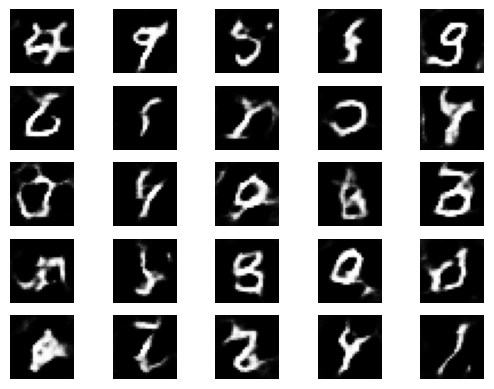

  0%|          | 0/750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 138ms/step


  0%|          | 1/750 [00:00<11:35,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


  0%|          | 2/750 [00:01<11:27,  1.09it/s]

1/1 [==============================] - 0s 133ms/step


  0%|          | 3/750 [00:02<11:26,  1.09it/s]

1/1 [==============================] - 0s 133ms/step


  1%|          | 4/750 [00:03<11:22,  1.09it/s]

1/1 [==============================] - 0s 131ms/step


  1%|          | 5/750 [00:04<11:19,  1.10it/s]

1/1 [==============================] - 0s 141ms/step


  1%|          | 6/750 [00:05<11:25,  1.09it/s]

1/1 [==============================] - 0s 132ms/step


  1%|          | 7/750 [00:06<11:15,  1.10it/s]

1/1 [==============================] - 0s 131ms/step


  1%|          | 8/750 [00:07<11:16,  1.10it/s]

1/1 [==============================] - 0s 137ms/step


  1%|          | 9/750 [00:08<11:15,  1.10it/s]

1/1 [==============================] - 0s 131ms/step


  1%|▏         | 10/750 [00:09<11:19,  1.09it/s]

1/1 [==============================] - 0s 207ms/step


  1%|▏         | 11/750 [00:10<13:32,  1.10s/it]

1/1 [==============================] - 0s 220ms/step


  2%|▏         | 12/750 [00:12<15:21,  1.25s/it]

1/1 [==============================] - 0s 210ms/step


  2%|▏         | 13/750 [00:13<15:56,  1.30s/it]

1/1 [==============================] - 0s 222ms/step


  2%|▏         | 14/750 [00:15<16:46,  1.37s/it]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 15/750 [00:16<16:56,  1.38s/it]

1/1 [==============================] - 0s 144ms/step


  2%|▏         | 16/750 [00:17<15:19,  1.25s/it]

1/1 [==============================] - 0s 127ms/step


  2%|▏         | 17/750 [00:18<14:00,  1.15s/it]

1/1 [==============================] - 0s 129ms/step


  2%|▏         | 18/750 [00:19<13:04,  1.07s/it]

1/1 [==============================] - 0s 127ms/step


  3%|▎         | 19/750 [00:20<12:30,  1.03s/it]

1/1 [==============================] - 0s 132ms/step


  3%|▎         | 20/750 [00:21<12:06,  1.01it/s]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 21/750 [00:22<11:43,  1.04it/s]

1/1 [==============================] - 0s 129ms/step


  3%|▎         | 22/750 [00:23<11:31,  1.05it/s]

1/1 [==============================] - 0s 136ms/step


  3%|▎         | 23/750 [00:23<11:20,  1.07it/s]

1/1 [==============================] - 0s 128ms/step


  3%|▎         | 24/750 [00:24<11:10,  1.08it/s]

1/1 [==============================] - 0s 129ms/step


  3%|▎         | 25/750 [00:25<11:08,  1.08it/s]

1/1 [==============================] - 0s 138ms/step


  3%|▎         | 26/750 [00:26<11:04,  1.09it/s]

1/1 [==============================] - 0s 169ms/step


  4%|▎         | 27/750 [00:28<12:51,  1.07s/it]

1/1 [==============================] - 0s 204ms/step


  4%|▎         | 28/750 [00:29<14:35,  1.21s/it]

1/1 [==============================] - 0s 203ms/step


  4%|▍         | 29/750 [00:31<15:19,  1.28s/it]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 30/750 [00:32<16:11,  1.35s/it]

1/1 [==============================] - 0s 212ms/step


  4%|▍         | 31/750 [00:33<16:15,  1.36s/it]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 32/750 [00:35<15:18,  1.28s/it]

1/1 [==============================] - 0s 131ms/step


  4%|▍         | 33/750 [00:35<14:02,  1.18s/it]

1/1 [==============================] - 0s 126ms/step


  5%|▍         | 34/750 [00:36<13:00,  1.09s/it]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 35/750 [00:37<12:18,  1.03s/it]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 36/750 [00:38<11:49,  1.01it/s]

1/1 [==============================] - 0s 133ms/step


  5%|▍         | 37/750 [00:39<11:27,  1.04it/s]

1/1 [==============================] - 0s 139ms/step


  5%|▌         | 38/750 [00:40<11:12,  1.06it/s]

1/1 [==============================] - 0s 124ms/step


  5%|▌         | 39/750 [00:41<11:02,  1.07it/s]

1/1 [==============================] - 0s 125ms/step


  5%|▌         | 40/750 [00:42<10:59,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


  5%|▌         | 41/750 [00:43<10:54,  1.08it/s]

1/1 [==============================] - 0s 130ms/step


  6%|▌         | 42/750 [00:44<10:51,  1.09it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▌         | 43/750 [00:45<11:43,  1.01it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▌         | 44/750 [00:46<13:41,  1.16s/it]

1/1 [==============================] - 0s 217ms/step


  6%|▌         | 45/750 [00:48<14:36,  1.24s/it]

1/1 [==============================] - 0s 219ms/step


  6%|▌         | 46/750 [00:49<15:09,  1.29s/it]

1/1 [==============================] - 0s 212ms/step


  6%|▋         | 47/750 [00:51<15:59,  1.37s/it]

1/1 [==============================] - 0s 205ms/step


  6%|▋         | 48/750 [00:52<15:52,  1.36s/it]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 49/750 [00:53<14:12,  1.22s/it]

1/1 [==============================] - 0s 127ms/step


  7%|▋         | 50/750 [00:54<13:08,  1.13s/it]

1/1 [==============================] - 0s 127ms/step


  7%|▋         | 51/750 [00:55<12:20,  1.06s/it]

1/1 [==============================] - 0s 131ms/step


  7%|▋         | 52/750 [00:56<11:46,  1.01s/it]

1/1 [==============================] - 0s 149ms/step


  7%|▋         | 53/750 [00:57<11:27,  1.01it/s]

1/1 [==============================] - 0s 129ms/step


  7%|▋         | 54/750 [00:57<11:08,  1.04it/s]

1/1 [==============================] - 0s 132ms/step


  7%|▋         | 55/750 [00:58<10:59,  1.05it/s]

1/1 [==============================] - 0s 133ms/step


  7%|▋         | 56/750 [00:59<10:50,  1.07it/s]

1/1 [==============================] - 0s 136ms/step


  8%|▊         | 57/750 [01:00<10:45,  1.07it/s]

1/1 [==============================] - 0s 130ms/step


  8%|▊         | 58/750 [01:01<10:38,  1.08it/s]

1/1 [==============================] - 0s 139ms/step


  8%|▊         | 59/750 [01:02<10:49,  1.06it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 60/750 [01:04<12:43,  1.11s/it]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 61/750 [01:05<13:55,  1.21s/it]

1/1 [==============================] - 0s 223ms/step


  8%|▊         | 62/750 [01:07<14:48,  1.29s/it]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 63/750 [01:08<15:13,  1.33s/it]

1/1 [==============================] - 0s 197ms/step


  9%|▊         | 64/750 [01:09<15:23,  1.35s/it]

1/1 [==============================] - 0s 236ms/step


  9%|▊         | 65/750 [01:10<14:36,  1.28s/it]

1/1 [==============================] - 0s 121ms/step


  9%|▉         | 66/750 [01:11<13:13,  1.16s/it]

1/1 [==============================] - 0s 133ms/step


  9%|▉         | 67/750 [01:12<12:18,  1.08s/it]

1/1 [==============================] - 0s 155ms/step


  9%|▉         | 68/750 [01:13<11:50,  1.04s/it]

1/1 [==============================] - 0s 129ms/step


  9%|▉         | 69/750 [01:14<11:22,  1.00s/it]

1/1 [==============================] - 0s 130ms/step


  9%|▉         | 70/750 [01:15<11:03,  1.03it/s]

1/1 [==============================] - 0s 134ms/step


  9%|▉         | 71/750 [01:16<10:46,  1.05it/s]

1/1 [==============================] - 0s 124ms/step


 10%|▉         | 72/750 [01:17<10:31,  1.07it/s]

1/1 [==============================] - 0s 128ms/step


 10%|▉         | 73/750 [01:18<10:24,  1.08it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 74/750 [01:19<10:13,  1.10it/s]

1/1 [==============================] - 0s 127ms/step


 10%|█         | 75/750 [01:19<10:10,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 10%|█         | 76/750 [01:21<11:01,  1.02it/s]

1/1 [==============================] - 0s 229ms/step


 10%|█         | 77/750 [01:22<12:42,  1.13s/it]

1/1 [==============================] - 0s 197ms/step


 10%|█         | 78/750 [01:24<13:49,  1.23s/it]

1/1 [==============================] - 0s 196ms/step


 11%|█         | 79/750 [01:25<14:21,  1.28s/it]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 80/750 [01:26<14:40,  1.31s/it]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 81/750 [01:28<15:01,  1.35s/it]

1/1 [==============================] - 0s 124ms/step


 11%|█         | 82/750 [01:29<13:28,  1.21s/it]

1/1 [==============================] - 0s 120ms/step


 11%|█         | 83/750 [01:30<12:20,  1.11s/it]

1/1 [==============================] - 0s 124ms/step


 11%|█         | 84/750 [01:30<11:35,  1.05s/it]

1/1 [==============================] - 0s 121ms/step


 11%|█▏        | 85/750 [01:31<11:02,  1.00it/s]

1/1 [==============================] - 0s 132ms/step


 11%|█▏        | 86/750 [01:32<10:44,  1.03it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 87/750 [01:33<10:24,  1.06it/s]

1/1 [==============================] - 0s 136ms/step


 12%|█▏        | 88/750 [01:34<10:13,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 89/750 [01:35<10:05,  1.09it/s]

1/1 [==============================] - 0s 117ms/step


 12%|█▏        | 90/750 [01:36<10:02,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 91/750 [01:37<09:57,  1.10it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 92/750 [01:38<09:53,  1.11it/s]

1/1 [==============================] - 0s 183ms/step


 12%|█▏        | 93/750 [01:39<11:42,  1.07s/it]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 94/750 [01:41<13:02,  1.19s/it]

1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 95/750 [01:42<13:39,  1.25s/it]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 96/750 [01:43<14:08,  1.30s/it]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 97/750 [01:45<14:28,  1.33s/it]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 98/750 [01:46<13:56,  1.28s/it]

1/1 [==============================] - 0s 119ms/step


 13%|█▎        | 99/750 [01:47<12:33,  1.16s/it]

1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 100/750 [01:48<11:38,  1.07s/it]

1/1 [==============================] - 0s 131ms/step


 13%|█▎        | 101/750 [01:49<11:00,  1.02s/it]

1/1 [==============================] - 0s 115ms/step


 14%|█▎        | 102/750 [01:49<10:30,  1.03it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█▎        | 103/750 [01:50<10:15,  1.05it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 104/750 [01:51<10:02,  1.07it/s]

1/1 [==============================] - 0s 122ms/step


 14%|█▍        | 105/750 [01:52<09:52,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 106/750 [01:53<09:43,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 14%|█▍        | 107/750 [01:54<09:36,  1.12it/s]

1/1 [==============================] - 0s 134ms/step


 14%|█▍        | 108/750 [01:55<09:35,  1.12it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▍        | 109/750 [01:56<09:46,  1.09it/s]

1/1 [==============================] - 0s 192ms/step


 15%|█▍        | 110/750 [01:57<11:48,  1.11s/it]

1/1 [==============================] - 0s 204ms/step


 15%|█▍        | 111/750 [01:59<13:01,  1.22s/it]

1/1 [==============================] - 0s 195ms/step


 15%|█▍        | 112/750 [02:00<13:38,  1.28s/it]

1/1 [==============================] - 0s 203ms/step


 15%|█▌        | 113/750 [02:02<14:07,  1.33s/it]

1/1 [==============================] - 0s 206ms/step


 15%|█▌        | 114/750 [02:03<14:23,  1.36s/it]

1/1 [==============================] - 0s 164ms/step


 15%|█▌        | 115/750 [02:04<13:06,  1.24s/it]

1/1 [==============================] - 0s 120ms/step


 15%|█▌        | 116/750 [02:05<12:00,  1.14s/it]

1/1 [==============================] - 0s 131ms/step


 16%|█▌        | 117/750 [02:06<11:15,  1.07s/it]

1/1 [==============================] - 0s 133ms/step


 16%|█▌        | 118/750 [02:07<10:43,  1.02s/it]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 119/750 [02:08<10:16,  1.02it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▌        | 120/750 [02:08<09:58,  1.05it/s]

1/1 [==============================] - 0s 132ms/step


 16%|█▌        | 121/750 [02:09<09:46,  1.07it/s]

1/1 [==============================] - 0s 121ms/step


 16%|█▋        | 122/750 [02:10<09:39,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 16%|█▋        | 123/750 [02:11<09:32,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 124/750 [02:12<09:26,  1.11it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 125/750 [02:13<09:24,  1.11it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 126/750 [02:14<10:31,  1.01s/it]

1/1 [==============================] - 0s 191ms/step


 17%|█▋        | 127/750 [02:16<11:50,  1.14s/it]

1/1 [==============================] - 0s 207ms/step


 17%|█▋        | 128/750 [02:17<12:44,  1.23s/it]

1/1 [==============================] - 0s 199ms/step


 17%|█▋        | 129/750 [02:19<13:34,  1.31s/it]

1/1 [==============================] - 0s 207ms/step


 17%|█▋        | 130/750 [02:20<14:00,  1.36s/it]

1/1 [==============================] - 0s 201ms/step


 17%|█▋        | 131/750 [02:21<14:12,  1.38s/it]

1/1 [==============================] - 0s 136ms/step


 18%|█▊        | 132/750 [02:22<12:55,  1.26s/it]

1/1 [==============================] - 0s 121ms/step


 18%|█▊        | 133/750 [02:23<11:46,  1.14s/it]

1/1 [==============================] - 0s 116ms/step


 18%|█▊        | 134/750 [02:24<10:56,  1.07s/it]

1/1 [==============================] - 0s 117ms/step


 18%|█▊        | 135/750 [02:25<10:21,  1.01s/it]

1/1 [==============================] - 0s 128ms/step


 18%|█▊        | 136/750 [02:26<09:57,  1.03it/s]

1/1 [==============================] - 0s 118ms/step


 18%|█▊        | 137/750 [02:27<09:43,  1.05it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 138/750 [02:28<09:34,  1.06it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▊        | 139/750 [02:29<09:25,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▊        | 140/750 [02:30<09:20,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▉        | 141/750 [02:30<09:13,  1.10it/s]

1/1 [==============================] - 0s 115ms/step


 19%|█▉        | 142/750 [02:32<09:56,  1.02it/s]

1/1 [==============================] - 0s 196ms/step


 19%|█▉        | 143/750 [02:33<11:42,  1.16s/it]

1/1 [==============================] - 0s 193ms/step


 19%|█▉        | 144/750 [02:35<12:12,  1.21s/it]

1/1 [==============================] - 0s 203ms/step


 19%|█▉        | 145/750 [02:36<13:01,  1.29s/it]

1/1 [==============================] - 0s 195ms/step


 19%|█▉        | 146/750 [02:37<13:36,  1.35s/it]

1/1 [==============================] - 0s 208ms/step


 20%|█▉        | 147/750 [02:39<13:40,  1.36s/it]

1/1 [==============================] - 0s 115ms/step


 20%|█▉        | 148/750 [02:40<12:13,  1.22s/it]

1/1 [==============================] - 0s 129ms/step


 20%|█▉        | 149/750 [02:41<11:12,  1.12s/it]

1/1 [==============================] - 0s 120ms/step


 20%|██        | 150/750 [02:42<10:29,  1.05s/it]

1/1 [==============================] - 0s 115ms/step


 20%|██        | 151/750 [02:42<09:58,  1.00it/s]

1/1 [==============================] - 0s 115ms/step


 20%|██        | 152/750 [02:43<09:36,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 20%|██        | 153/750 [02:44<09:24,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██        | 154/750 [02:45<09:10,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 21%|██        | 155/750 [02:46<09:04,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 21%|██        | 156/750 [02:47<08:57,  1.10it/s]

1/1 [==============================] - 0s 126ms/step


 21%|██        | 157/750 [02:48<08:57,  1.10it/s]

1/1 [==============================] - 0s 123ms/step


 21%|██        | 158/750 [02:49<08:54,  1.11it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██        | 159/750 [02:50<10:11,  1.03s/it]

1/1 [==============================] - 0s 196ms/step


 21%|██▏       | 160/750 [02:51<11:15,  1.15s/it]

1/1 [==============================] - 0s 209ms/step


 21%|██▏       | 161/750 [02:53<12:00,  1.22s/it]

1/1 [==============================] - 0s 237ms/step


 22%|██▏       | 162/750 [02:54<12:34,  1.28s/it]

1/1 [==============================] - 0s 195ms/step


 22%|██▏       | 163/750 [02:56<12:49,  1.31s/it]

1/1 [==============================] - 0s 186ms/step


 22%|██▏       | 164/750 [02:57<13:01,  1.33s/it]

1/1 [==============================] - 0s 120ms/step


 22%|██▏       | 165/750 [02:58<11:44,  1.20s/it]

1/1 [==============================] - 0s 120ms/step


 22%|██▏       | 166/750 [02:59<10:49,  1.11s/it]

1/1 [==============================] - 0s 120ms/step


 22%|██▏       | 167/750 [03:00<10:09,  1.05s/it]

1/1 [==============================] - 0s 116ms/step


 22%|██▏       | 168/750 [03:01<09:39,  1.00it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 169/750 [03:01<09:20,  1.04it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 170/750 [03:02<09:09,  1.05it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 171/750 [03:03<08:58,  1.08it/s]

1/1 [==============================] - 0s 117ms/step


 23%|██▎       | 172/750 [03:04<08:50,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 23%|██▎       | 173/750 [03:05<08:49,  1.09it/s]

1/1 [==============================] - 0s 128ms/step


 23%|██▎       | 174/750 [03:06<08:50,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 175/750 [03:07<08:42,  1.10it/s]

1/1 [==============================] - 0s 129ms/step


 23%|██▎       | 176/750 [03:08<10:06,  1.06s/it]

1/1 [==============================] - 0s 193ms/step


 24%|██▎       | 177/750 [03:10<11:05,  1.16s/it]

1/1 [==============================] - 0s 195ms/step


 24%|██▎       | 178/750 [03:11<11:49,  1.24s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██▍       | 179/750 [03:12<12:17,  1.29s/it]

1/1 [==============================] - 0s 200ms/step


 24%|██▍       | 180/750 [03:14<12:31,  1.32s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██▍       | 181/750 [03:15<12:25,  1.31s/it]

1/1 [==============================] - 0s 144ms/step


 24%|██▍       | 182/750 [03:16<11:13,  1.19s/it]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 183/750 [03:17<10:22,  1.10s/it]

1/1 [==============================] - 0s 118ms/step


 25%|██▍       | 184/750 [03:18<09:45,  1.03s/it]

1/1 [==============================] - 0s 117ms/step


 25%|██▍       | 185/750 [03:19<09:19,  1.01it/s]

1/1 [==============================] - 0s 118ms/step


 25%|██▍       | 186/750 [03:20<09:00,  1.04it/s]

1/1 [==============================] - 0s 116ms/step


 25%|██▍       | 187/750 [03:20<08:46,  1.07it/s]

1/1 [==============================] - 0s 114ms/step


 25%|██▌       | 188/750 [03:21<08:35,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 25%|██▌       | 189/750 [03:22<08:28,  1.10it/s]

1/1 [==============================] - 0s 141ms/step


 25%|██▌       | 190/750 [03:23<08:32,  1.09it/s]

1/1 [==============================] - 0s 133ms/step


 25%|██▌       | 191/750 [03:24<08:29,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 192/750 [03:25<08:29,  1.10it/s]

1/1 [==============================] - 0s 196ms/step


 26%|██▌       | 193/750 [03:26<09:46,  1.05s/it]

1/1 [==============================] - 0s 213ms/step


 26%|██▌       | 194/750 [03:28<10:44,  1.16s/it]

1/1 [==============================] - 0s 206ms/step


 26%|██▌       | 195/750 [03:29<11:42,  1.27s/it]

1/1 [==============================] - 0s 202ms/step


 26%|██▌       | 196/750 [03:31<12:01,  1.30s/it]

1/1 [==============================] - 0s 203ms/step


 26%|██▋       | 197/750 [03:32<12:11,  1.32s/it]

1/1 [==============================] - 0s 199ms/step


 26%|██▋       | 198/750 [03:33<11:57,  1.30s/it]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 199/750 [03:34<10:48,  1.18s/it]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 200/750 [03:35<10:02,  1.10s/it]

1/1 [==============================] - 0s 135ms/step


 27%|██▋       | 201/750 [03:36<09:28,  1.04s/it]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 202/750 [03:37<09:02,  1.01it/s]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 203/750 [03:38<08:50,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 204/750 [03:39<08:37,  1.05it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 205/750 [03:40<08:29,  1.07it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 206/750 [03:40<08:18,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 207/750 [03:41<08:14,  1.10it/s]

1/1 [==============================] - 0s 116ms/step


 28%|██▊       | 208/750 [03:42<08:10,  1.10it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 209/750 [03:43<08:15,  1.09it/s]

1/1 [==============================] - 0s 194ms/step


 28%|██▊       | 210/750 [03:45<09:45,  1.09s/it]

1/1 [==============================] - 0s 196ms/step


 28%|██▊       | 211/750 [03:46<10:37,  1.18s/it]

1/1 [==============================] - 0s 193ms/step


 28%|██▊       | 212/750 [03:48<11:32,  1.29s/it]

1/1 [==============================] - 0s 187ms/step


 28%|██▊       | 213/750 [03:49<11:58,  1.34s/it]

1/1 [==============================] - 0s 190ms/step


 29%|██▊       | 214/750 [03:50<12:08,  1.36s/it]

1/1 [==============================] - 0s 229ms/step


 29%|██▊       | 215/750 [03:52<11:18,  1.27s/it]

1/1 [==============================] - 0s 128ms/step


 29%|██▉       | 216/750 [03:52<10:18,  1.16s/it]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 217/750 [03:53<09:38,  1.09s/it]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 218/750 [03:54<09:08,  1.03s/it]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 219/750 [03:55<08:46,  1.01it/s]

1/1 [==============================] - 0s 115ms/step


 29%|██▉       | 220/750 [03:56<08:30,  1.04it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 221/750 [03:57<08:18,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 30%|██▉       | 222/750 [03:58<08:07,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 30%|██▉       | 223/750 [03:59<08:02,  1.09it/s]

1/1 [==============================] - 0s 131ms/step


 30%|██▉       | 224/750 [04:00<07:56,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 30%|███       | 225/750 [04:01<07:59,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 226/750 [04:02<08:49,  1.01s/it]

1/1 [==============================] - 0s 217ms/step


 30%|███       | 227/750 [04:03<10:09,  1.17s/it]

1/1 [==============================] - 0s 223ms/step


 30%|███       | 228/750 [04:05<11:05,  1.27s/it]

1/1 [==============================] - 0s 202ms/step


 31%|███       | 229/750 [04:06<11:41,  1.35s/it]

1/1 [==============================] - 0s 187ms/step


 31%|███       | 230/750 [04:08<11:50,  1.37s/it]

1/1 [==============================] - 0s 195ms/step


 31%|███       | 231/750 [04:09<11:13,  1.30s/it]

1/1 [==============================] - 0s 125ms/step


 31%|███       | 232/750 [04:10<10:07,  1.17s/it]

1/1 [==============================] - 0s 125ms/step


 31%|███       | 233/750 [04:11<09:24,  1.09s/it]

1/1 [==============================] - 0s 124ms/step


 31%|███       | 234/750 [04:12<08:55,  1.04s/it]

1/1 [==============================] - 0s 118ms/step


 31%|███▏      | 235/750 [04:13<08:33,  1.00it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███▏      | 236/750 [04:13<08:14,  1.04it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 237/750 [04:14<08:03,  1.06it/s]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 238/750 [04:15<07:53,  1.08it/s]

1/1 [==============================] - 0s 126ms/step


 32%|███▏      | 239/750 [04:16<07:49,  1.09it/s]

1/1 [==============================] - 0s 126ms/step


 32%|███▏      | 240/750 [04:17<07:44,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 32%|███▏      | 241/750 [04:18<07:39,  1.11it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 242/750 [04:19<08:11,  1.03it/s]

1/1 [==============================] - 0s 203ms/step


 32%|███▏      | 243/750 [04:20<09:29,  1.12s/it]

1/1 [==============================] - 0s 193ms/step


 33%|███▎      | 244/750 [04:22<10:11,  1.21s/it]

1/1 [==============================] - 0s 195ms/step


 33%|███▎      | 245/750 [04:23<10:37,  1.26s/it]

1/1 [==============================] - 0s 192ms/step


 33%|███▎      | 246/750 [04:25<10:46,  1.28s/it]

1/1 [==============================] - 0s 196ms/step


 33%|███▎      | 247/750 [04:26<11:17,  1.35s/it]

1/1 [==============================] - 0s 197ms/step


 33%|███▎      | 248/750 [04:27<10:28,  1.25s/it]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 249/750 [04:28<09:36,  1.15s/it]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 250/750 [04:29<08:56,  1.07s/it]

1/1 [==============================] - 0s 133ms/step


 33%|███▎      | 251/750 [04:30<08:31,  1.02s/it]

1/1 [==============================] - 0s 122ms/step


 34%|███▎      | 252/750 [04:31<08:12,  1.01it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▎      | 253/750 [04:32<07:59,  1.04it/s]

1/1 [==============================] - 0s 126ms/step


 34%|███▍      | 254/750 [04:33<07:49,  1.06it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 255/750 [04:33<07:42,  1.07it/s]

1/1 [==============================] - 0s 128ms/step


 34%|███▍      | 256/750 [04:34<07:35,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 257/750 [04:35<07:31,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 258/750 [04:36<07:26,  1.10it/s]

1/1 [==============================] - 0s 134ms/step


 35%|███▍      | 259/750 [04:37<08:25,  1.03s/it]

1/1 [==============================] - 0s 212ms/step


 35%|███▍      | 260/750 [04:39<09:30,  1.16s/it]

1/1 [==============================] - 0s 202ms/step


 35%|███▍      | 261/750 [04:40<10:13,  1.26s/it]

1/1 [==============================] - 0s 200ms/step


 35%|███▍      | 262/750 [04:42<10:28,  1.29s/it]

1/1 [==============================] - 0s 201ms/step


 35%|███▌      | 263/750 [04:43<10:50,  1.34s/it]

1/1 [==============================] - 0s 180ms/step


 35%|███▌      | 264/750 [04:45<10:44,  1.33s/it]

1/1 [==============================] - 0s 132ms/step


 35%|███▌      | 265/750 [04:45<09:38,  1.19s/it]

1/1 [==============================] - 0s 119ms/step


 35%|███▌      | 266/750 [04:46<08:53,  1.10s/it]

1/1 [==============================] - 0s 119ms/step


 36%|███▌      | 267/750 [04:47<08:20,  1.04s/it]

1/1 [==============================] - 0s 123ms/step


 36%|███▌      | 268/750 [04:48<07:59,  1.01it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 269/750 [04:49<07:44,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 36%|███▌      | 270/750 [04:50<07:35,  1.05it/s]

1/1 [==============================] - 0s 119ms/step


 36%|███▌      | 271/750 [04:51<07:24,  1.08it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▋      | 272/750 [04:52<07:17,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 36%|███▋      | 273/750 [04:53<07:10,  1.11it/s]

1/1 [==============================] - 0s 115ms/step


 37%|███▋      | 274/750 [04:53<07:08,  1.11it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 275/750 [04:54<07:06,  1.11it/s]

1/1 [==============================] - 0s 163ms/step


 37%|███▋      | 276/750 [04:56<08:19,  1.05s/it]

1/1 [==============================] - 0s 207ms/step


 37%|███▋      | 277/750 [04:57<09:22,  1.19s/it]

1/1 [==============================] - 0s 204ms/step


 37%|███▋      | 278/750 [04:59<09:53,  1.26s/it]

1/1 [==============================] - 0s 195ms/step


 37%|███▋      | 279/750 [05:00<10:05,  1.29s/it]

1/1 [==============================] - 0s 211ms/step


 37%|███▋      | 280/750 [05:01<10:18,  1.32s/it]

1/1 [==============================] - 0s 219ms/step


 37%|███▋      | 281/750 [05:03<10:11,  1.30s/it]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 282/750 [05:04<09:13,  1.18s/it]

1/1 [==============================] - 0s 137ms/step


 38%|███▊      | 283/750 [05:04<08:37,  1.11s/it]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 284/750 [05:05<08:08,  1.05s/it]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 285/750 [05:06<07:47,  1.01s/it]

1/1 [==============================] - 0s 136ms/step


 38%|███▊      | 286/750 [05:07<07:34,  1.02it/s]

1/1 [==============================] - 0s 123ms/step


 38%|███▊      | 287/750 [05:08<07:23,  1.04it/s]

1/1 [==============================] - 0s 128ms/step


 38%|███▊      | 288/750 [05:09<07:12,  1.07it/s]

1/1 [==============================] - 0s 119ms/step


 39%|███▊      | 289/750 [05:10<07:04,  1.09it/s]

1/1 [==============================] - 0s 128ms/step


 39%|███▊      | 290/750 [05:11<07:00,  1.09it/s]

1/1 [==============================] - 0s 128ms/step


 39%|███▉      | 291/750 [05:12<06:57,  1.10it/s]

1/1 [==============================] - 0s 127ms/step


 39%|███▉      | 292/750 [05:13<07:01,  1.09it/s]

1/1 [==============================] - 0s 193ms/step


 39%|███▉      | 293/750 [05:14<08:26,  1.11s/it]

1/1 [==============================] - 0s 196ms/step


 39%|███▉      | 294/750 [05:16<09:06,  1.20s/it]

1/1 [==============================] - 0s 194ms/step


 39%|███▉      | 295/750 [05:17<09:32,  1.26s/it]

1/1 [==============================] - 0s 204ms/step


 39%|███▉      | 296/750 [05:18<09:45,  1.29s/it]

1/1 [==============================] - 0s 203ms/step


 40%|███▉      | 297/750 [05:20<10:05,  1.34s/it]

1/1 [==============================] - 0s 217ms/step


 40%|███▉      | 298/750 [05:21<09:46,  1.30s/it]

1/1 [==============================] - 0s 124ms/step


 40%|███▉      | 299/750 [05:22<08:49,  1.17s/it]

1/1 [==============================] - 0s 117ms/step


 40%|████      | 300/750 [05:23<08:10,  1.09s/it]

1/1 [==============================] - 0s 122ms/step


 40%|████      | 301/750 [05:24<07:41,  1.03s/it]

1/1 [==============================] - 0s 123ms/step


 40%|████      | 302/750 [05:25<07:22,  1.01it/s]

1/1 [==============================] - 0s 118ms/step


 40%|████      | 303/750 [05:25<07:08,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 304/750 [05:26<06:59,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 305/750 [05:27<06:51,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 306/750 [05:28<06:45,  1.09it/s]

1/1 [==============================] - 0s 140ms/step


 41%|████      | 307/750 [05:29<06:42,  1.10it/s]

1/1 [==============================] - 0s 128ms/step


 41%|████      | 308/750 [05:30<06:39,  1.11it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 309/750 [05:31<06:45,  1.09it/s]

1/1 [==============================] - 0s 197ms/step


 41%|████▏     | 310/750 [05:32<07:53,  1.08s/it]

1/1 [==============================] - 0s 220ms/step


 41%|████▏     | 311/750 [05:34<08:38,  1.18s/it]

1/1 [==============================] - 0s 196ms/step


 42%|████▏     | 312/750 [05:35<09:10,  1.26s/it]

1/1 [==============================] - 0s 201ms/step


 42%|████▏     | 313/750 [05:37<09:31,  1.31s/it]

1/1 [==============================] - 0s 225ms/step


 42%|████▏     | 314/750 [05:38<10:06,  1.39s/it]

1/1 [==============================] - 0s 195ms/step


 42%|████▏     | 315/750 [05:39<09:19,  1.29s/it]

1/1 [==============================] - 0s 117ms/step


 42%|████▏     | 316/750 [05:40<08:26,  1.17s/it]

1/1 [==============================] - 0s 128ms/step


 42%|████▏     | 317/750 [05:41<07:52,  1.09s/it]

1/1 [==============================] - 0s 125ms/step


 42%|████▏     | 318/750 [05:42<07:26,  1.03s/it]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 319/750 [05:43<07:07,  1.01it/s]

1/1 [==============================] - 0s 128ms/step


 43%|████▎     | 320/750 [05:44<06:53,  1.04it/s]

1/1 [==============================] - 0s 127ms/step


 43%|████▎     | 321/750 [05:45<06:44,  1.06it/s]

1/1 [==============================] - 0s 126ms/step


 43%|████▎     | 322/750 [05:46<06:37,  1.08it/s]

1/1 [==============================] - 0s 117ms/step


 43%|████▎     | 323/750 [05:46<06:31,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 324/750 [05:47<06:26,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 325/750 [05:48<06:26,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 326/750 [05:49<07:11,  1.02s/it]

1/1 [==============================] - 0s 203ms/step


 44%|████▎     | 327/750 [05:51<08:02,  1.14s/it]

1/1 [==============================] - 0s 202ms/step


 44%|████▎     | 328/750 [05:52<08:33,  1.22s/it]

1/1 [==============================] - 0s 203ms/step


 44%|████▍     | 329/750 [05:54<08:57,  1.28s/it]

1/1 [==============================] - 0s 206ms/step


 44%|████▍     | 330/750 [05:55<09:19,  1.33s/it]

1/1 [==============================] - 0s 207ms/step


 44%|████▍     | 331/750 [05:57<09:24,  1.35s/it]

1/1 [==============================] - 0s 119ms/step


 44%|████▍     | 332/750 [05:57<08:27,  1.21s/it]

1/1 [==============================] - 0s 118ms/step


 44%|████▍     | 333/750 [05:58<07:43,  1.11s/it]

1/1 [==============================] - 0s 132ms/step


 45%|████▍     | 334/750 [05:59<07:16,  1.05s/it]

1/1 [==============================] - 0s 127ms/step


 45%|████▍     | 335/750 [06:00<06:56,  1.00s/it]

1/1 [==============================] - 0s 131ms/step


 45%|████▍     | 336/750 [06:01<06:43,  1.03it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▍     | 337/750 [06:02<06:30,  1.06it/s]

1/1 [==============================] - 0s 120ms/step


 45%|████▌     | 338/750 [06:03<06:21,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▌     | 339/750 [06:04<06:19,  1.08it/s]

1/1 [==============================] - 0s 116ms/step


 45%|████▌     | 340/750 [06:05<06:13,  1.10it/s]

1/1 [==============================] - 0s 134ms/step


 45%|████▌     | 341/750 [06:06<06:13,  1.10it/s]

1/1 [==============================] - 0s 132ms/step


 46%|████▌     | 342/750 [06:06<06:09,  1.10it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 343/750 [06:08<07:02,  1.04s/it]

1/1 [==============================] - 0s 230ms/step


 46%|████▌     | 344/750 [06:09<07:56,  1.17s/it]

1/1 [==============================] - 0s 219ms/step


 46%|████▌     | 345/750 [06:11<08:24,  1.25s/it]

1/1 [==============================] - 0s 198ms/step


 46%|████▌     | 346/750 [06:12<08:37,  1.28s/it]

1/1 [==============================] - 0s 204ms/step


 46%|████▋     | 347/750 [06:14<09:03,  1.35s/it]

1/1 [==============================] - 0s 216ms/step


 46%|████▋     | 348/750 [06:15<08:55,  1.33s/it]

1/1 [==============================] - 0s 118ms/step


 47%|████▋     | 349/750 [06:16<08:02,  1.20s/it]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 350/750 [06:17<07:26,  1.12s/it]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 351/750 [06:18<06:58,  1.05s/it]

1/1 [==============================] - 0s 116ms/step


 47%|████▋     | 352/750 [06:18<06:38,  1.00s/it]

1/1 [==============================] - 0s 117ms/step


 47%|████▋     | 353/750 [06:19<06:23,  1.04it/s]

1/1 [==============================] - 0s 116ms/step


 47%|████▋     | 354/750 [06:20<06:11,  1.07it/s]

1/1 [==============================] - 0s 134ms/step


 47%|████▋     | 355/750 [06:21<06:05,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 356/750 [06:22<06:03,  1.08it/s]

1/1 [==============================] - 0s 126ms/step


 48%|████▊     | 357/750 [06:23<05:59,  1.09it/s]

1/1 [==============================] - 0s 118ms/step


 48%|████▊     | 358/750 [06:24<05:59,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


 48%|████▊     | 359/750 [06:25<05:56,  1.10it/s]

1/1 [==============================] - 0s 194ms/step


 48%|████▊     | 360/750 [06:26<06:57,  1.07s/it]

1/1 [==============================] - 0s 195ms/step


 48%|████▊     | 361/750 [06:28<07:35,  1.17s/it]

1/1 [==============================] - 0s 216ms/step


 48%|████▊     | 362/750 [06:29<07:57,  1.23s/it]

1/1 [==============================] - 0s 195ms/step


 48%|████▊     | 363/750 [06:30<08:23,  1.30s/it]

1/1 [==============================] - 0s 193ms/step


 49%|████▊     | 364/750 [06:32<08:31,  1.32s/it]

1/1 [==============================] - 0s 206ms/step


 49%|████▊     | 365/750 [06:33<08:32,  1.33s/it]

1/1 [==============================] - 0s 128ms/step


 49%|████▉     | 366/750 [06:34<07:42,  1.20s/it]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 367/750 [06:35<07:04,  1.11s/it]

1/1 [==============================] - 0s 133ms/step


 49%|████▉     | 368/750 [06:36<06:43,  1.06s/it]

1/1 [==============================] - 0s 122ms/step


 49%|████▉     | 369/750 [06:37<06:22,  1.00s/it]

1/1 [==============================] - 0s 135ms/step


 49%|████▉     | 370/750 [06:38<06:10,  1.03it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▉     | 371/750 [06:39<05:59,  1.05it/s]

1/1 [==============================] - 0s 124ms/step


 50%|████▉     | 372/750 [06:39<05:53,  1.07it/s]

1/1 [==============================] - 0s 117ms/step


 50%|████▉     | 373/750 [06:40<05:46,  1.09it/s]

1/1 [==============================] - 0s 124ms/step


 50%|████▉     | 374/750 [06:41<05:47,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


 50%|█████     | 375/750 [06:42<05:43,  1.09it/s]

1/1 [==============================] - 0s 133ms/step


 50%|█████     | 376/750 [06:43<05:39,  1.10it/s]

1/1 [==============================] - 0s 199ms/step


 50%|█████     | 377/750 [06:44<06:36,  1.06s/it]

1/1 [==============================] - 0s 210ms/step


 50%|█████     | 378/750 [06:46<07:15,  1.17s/it]

1/1 [==============================] - 0s 210ms/step


 51%|█████     | 379/750 [06:47<07:38,  1.24s/it]

1/1 [==============================] - 0s 205ms/step


 51%|█████     | 380/750 [06:49<07:50,  1.27s/it]

1/1 [==============================] - 0s 200ms/step


 51%|█████     | 381/750 [06:50<08:03,  1.31s/it]

1/1 [==============================] - 0s 226ms/step


 51%|█████     | 382/750 [06:51<08:07,  1.32s/it]

1/1 [==============================] - 0s 121ms/step


 51%|█████     | 383/750 [06:52<07:18,  1.20s/it]

1/1 [==============================] - 0s 117ms/step


 51%|█████     | 384/750 [06:53<06:43,  1.10s/it]

1/1 [==============================] - 0s 123ms/step


 51%|█████▏    | 385/750 [06:54<06:19,  1.04s/it]

1/1 [==============================] - 0s 120ms/step


 51%|█████▏    | 386/750 [06:55<06:04,  1.00s/it]

1/1 [==============================] - 0s 122ms/step


 52%|█████▏    | 387/750 [06:56<05:50,  1.04it/s]

1/1 [==============================] - 0s 118ms/step


 52%|█████▏    | 388/750 [06:57<05:40,  1.06it/s]

1/1 [==============================] - 0s 124ms/step


 52%|█████▏    | 389/750 [06:58<05:36,  1.07it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 390/750 [06:59<05:30,  1.09it/s]

1/1 [==============================] - 0s 126ms/step


 52%|█████▏    | 391/750 [06:59<05:29,  1.09it/s]

1/1 [==============================] - 0s 117ms/step


 52%|█████▏    | 392/750 [07:00<05:26,  1.10it/s]

1/1 [==============================] - 0s 118ms/step


 52%|█████▏    | 393/750 [07:01<05:24,  1.10it/s]

1/1 [==============================] - 0s 184ms/step


 53%|█████▎    | 394/750 [07:03<06:19,  1.07s/it]

1/1 [==============================] - 0s 208ms/step


 53%|█████▎    | 395/750 [07:04<07:08,  1.21s/it]

1/1 [==============================] - 0s 196ms/step


 53%|█████▎    | 396/750 [07:06<07:32,  1.28s/it]

1/1 [==============================] - 0s 187ms/step


 53%|█████▎    | 397/750 [07:07<07:37,  1.30s/it]

1/1 [==============================] - 0s 211ms/step


 53%|█████▎    | 398/750 [07:08<07:51,  1.34s/it]

1/1 [==============================] - 0s 208ms/step


 53%|█████▎    | 399/750 [07:10<07:33,  1.29s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████▎    | 400/750 [07:10<06:51,  1.17s/it]

1/1 [==============================] - 0s 120ms/step


 53%|█████▎    | 401/750 [07:11<06:23,  1.10s/it]

1/1 [==============================] - 0s 121ms/step


 54%|█████▎    | 402/750 [07:12<06:00,  1.04s/it]

1/1 [==============================] - 0s 123ms/step


 54%|█████▎    | 403/750 [07:13<05:45,  1.00it/s]

1/1 [==============================] - 0s 129ms/step


 54%|█████▍    | 404/750 [07:14<05:35,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████▍    | 405/750 [07:15<05:27,  1.05it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████▍    | 406/750 [07:16<05:22,  1.07it/s]

1/1 [==============================] - 0s 118ms/step


 54%|█████▍    | 407/750 [07:17<05:16,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 54%|█████▍    | 408/750 [07:18<05:13,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████▍    | 409/750 [07:19<05:12,  1.09it/s]

1/1 [==============================] - 0s 118ms/step


 55%|█████▍    | 410/750 [07:20<05:33,  1.02it/s]

1/1 [==============================] - 0s 205ms/step


 55%|█████▍    | 411/750 [07:21<06:18,  1.12s/it]

1/1 [==============================] - 0s 206ms/step


 55%|█████▍    | 412/750 [07:23<06:49,  1.21s/it]

1/1 [==============================] - 0s 205ms/step


 55%|█████▌    | 413/750 [07:24<07:06,  1.27s/it]

1/1 [==============================] - 0s 194ms/step


 55%|█████▌    | 414/750 [07:25<07:16,  1.30s/it]

1/1 [==============================] - 0s 195ms/step


 55%|█████▌    | 415/750 [07:27<07:28,  1.34s/it]

1/1 [==============================] - 0s 196ms/step


 55%|█████▌    | 416/750 [07:28<06:56,  1.25s/it]

1/1 [==============================] - 0s 137ms/step


 56%|█████▌    | 417/750 [07:29<06:21,  1.14s/it]

1/1 [==============================] - 0s 123ms/step


 56%|█████▌    | 418/750 [07:30<05:55,  1.07s/it]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 419/750 [07:31<05:38,  1.02s/it]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 420/750 [07:31<05:26,  1.01it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▌    | 421/750 [07:32<05:16,  1.04it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▋    | 422/750 [07:33<05:10,  1.06it/s]

1/1 [==============================] - 0s 129ms/step


 56%|█████▋    | 423/750 [07:34<05:05,  1.07it/s]

1/1 [==============================] - 0s 117ms/step


 57%|█████▋    | 424/750 [07:35<05:00,  1.09it/s]

1/1 [==============================] - 0s 129ms/step


 57%|█████▋    | 425/750 [07:36<04:58,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████▋    | 426/750 [07:37<04:58,  1.08it/s]

1/1 [==============================] - 0s 130ms/step


 57%|█████▋    | 427/750 [07:38<05:29,  1.02s/it]

1/1 [==============================] - 0s 233ms/step


 57%|█████▋    | 428/750 [07:40<06:13,  1.16s/it]

1/1 [==============================] - 0s 191ms/step


 57%|█████▋    | 429/750 [07:41<06:37,  1.24s/it]

1/1 [==============================] - 0s 217ms/step


 57%|█████▋    | 430/750 [07:42<06:49,  1.28s/it]

1/1 [==============================] - 0s 195ms/step


 57%|█████▋    | 431/750 [07:44<06:56,  1.30s/it]

1/1 [==============================] - 0s 198ms/step


 58%|█████▊    | 432/750 [07:45<07:07,  1.34s/it]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 433/750 [07:46<06:25,  1.22s/it]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 434/750 [07:47<05:56,  1.13s/it]

1/1 [==============================] - 0s 119ms/step


 58%|█████▊    | 435/750 [07:48<05:34,  1.06s/it]

1/1 [==============================] - 0s 121ms/step


 58%|█████▊    | 436/750 [07:49<05:19,  1.02s/it]

1/1 [==============================] - 0s 118ms/step


 58%|█████▊    | 437/750 [07:50<05:06,  1.02it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 438/750 [07:51<04:58,  1.04it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▊    | 439/750 [07:52<04:52,  1.06it/s]

1/1 [==============================] - 0s 118ms/step


 59%|█████▊    | 440/750 [07:53<04:47,  1.08it/s]

1/1 [==============================] - 0s 132ms/step


 59%|█████▉    | 441/750 [07:53<04:43,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 442/750 [07:54<04:40,  1.10it/s]

1/1 [==============================] - 0s 128ms/step


 59%|█████▉    | 443/750 [07:55<04:41,  1.09it/s]

1/1 [==============================] - 0s 164ms/step


 59%|█████▉    | 444/750 [07:57<05:27,  1.07s/it]

1/1 [==============================] - 0s 199ms/step


 59%|█████▉    | 445/750 [07:58<05:59,  1.18s/it]

1/1 [==============================] - 0s 204ms/step


 59%|█████▉    | 446/750 [08:00<06:20,  1.25s/it]

1/1 [==============================] - 0s 192ms/step


 60%|█████▉    | 447/750 [08:01<06:30,  1.29s/it]

1/1 [==============================] - 0s 192ms/step


 60%|█████▉    | 448/750 [08:02<06:41,  1.33s/it]

1/1 [==============================] - 0s 198ms/step


 60%|█████▉    | 449/750 [08:04<06:37,  1.32s/it]

1/1 [==============================] - 0s 118ms/step


 60%|██████    | 450/750 [08:05<05:57,  1.19s/it]

1/1 [==============================] - 0s 122ms/step


 60%|██████    | 451/750 [08:05<05:30,  1.10s/it]

1/1 [==============================] - 0s 140ms/step


 60%|██████    | 452/750 [08:06<05:13,  1.05s/it]

1/1 [==============================] - 0s 121ms/step


 60%|██████    | 453/750 [08:07<04:58,  1.00s/it]

1/1 [==============================] - 0s 131ms/step


 61%|██████    | 454/750 [08:08<04:48,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████    | 455/750 [08:09<04:41,  1.05it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 456/750 [08:10<04:35,  1.07it/s]

1/1 [==============================] - 0s 120ms/step


 61%|██████    | 457/750 [08:11<04:31,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████    | 458/750 [08:12<04:26,  1.10it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 459/750 [08:13<04:25,  1.10it/s]

1/1 [==============================] - 0s 127ms/step


 61%|██████▏   | 460/750 [08:14<04:22,  1.11it/s]

1/1 [==============================] - 0s 221ms/step


 61%|██████▏   | 461/750 [08:15<05:10,  1.07s/it]

1/1 [==============================] - 0s 206ms/step


 62%|██████▏   | 462/750 [08:17<05:46,  1.20s/it]

1/1 [==============================] - 0s 199ms/step


 62%|██████▏   | 463/750 [08:18<05:59,  1.25s/it]

1/1 [==============================] - 0s 195ms/step


 62%|██████▏   | 464/750 [08:19<06:05,  1.28s/it]

1/1 [==============================] - 0s 193ms/step


 62%|██████▏   | 465/750 [08:21<06:12,  1.31s/it]

1/1 [==============================] - 0s 211ms/step


 62%|██████▏   | 466/750 [08:22<06:14,  1.32s/it]

1/1 [==============================] - 0s 123ms/step


 62%|██████▏   | 467/750 [08:23<05:36,  1.19s/it]

1/1 [==============================] - 0s 125ms/step


 62%|██████▏   | 468/750 [08:24<05:10,  1.10s/it]

1/1 [==============================] - 0s 129ms/step


 63%|██████▎   | 469/750 [08:25<04:52,  1.04s/it]

1/1 [==============================] - 0s 116ms/step


 63%|██████▎   | 470/750 [08:26<04:39,  1.00it/s]

1/1 [==============================] - 0s 118ms/step


 63%|██████▎   | 471/750 [08:26<04:29,  1.03it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 472/750 [08:27<04:22,  1.06it/s]

1/1 [==============================] - 0s 134ms/step


 63%|██████▎   | 473/750 [08:28<04:18,  1.07it/s]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 474/750 [08:29<04:14,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 475/750 [08:30<04:11,  1.09it/s]

1/1 [==============================] - 0s 120ms/step


 63%|██████▎   | 476/750 [08:31<04:07,  1.11it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▎   | 477/750 [08:32<04:06,  1.11it/s]

1/1 [==============================] - 0s 165ms/step


 64%|██████▎   | 478/750 [08:33<04:46,  1.05s/it]

1/1 [==============================] - 0s 203ms/step


 64%|██████▍   | 479/750 [08:35<05:29,  1.22s/it]

1/1 [==============================] - 0s 200ms/step


 64%|██████▍   | 480/750 [08:36<05:39,  1.26s/it]

1/1 [==============================] - 0s 197ms/step


 64%|██████▍   | 481/750 [08:38<05:47,  1.29s/it]

1/1 [==============================] - 0s 201ms/step


 64%|██████▍   | 482/750 [08:39<06:00,  1.34s/it]

1/1 [==============================] - 0s 221ms/step


 64%|██████▍   | 483/750 [08:40<05:51,  1.32s/it]

1/1 [==============================] - 0s 124ms/step


 65%|██████▍   | 484/750 [08:41<05:16,  1.19s/it]

1/1 [==============================] - 0s 120ms/step


 65%|██████▍   | 485/750 [08:42<04:50,  1.10s/it]

1/1 [==============================] - 0s 118ms/step


 65%|██████▍   | 486/750 [08:43<04:33,  1.04s/it]

1/1 [==============================] - 0s 129ms/step


 65%|██████▍   | 487/750 [08:44<04:22,  1.00it/s]

1/1 [==============================] - 0s 117ms/step


 65%|██████▌   | 488/750 [08:45<04:12,  1.04it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████▌   | 489/750 [08:46<04:06,  1.06it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 490/750 [08:46<04:01,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████▌   | 491/750 [08:47<03:57,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 66%|██████▌   | 492/750 [08:48<03:54,  1.10it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 493/750 [08:49<03:52,  1.11it/s]

1/1 [==============================] - 0s 132ms/step


 66%|██████▌   | 494/750 [08:50<03:53,  1.10it/s]

1/1 [==============================] - 0s 191ms/step


 66%|██████▌   | 495/750 [08:52<04:32,  1.07s/it]

1/1 [==============================] - 0s 201ms/step


 66%|██████▌   | 496/750 [08:53<05:08,  1.22s/it]

1/1 [==============================] - 0s 198ms/step


 66%|██████▋   | 497/750 [08:54<05:22,  1.28s/it]

1/1 [==============================] - 0s 184ms/step


 66%|██████▋   | 498/750 [08:56<05:32,  1.32s/it]

1/1 [==============================] - 0s 201ms/step


 67%|██████▋   | 499/750 [08:57<05:35,  1.34s/it]

1/1 [==============================] - 0s 195ms/step


 67%|██████▋   | 500/750 [08:58<05:18,  1.27s/it]

1/1 [==============================] - 0s 119ms/step


 67%|██████▋   | 501/750 [08:59<04:49,  1.16s/it]

1/1 [==============================] - 0s 129ms/step


 67%|██████▋   | 502/750 [09:00<04:29,  1.09s/it]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 503/750 [09:01<04:14,  1.03s/it]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 504/750 [09:02<04:04,  1.01it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 505/750 [09:03<03:57,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 506/750 [09:04<03:51,  1.05it/s]

1/1 [==============================] - 0s 128ms/step


 68%|██████▊   | 507/750 [09:05<03:46,  1.07it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 508/750 [09:06<03:42,  1.09it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████▊   | 509/750 [09:07<03:41,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 68%|██████▊   | 510/750 [09:07<03:38,  1.10it/s]

1/1 [==============================] - 0s 115ms/step


 68%|██████▊   | 511/750 [09:09<03:58,  1.00it/s]

1/1 [==============================] - 0s 197ms/step


 68%|██████▊   | 512/750 [09:10<04:29,  1.13s/it]

1/1 [==============================] - 0s 195ms/step


 68%|██████▊   | 513/750 [09:12<04:49,  1.22s/it]

1/1 [==============================] - 0s 210ms/step


 69%|██████▊   | 514/750 [09:13<05:07,  1.30s/it]

1/1 [==============================] - 0s 222ms/step


 69%|██████▊   | 515/750 [09:14<05:12,  1.33s/it]

1/1 [==============================] - 0s 202ms/step


 69%|██████▉   | 516/750 [09:16<05:18,  1.36s/it]

1/1 [==============================] - 0s 127ms/step


 69%|██████▉   | 517/750 [09:17<04:46,  1.23s/it]

1/1 [==============================] - 0s 122ms/step


 69%|██████▉   | 518/750 [09:18<04:23,  1.13s/it]

1/1 [==============================] - 0s 137ms/step


 69%|██████▉   | 519/750 [09:19<04:07,  1.07s/it]

1/1 [==============================] - 0s 119ms/step


 69%|██████▉   | 520/750 [09:19<03:55,  1.02s/it]

1/1 [==============================] - 0s 126ms/step


 69%|██████▉   | 521/750 [09:20<03:46,  1.01it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████▉   | 522/750 [09:21<03:39,  1.04it/s]

1/1 [==============================] - 0s 121ms/step


 70%|██████▉   | 523/750 [09:22<03:34,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 70%|██████▉   | 524/750 [09:23<03:31,  1.07it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████   | 525/750 [09:24<03:28,  1.08it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████   | 526/750 [09:25<03:25,  1.09it/s]

1/1 [==============================] - 0s 122ms/step


 70%|███████   | 527/750 [09:26<03:22,  1.10it/s]

1/1 [==============================] - 0s 185ms/step


 70%|███████   | 528/750 [09:27<03:56,  1.07s/it]

1/1 [==============================] - 0s 222ms/step


 71%|███████   | 529/750 [09:29<04:22,  1.19s/it]

1/1 [==============================] - 0s 211ms/step


 71%|███████   | 530/750 [09:30<04:35,  1.25s/it]

1/1 [==============================] - 0s 214ms/step


 71%|███████   | 531/750 [09:32<04:49,  1.32s/it]

1/1 [==============================] - 0s 220ms/step


 71%|███████   | 532/750 [09:33<04:56,  1.36s/it]

1/1 [==============================] - 0s 190ms/step


 71%|███████   | 533/750 [09:34<04:44,  1.31s/it]

1/1 [==============================] - 0s 128ms/step


 71%|███████   | 534/750 [09:35<04:16,  1.19s/it]

1/1 [==============================] - 0s 125ms/step


 71%|███████▏  | 535/750 [09:36<03:56,  1.10s/it]

1/1 [==============================] - 0s 128ms/step


 71%|███████▏  | 536/750 [09:37<03:41,  1.04s/it]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 537/750 [09:38<03:33,  1.00s/it]

1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 538/750 [09:39<03:25,  1.03it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 539/750 [09:40<03:20,  1.05it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 540/750 [09:41<03:17,  1.06it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████▏  | 541/750 [09:41<03:14,  1.08it/s]

1/1 [==============================] - 0s 115ms/step


 72%|███████▏  | 542/750 [09:42<03:11,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 543/750 [09:43<03:07,  1.10it/s]

1/1 [==============================] - 0s 132ms/step


 73%|███████▎  | 544/750 [09:44<03:14,  1.06it/s]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 545/750 [09:46<03:43,  1.09s/it]

1/1 [==============================] - 0s 198ms/step


 73%|███████▎  | 546/750 [09:47<04:00,  1.18s/it]

1/1 [==============================] - 0s 195ms/step


 73%|███████▎  | 547/750 [09:48<04:09,  1.23s/it]

1/1 [==============================] - 0s 207ms/step


 73%|███████▎  | 548/750 [09:50<04:17,  1.27s/it]

1/1 [==============================] - 0s 222ms/step


 73%|███████▎  | 549/750 [09:51<04:30,  1.34s/it]

1/1 [==============================] - 0s 201ms/step


 73%|███████▎  | 550/750 [09:52<04:16,  1.28s/it]

1/1 [==============================] - 0s 118ms/step


 73%|███████▎  | 551/750 [09:53<03:51,  1.16s/it]

1/1 [==============================] - 0s 120ms/step


 74%|███████▎  | 552/750 [09:54<03:34,  1.08s/it]

1/1 [==============================] - 0s 119ms/step


 74%|███████▎  | 553/750 [09:55<03:22,  1.03s/it]

1/1 [==============================] - 0s 118ms/step


 74%|███████▍  | 554/750 [09:56<03:13,  1.01it/s]

1/1 [==============================] - 0s 123ms/step


 74%|███████▍  | 555/750 [09:57<03:06,  1.05it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▍  | 556/750 [09:58<03:02,  1.07it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▍  | 557/750 [09:59<02:59,  1.08it/s]

1/1 [==============================] - 0s 127ms/step


 74%|███████▍  | 558/750 [10:00<02:57,  1.08it/s]

1/1 [==============================] - 0s 123ms/step


 75%|███████▍  | 559/750 [10:01<02:55,  1.09it/s]

1/1 [==============================] - 0s 117ms/step


 75%|███████▍  | 560/750 [10:01<02:54,  1.09it/s]

1/1 [==============================] - 0s 118ms/step


 75%|███████▍  | 561/750 [10:03<03:00,  1.05it/s]

1/1 [==============================] - 0s 207ms/step


 75%|███████▍  | 562/750 [10:04<03:27,  1.10s/it]

1/1 [==============================] - 0s 199ms/step


 75%|███████▌  | 563/750 [10:05<03:42,  1.19s/it]

1/1 [==============================] - 0s 186ms/step


 75%|███████▌  | 564/750 [10:07<03:50,  1.24s/it]

1/1 [==============================] - 0s 212ms/step


 75%|███████▌  | 565/750 [10:08<04:00,  1.30s/it]

1/1 [==============================] - 0s 193ms/step


 75%|███████▌  | 566/750 [10:10<04:06,  1.34s/it]

1/1 [==============================] - 0s 198ms/step


 76%|███████▌  | 567/750 [10:11<03:56,  1.29s/it]

1/1 [==============================] - 0s 122ms/step


 76%|███████▌  | 568/750 [10:12<03:34,  1.18s/it]

1/1 [==============================] - 0s 128ms/step


 76%|███████▌  | 569/750 [10:13<03:17,  1.09s/it]

1/1 [==============================] - 0s 124ms/step


 76%|███████▌  | 570/750 [10:13<03:06,  1.04s/it]

1/1 [==============================] - 0s 127ms/step


 76%|███████▌  | 571/750 [10:14<02:58,  1.00it/s]

1/1 [==============================] - 0s 122ms/step


 76%|███████▋  | 572/750 [10:15<02:52,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 76%|███████▋  | 573/750 [10:16<02:48,  1.05it/s]

1/1 [==============================] - 0s 117ms/step


 77%|███████▋  | 574/750 [10:17<02:45,  1.07it/s]

1/1 [==============================] - 0s 120ms/step


 77%|███████▋  | 575/750 [10:18<02:43,  1.07it/s]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 576/750 [10:19<02:40,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 577/750 [10:20<02:37,  1.10it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 578/750 [10:21<02:42,  1.06it/s]

1/1 [==============================] - 0s 207ms/step


 77%|███████▋  | 579/750 [10:22<03:06,  1.09s/it]

1/1 [==============================] - 0s 193ms/step


 77%|███████▋  | 580/750 [10:24<03:20,  1.18s/it]

1/1 [==============================] - 0s 179ms/step


 77%|███████▋  | 581/750 [10:25<03:28,  1.24s/it]

1/1 [==============================] - 0s 216ms/step


 78%|███████▊  | 582/750 [10:26<03:37,  1.30s/it]

1/1 [==============================] - 0s 185ms/step


 78%|███████▊  | 583/750 [10:28<03:38,  1.31s/it]

1/1 [==============================] - 0s 200ms/step


 78%|███████▊  | 584/750 [10:29<03:35,  1.30s/it]

1/1 [==============================] - 0s 135ms/step


 78%|███████▊  | 585/750 [10:30<03:14,  1.18s/it]

1/1 [==============================] - 0s 118ms/step


 78%|███████▊  | 586/750 [10:31<02:58,  1.09s/it]

1/1 [==============================] - 0s 119ms/step


 78%|███████▊  | 587/750 [10:32<02:49,  1.04s/it]

1/1 [==============================] - 0s 124ms/step


 78%|███████▊  | 588/750 [10:33<02:42,  1.00s/it]

1/1 [==============================] - 0s 125ms/step


 79%|███████▊  | 589/750 [10:34<02:36,  1.03it/s]

1/1 [==============================] - 0s 124ms/step


 79%|███████▊  | 590/750 [10:34<02:31,  1.06it/s]

1/1 [==============================] - 0s 121ms/step


 79%|███████▉  | 591/750 [10:35<02:28,  1.07it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 592/750 [10:36<02:26,  1.08it/s]

1/1 [==============================] - 0s 132ms/step


 79%|███████▉  | 593/750 [10:37<02:25,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 594/750 [10:38<02:23,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 79%|███████▉  | 595/750 [10:39<02:26,  1.06it/s]

1/1 [==============================] - 0s 195ms/step


 79%|███████▉  | 596/750 [10:41<02:49,  1.10s/it]

1/1 [==============================] - 0s 217ms/step


 80%|███████▉  | 597/750 [10:42<03:03,  1.20s/it]

1/1 [==============================] - 0s 205ms/step


 80%|███████▉  | 598/750 [10:43<03:14,  1.28s/it]

1/1 [==============================] - 0s 194ms/step


 80%|███████▉  | 599/750 [10:45<03:18,  1.32s/it]

1/1 [==============================] - 0s 191ms/step


 80%|████████  | 600/750 [10:46<03:20,  1.34s/it]

1/1 [==============================] - 0s 199ms/step


 80%|████████  | 601/750 [10:47<03:09,  1.27s/it]

1/1 [==============================] - 0s 118ms/step


 80%|████████  | 602/750 [10:48<02:51,  1.16s/it]

1/1 [==============================] - 0s 122ms/step


 80%|████████  | 603/750 [10:49<02:39,  1.08s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████  | 604/750 [10:50<02:29,  1.03s/it]

1/1 [==============================] - 0s 119ms/step


 81%|████████  | 605/750 [10:51<02:23,  1.01it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████  | 606/750 [10:52<02:17,  1.04it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████  | 607/750 [10:53<02:14,  1.07it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████  | 608/750 [10:54<02:11,  1.08it/s]

1/1 [==============================] - 0s 118ms/step


 81%|████████  | 609/750 [10:55<02:10,  1.08it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████▏ | 610/750 [10:56<02:09,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████▏ | 611/750 [10:56<02:08,  1.08it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 612/750 [10:58<02:14,  1.03it/s]

1/1 [==============================] - 0s 193ms/step


 82%|████████▏ | 613/750 [10:59<02:33,  1.12s/it]

1/1 [==============================] - 0s 207ms/step


 82%|████████▏ | 614/750 [11:00<02:43,  1.20s/it]

1/1 [==============================] - 0s 204ms/step


 82%|████████▏ | 615/750 [11:02<02:51,  1.27s/it]

1/1 [==============================] - 0s 187ms/step


 82%|████████▏ | 616/750 [11:03<02:55,  1.31s/it]

1/1 [==============================] - 0s 206ms/step


 82%|████████▏ | 617/750 [11:05<02:58,  1.34s/it]

1/1 [==============================] - 0s 209ms/step


 82%|████████▏ | 618/750 [11:06<02:46,  1.26s/it]

1/1 [==============================] - 0s 118ms/step


 83%|████████▎ | 619/750 [11:07<02:31,  1.16s/it]

1/1 [==============================] - 0s 138ms/step


 83%|████████▎ | 620/750 [11:08<02:21,  1.09s/it]

1/1 [==============================] - 0s 121ms/step


 83%|████████▎ | 621/750 [11:08<02:13,  1.03s/it]

1/1 [==============================] - 0s 119ms/step


 83%|████████▎ | 622/750 [11:09<02:07,  1.01it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████▎ | 623/750 [11:10<02:02,  1.03it/s]

1/1 [==============================] - 0s 122ms/step


 83%|████████▎ | 624/750 [11:11<01:59,  1.06it/s]

1/1 [==============================] - 0s 123ms/step


 83%|████████▎ | 625/750 [11:12<01:56,  1.07it/s]

1/1 [==============================] - 0s 125ms/step


 83%|████████▎ | 626/750 [11:13<01:55,  1.07it/s]

1/1 [==============================] - 0s 128ms/step


 84%|████████▎ | 627/750 [11:14<01:53,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 84%|████████▎ | 628/750 [11:15<01:52,  1.08it/s]

1/1 [==============================] - 0s 130ms/step


 84%|████████▍ | 629/750 [11:16<02:06,  1.05s/it]

1/1 [==============================] - 0s 214ms/step


 84%|████████▍ | 630/750 [11:18<02:21,  1.18s/it]

1/1 [==============================] - 0s 205ms/step


 84%|████████▍ | 631/750 [11:19<02:29,  1.26s/it]

1/1 [==============================] - 0s 207ms/step


 84%|████████▍ | 632/750 [11:20<02:31,  1.28s/it]

1/1 [==============================] - 0s 198ms/step


 84%|████████▍ | 633/750 [11:22<02:33,  1.31s/it]

1/1 [==============================] - 0s 199ms/step


 85%|████████▍ | 634/750 [11:23<02:34,  1.33s/it]

1/1 [==============================] - 0s 129ms/step


 85%|████████▍ | 635/750 [11:24<02:19,  1.21s/it]

1/1 [==============================] - 0s 131ms/step


 85%|████████▍ | 636/750 [11:25<02:07,  1.12s/it]

1/1 [==============================] - 0s 122ms/step


 85%|████████▍ | 637/750 [11:26<02:00,  1.06s/it]

1/1 [==============================] - 0s 122ms/step


 85%|████████▌ | 638/750 [11:27<01:53,  1.01s/it]

1/1 [==============================] - 0s 119ms/step


 85%|████████▌ | 639/750 [11:28<01:48,  1.02it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▌ | 640/750 [11:29<01:45,  1.05it/s]

1/1 [==============================] - 0s 118ms/step


 85%|████████▌ | 641/750 [11:30<01:42,  1.06it/s]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 642/750 [11:30<01:40,  1.08it/s]

1/1 [==============================] - 0s 124ms/step


 86%|████████▌ | 643/750 [11:31<01:38,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 86%|████████▌ | 644/750 [11:32<01:37,  1.09it/s]

1/1 [==============================] - 0s 119ms/step


 86%|████████▌ | 645/750 [11:33<01:35,  1.09it/s]

1/1 [==============================] - 0s 197ms/step


 86%|████████▌ | 646/750 [11:35<01:51,  1.07s/it]

1/1 [==============================] - 0s 201ms/step


 86%|████████▋ | 647/750 [11:36<02:00,  1.17s/it]

1/1 [==============================] - 0s 243ms/step


 86%|████████▋ | 648/750 [11:37<02:07,  1.25s/it]

1/1 [==============================] - 0s 193ms/step


 87%|████████▋ | 649/750 [11:39<02:09,  1.29s/it]

1/1 [==============================] - 0s 193ms/step


 87%|████████▋ | 650/750 [11:40<02:10,  1.30s/it]

1/1 [==============================] - 0s 201ms/step


 87%|████████▋ | 651/750 [11:42<02:11,  1.33s/it]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 652/750 [11:42<01:57,  1.20s/it]

1/1 [==============================] - 0s 117ms/step


 87%|████████▋ | 653/750 [11:43<01:47,  1.11s/it]

1/1 [==============================] - 0s 123ms/step


 87%|████████▋ | 654/750 [11:44<01:40,  1.05s/it]

1/1 [==============================] - 0s 117ms/step


 87%|████████▋ | 655/750 [11:45<01:35,  1.01s/it]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 656/750 [11:46<01:31,  1.03it/s]

1/1 [==============================] - 0s 130ms/step


 88%|████████▊ | 657/750 [11:47<01:28,  1.05it/s]

1/1 [==============================] - 0s 125ms/step


 88%|████████▊ | 658/750 [11:48<01:26,  1.06it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 659/750 [11:49<01:24,  1.08it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 660/750 [11:50<01:22,  1.09it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 661/750 [11:51<01:20,  1.10it/s]

1/1 [==============================] - 0s 125ms/step


 88%|████████▊ | 662/750 [11:51<01:20,  1.10it/s]

1/1 [==============================] - 0s 177ms/step


 88%|████████▊ | 663/750 [11:53<01:32,  1.06s/it]

1/1 [==============================] - 0s 201ms/step


 89%|████████▊ | 664/750 [11:54<01:41,  1.18s/it]

1/1 [==============================] - 0s 198ms/step


 89%|████████▊ | 665/750 [11:56<01:44,  1.23s/it]

1/1 [==============================] - 0s 220ms/step


 89%|████████▉ | 666/750 [11:57<01:49,  1.30s/it]

1/1 [==============================] - 0s 195ms/step


 89%|████████▉ | 667/750 [11:58<01:49,  1.32s/it]

1/1 [==============================] - 0s 236ms/step


 89%|████████▉ | 668/750 [12:00<01:48,  1.32s/it]

1/1 [==============================] - 0s 127ms/step


 89%|████████▉ | 669/750 [12:01<01:36,  1.19s/it]

1/1 [==============================] - 0s 136ms/step


 89%|████████▉ | 670/750 [12:02<01:28,  1.10s/it]

1/1 [==============================] - 0s 130ms/step


 89%|████████▉ | 671/750 [12:03<01:23,  1.05s/it]

1/1 [==============================] - 0s 124ms/step


 90%|████████▉ | 672/750 [12:03<01:18,  1.01s/it]

1/1 [==============================] - 0s 128ms/step


 90%|████████▉ | 673/750 [12:04<01:15,  1.02it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 674/750 [12:05<01:13,  1.04it/s]

1/1 [==============================] - 0s 118ms/step


 90%|█████████ | 675/750 [12:06<01:10,  1.06it/s]

1/1 [==============================] - 0s 142ms/step


 90%|█████████ | 676/750 [12:07<01:08,  1.07it/s]

1/1 [==============================] - 0s 122ms/step


 90%|█████████ | 677/750 [12:08<01:07,  1.09it/s]

1/1 [==============================] - 0s 130ms/step


 90%|█████████ | 678/750 [12:09<01:05,  1.09it/s]

1/1 [==============================] - 0s 133ms/step


 91%|█████████ | 679/750 [12:10<01:08,  1.04it/s]

1/1 [==============================] - 0s 210ms/step


 91%|█████████ | 680/750 [12:11<01:18,  1.12s/it]

1/1 [==============================] - 0s 191ms/step


 91%|█████████ | 681/750 [12:13<01:22,  1.20s/it]

1/1 [==============================] - 0s 203ms/step


 91%|█████████ | 682/750 [12:14<01:25,  1.26s/it]

1/1 [==============================] - 0s 202ms/step


 91%|█████████ | 683/750 [12:16<01:26,  1.28s/it]

1/1 [==============================] - 0s 206ms/step


 91%|█████████ | 684/750 [12:17<01:27,  1.33s/it]

1/1 [==============================] - 0s 204ms/step


 91%|█████████▏| 685/750 [12:18<01:23,  1.28s/it]

1/1 [==============================] - 0s 125ms/step


 91%|█████████▏| 686/750 [12:19<01:14,  1.17s/it]

1/1 [==============================] - 0s 134ms/step


 92%|█████████▏| 687/750 [12:20<01:08,  1.09s/it]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 688/750 [12:21<01:04,  1.04s/it]

1/1 [==============================] - 0s 118ms/step


 92%|█████████▏| 689/750 [12:22<01:00,  1.00it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 690/750 [12:23<00:58,  1.02it/s]

1/1 [==============================] - 0s 126ms/step


 92%|█████████▏| 691/750 [12:24<00:56,  1.05it/s]

1/1 [==============================] - 0s 131ms/step


 92%|█████████▏| 692/750 [12:25<00:54,  1.07it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████▏| 693/750 [12:25<00:52,  1.08it/s]

1/1 [==============================] - 0s 119ms/step


 93%|█████████▎| 694/750 [12:26<00:51,  1.08it/s]

1/1 [==============================] - 0s 116ms/step


 93%|█████████▎| 695/750 [12:27<00:50,  1.09it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 696/750 [12:28<00:52,  1.03it/s]

1/1 [==============================] - 0s 196ms/step


 93%|█████████▎| 697/750 [12:30<01:00,  1.13s/it]

1/1 [==============================] - 0s 202ms/step


 93%|█████████▎| 698/750 [12:32<01:12,  1.40s/it]

1/1 [==============================] - 0s 218ms/step


 93%|█████████▎| 699/750 [12:33<01:11,  1.40s/it]

1/1 [==============================] - 0s 227ms/step


 93%|█████████▎| 700/750 [12:35<01:11,  1.44s/it]

1/1 [==============================] - 0s 203ms/step


 93%|█████████▎| 701/750 [12:36<01:06,  1.36s/it]

1/1 [==============================] - 0s 130ms/step


 94%|█████████▎| 702/750 [12:37<00:58,  1.23s/it]

1/1 [==============================] - 0s 131ms/step


 94%|█████████▎| 703/750 [12:38<00:53,  1.14s/it]

1/1 [==============================] - 0s 126ms/step


 94%|█████████▍| 704/750 [12:39<00:49,  1.08s/it]

1/1 [==============================] - 0s 131ms/step


 94%|█████████▍| 705/750 [12:40<00:46,  1.03s/it]

1/1 [==============================] - 0s 131ms/step


 94%|█████████▍| 706/750 [12:41<00:43,  1.00it/s]

1/1 [==============================] - 0s 134ms/step


 94%|█████████▍| 707/750 [12:42<00:42,  1.02it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 708/750 [12:42<00:40,  1.04it/s]

1/1 [==============================] - 0s 127ms/step


 95%|█████████▍| 709/750 [12:43<00:38,  1.06it/s]

1/1 [==============================] - 0s 139ms/step


 95%|█████████▍| 710/750 [12:44<00:37,  1.06it/s]

1/1 [==============================] - 0s 138ms/step


 95%|█████████▍| 711/750 [12:45<00:36,  1.07it/s]

1/1 [==============================] - 0s 128ms/step


 95%|█████████▍| 712/750 [12:47<00:39,  1.04s/it]

1/1 [==============================] - 0s 231ms/step


 95%|█████████▌| 713/750 [12:48<00:44,  1.21s/it]

1/1 [==============================] - 0s 203ms/step


 95%|█████████▌| 714/750 [12:50<00:45,  1.26s/it]

1/1 [==============================] - 0s 211ms/step


 95%|█████████▌| 715/750 [12:51<00:45,  1.31s/it]

1/1 [==============================] - 0s 212ms/step


 95%|█████████▌| 716/750 [12:52<00:46,  1.36s/it]

1/1 [==============================] - 0s 223ms/step


 96%|█████████▌| 717/750 [12:54<00:43,  1.33s/it]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▌| 718/750 [12:55<00:38,  1.21s/it]

1/1 [==============================] - 0s 135ms/step


 96%|█████████▌| 719/750 [12:55<00:34,  1.12s/it]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 720/750 [12:56<00:31,  1.05s/it]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▌| 721/750 [12:57<00:29,  1.02s/it]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▋| 722/750 [12:58<00:27,  1.01it/s]

1/1 [==============================] - 0s 127ms/step


 96%|█████████▋| 723/750 [12:59<00:26,  1.03it/s]

1/1 [==============================] - 0s 131ms/step


 97%|█████████▋| 724/750 [13:00<00:24,  1.05it/s]

1/1 [==============================] - 0s 140ms/step


 97%|█████████▋| 725/750 [13:01<00:23,  1.05it/s]

1/1 [==============================] - 0s 136ms/step


 97%|█████████▋| 726/750 [13:02<00:22,  1.07it/s]

1/1 [==============================] - 0s 130ms/step


 97%|█████████▋| 727/750 [13:03<00:21,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


 97%|█████████▋| 728/750 [13:04<00:21,  1.01it/s]

1/1 [==============================] - 0s 213ms/step


 97%|█████████▋| 729/750 [13:05<00:23,  1.13s/it]

1/1 [==============================] - 0s 203ms/step


 97%|█████████▋| 730/750 [13:07<00:23,  1.20s/it]

1/1 [==============================] - 0s 204ms/step


 97%|█████████▋| 731/750 [13:08<00:23,  1.26s/it]

1/1 [==============================] - 0s 214ms/step


 98%|█████████▊| 732/750 [13:10<00:23,  1.30s/it]

1/1 [==============================] - 0s 209ms/step


 98%|█████████▊| 733/750 [13:11<00:22,  1.33s/it]

1/1 [==============================] - 0s 208ms/step


 98%|█████████▊| 734/750 [13:12<00:20,  1.30s/it]

1/1 [==============================] - 0s 134ms/step


 98%|█████████▊| 735/750 [13:13<00:17,  1.19s/it]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 736/750 [13:14<00:15,  1.11s/it]

1/1 [==============================] - 0s 132ms/step


 98%|█████████▊| 737/750 [13:15<00:13,  1.05s/it]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 738/750 [13:16<00:12,  1.01s/it]

1/1 [==============================] - 0s 128ms/step


 99%|█████████▊| 739/750 [13:17<00:10,  1.02it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▊| 740/750 [13:18<00:09,  1.04it/s]

1/1 [==============================] - 0s 138ms/step


 99%|█████████▉| 741/750 [13:19<00:08,  1.05it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 742/750 [13:20<00:07,  1.05it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▉| 743/750 [13:21<00:06,  1.06it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 744/750 [13:21<00:05,  1.07it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 745/750 [13:23<00:05,  1.03s/it]

1/1 [==============================] - 0s 216ms/step


 99%|█████████▉| 746/750 [13:24<00:04,  1.17s/it]

1/1 [==============================] - 0s 206ms/step


100%|█████████▉| 747/750 [13:26<00:03,  1.25s/it]

1/1 [==============================] - 0s 211ms/step


100%|█████████▉| 748/750 [13:27<00:02,  1.32s/it]

1/1 [==============================] - 0s 229ms/step


100%|█████████▉| 749/750 [13:29<00:01,  1.34s/it]

1/1 [==============================] - 0s 209ms/step


100%|██████████| 750/750 [13:30<00:00,  1.08s/it]


1/1 [==============================] - 0s 373ms/step


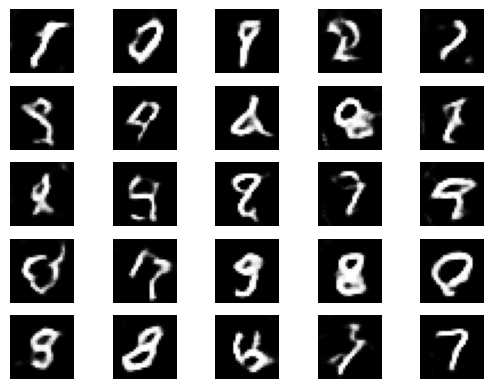

In [ ]:
epochs = 5
batch_size = 8
gan_batch_size = 25
train_dataset, y_train, val_dataset, y_val = load_data()
step_per_epoch = len(train_dataset)//batch_size

# set epoch smaller to save time
step_per_epoch = step_per_epoch//10

for i in range(epochs):
    for step in tqdm.tqdm(range(step_per_epoch)):

        real_image, real_label = gen_real_image(train_dataset, batch_size)
        z_input = gen_z_input(batch_size)
        fake_image = generator.predict(z_input)
        fake_label = gen_label(batch_size, is_real=False)

        discriminator.trainable = True
        discriminator.train_on_batch(real_image, real_label)
        discriminator.train_on_batch(fake_image, fake_label)

        discriminator.trainable = False
        gan_fake_label = gen_label(batch_size, is_real=True)
        GAN_model.train_on_batch(z_input, gan_fake_label)

    # real_acc, fake_acc = val_model(discriminator, generator, val_dataset)
    # dis_acc = (real_acc+ fake_acc)/2
    # gan_acc = val_gan_model(GAN_model)
    # print("train gan_model: epoch {} step {} ---> dis_acc {}, gan_acc {}".format(i, step, dis_acc, gan_acc))

    val_input = gen_z_input(gan_batch_size)
    val_image = generator.predict(val_input)
    plot_image(val_image)